# Set Up
- Download the ECG dataset hosted on kaggle. **This step requires a Kaggle API token.**
- Clone the project repository to access the experiment models

In [1]:
!pip install -q kaggle
!pip install lime
!pip install torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=f99e77a18021889acfcebe78f0b513618d77545332aeb17a6b2d01bafdf882c3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=c47ce63b489335cf455d2646f74889a3b475f24d96a771f2486287971785706a
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
from google.colab import files

uploaded = files.upload()

# make sure there is a kaggle.json file
!ls -lha kaggle.json

# install the Kaggle API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Dec  8 23:41 kaggle.json


In [3]:
# download and unzip the ECG dataset hosted on kaggle
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip -q heartbeat.zip

# clone the project github repository
!git clone https://github.com/distributedgarden/tsc_attention.git

 99% 98.0M/98.8M [00:03<00:00, 42.6MB/s]
100% 98.8M/98.8M [00:03<00:00, 32.3MB/s]
Cloning into 'tsc_attention'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 386 (delta 92), reused 106 (delta 39), pack-reused 203
Receiving objects: 100% (386/386), 39.61 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (203/203), done.


# OSCNN Experiment
### Description
Use Stratified K-Fold Cross Validation to evaluate the OSCNN model on the ECG dataset.

In [4]:
import logging
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot
from IPython.core.display import HTML
from itertools import cycle
from functools import partial


%cd tsc_attention
from src.models.os_cnn import OSCNN
from src.models.attention_os_cnn import AttentionOSCNN
from src.utils import (
    evaluate,
    plot_metrics,
    plot_incorrect_predictions,
    visualize_model_graph,
    sample,
    batch_predict,
    explain_instance,
    roc_plot,
    generate_saliency_map,
    saliency_maps,
    overlay_saliency_maps,
)
%cd ..



/content/tsc_attention
/content


In [5]:
logging.root.handlers = []

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

logging.info("Test")

2023-12-08 23:41:57,989 - root - INFO - Test


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# load data
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

# last column is the label
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print(len(train_df))
print(len(test_df))
print(len(X_train[1]))
print(X_train[1])

87554
21892
187
[0.96011394 0.86324787 0.46153846 0.1965812  0.0940171  0.12535612
 0.0997151  0.08831909 0.07407407 0.08262108 0.07407407 0.06267806
 0.06552707 0.06552707 0.06267806 0.07692308 0.07122507 0.08262108
 0.09116809 0.09686609 0.08262108 0.08262108 0.09116809 0.10541311
 0.12250713 0.14814815 0.18233618 0.19373219 0.21367522 0.20797721
 0.22222222 0.25356126 0.27065527 0.28774929 0.28490028 0.29344729
 0.25641027 0.24786325 0.18803419 0.14529915 0.10826211 0.08262108
 0.07977208 0.07407407 0.01424501 0.01139601 0.06267806 0.05128205
 0.05698006 0.04843305 0.02849003 0.03133903 0.07692308 0.02564103
 0.02849003 0.03703704 0.0940171  0.08547009 0.03988604 0.05982906
 0.07407407 0.07977208 0.09116809 0.0997151  0.10826211 0.08831909
 0.09116809 0.06552707 0.08547009 0.08831909 0.07692308 0.08262108
 0.09686609 0.0997151  0.13390313 0.1025641  0.03988604 0.06552707
 0.07407407 0.08262108 0.08547009 0.05698006 0.04558405 0.1025641
 0.03988604 0.01139601 0.01709402 0.03133903 0.

In [8]:
# normalize the ECG signals
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# concatenate the data
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# convert to tensors
X_tensor = torch.tensor(X).float().unsqueeze(2)  # adding channel dimension
y_tensor = torch.tensor(y).long()

# create a single dataset
dataset = TensorDataset(X_tensor, y_tensor)
dataset_y = np.array(dataset.tensors[1])

In [9]:
# cross-validation parameters
num_epochs = 10
k_folds = 10
#kfold = KFold(n_splits=k_folds, shuffle=True)
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
batch_size = 32

In [10]:
epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses = [], [], [], [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset_y)):
    print(f"FOLD {fold}")
    print("--------------------------------")

    # store metrics of each fold
    accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

    # split data
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # data loaders for training and testing data in this fold
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # set parameters
    #input_dim = 1         # ECG data is univariate, so the input dimension is 1
    #hidden_dim = 128
    #num_layers = 2
    num_classes = 5

    # initialize model for this fold
    model = OSCNN(num_classes)
    model.to(device)
    print(model)

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # train
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # store metrics
        accuracy, precision, recall, f1, _, _ = evaluate(model, test_loader)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Accumulate metrics for each epoch across folds
        if fold == 0:
            # Initialize lists in the first fold
            epoch_acc.append(accuracy)
            epoch_prc.append(precision)
            epoch_rec.append(recall)
            epoch_f1.append(f1)
            epoch_losses.append(batch_losses)
        else:
            # Add to existing totals for subsequent folds
            epoch_acc[epoch] += accuracy
            epoch_prc[epoch] += precision
            epoch_rec[epoch] += recall
            epoch_f1[epoch] += f1
            epoch_losses[epoch].extend(batch_losses)

# Average metrics across all folds for each epoch
epoch_acc = [x / k_folds for x in epoch_acc]
epoch_prc = [x / k_folds for x in epoch_prc]
epoch_rec = [x / k_folds for x in epoch_rec]
epoch_f1 = [x / k_folds for x in epoch_f1]
epoch_losses = [sum(x) / len(x) for x in epoch_losses]

# Print average metrics for each epoch
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} - Avg Accuracy: {epoch_acc[epoch]}, Avg Precision: {epoch_prc[epoch]}, Avg Recall: {epoch_rec[epoch]}, Avg F1 Score: {epoch_f1[epoch]}, Avg Loss: {epoch_losses[epoch]}")

FOLD 0
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [1/10], Step [100/3079], Loss: 0.3790
Epoch [1/10], Step [200/3079], Loss: 0.4412
Epoch [1/10], Step [300/3079], Loss: 0.5075
Epoch [1/10], Step [400/3079], Loss: 0.1970
Epoch [1/10], Step [500/3079], Loss: 0.1952
Epoch [1/10], Step [600/3079], Loss: 0.5000
Epoch [1/10], Step [700/3079], Loss: 0.2418
Epoch [1/10], Step [800/3079], Loss: 0.1325
Epoch [1/10], Step [900/3079], Loss: 0.2764
Epoch [1/10], Step [1000/3079], Loss: 0.3537
Epoch [1/10], Step [1100/3079], Loss: 0.2111
Epoch [1/10], Step [1200/3079], Loss: 0.1597
Epoch [1/10], Step [1300/3079], Loss: 0.1539
Epoch [1/10], Step [1400/3079], Loss: 0.2269
Epoch [1/10], Step [1500/3079], Loss: 0.1344
Epoch [1/10], Step [1600/3079], Loss: 0.2807
Epoch [1/10], Step [1700/3079], Loss: 0.4278
Epoch [1/10], Step [1800/3079], Loss: 0.1947
Epoch [1/10], Step [1900/3079], Loss: 0.2207
Epoch [1/10], Step [2000/3079], Loss: 0.6988
Epoch [1/10], Step [2100/3079], Loss: 0.1581
Epoch [1/10], Step [2200/3079], Loss: 0.2083
Epoch [1/10], Step 

2023-12-08 23:42:28,766 - root - INFO - Accuracy: 95.41%
2023-12-08 23:42:28,767 - root - INFO - Precision: 0.9530
2023-12-08 23:42:28,768 - root - INFO - Recall: 0.9541
2023-12-08 23:42:28,769 - root - INFO - F1 Score: 0.9491


Epoch [2/10], Step [100/3079], Loss: 0.0419
Epoch [2/10], Step [200/3079], Loss: 0.0618
Epoch [2/10], Step [300/3079], Loss: 0.2458
Epoch [2/10], Step [400/3079], Loss: 0.2560
Epoch [2/10], Step [500/3079], Loss: 0.1973
Epoch [2/10], Step [600/3079], Loss: 0.0869
Epoch [2/10], Step [700/3079], Loss: 0.1537
Epoch [2/10], Step [800/3079], Loss: 0.0533
Epoch [2/10], Step [900/3079], Loss: 0.0452
Epoch [2/10], Step [1000/3079], Loss: 0.0597
Epoch [2/10], Step [1100/3079], Loss: 0.0673
Epoch [2/10], Step [1200/3079], Loss: 0.1143
Epoch [2/10], Step [1300/3079], Loss: 0.1778
Epoch [2/10], Step [1400/3079], Loss: 0.2442
Epoch [2/10], Step [1500/3079], Loss: 0.1999
Epoch [2/10], Step [1600/3079], Loss: 0.0355
Epoch [2/10], Step [1700/3079], Loss: 0.0394
Epoch [2/10], Step [1800/3079], Loss: 0.0372
Epoch [2/10], Step [1900/3079], Loss: 0.0824
Epoch [2/10], Step [2000/3079], Loss: 0.1097
Epoch [2/10], Step [2100/3079], Loss: 0.1092
Epoch [2/10], Step [2200/3079], Loss: 0.0353
Epoch [2/10], Step 

2023-12-08 23:42:40,290 - root - INFO - Accuracy: 96.49%
2023-12-08 23:42:40,291 - root - INFO - Precision: 0.9654
2023-12-08 23:42:40,292 - root - INFO - Recall: 0.9649
2023-12-08 23:42:40,294 - root - INFO - F1 Score: 0.9609


Epoch [3/10], Step [100/3079], Loss: 0.0949
Epoch [3/10], Step [200/3079], Loss: 0.1969
Epoch [3/10], Step [300/3079], Loss: 0.0305
Epoch [3/10], Step [400/3079], Loss: 0.1608
Epoch [3/10], Step [500/3079], Loss: 0.2819
Epoch [3/10], Step [600/3079], Loss: 0.1225
Epoch [3/10], Step [700/3079], Loss: 0.2906
Epoch [3/10], Step [800/3079], Loss: 0.1336
Epoch [3/10], Step [900/3079], Loss: 0.0846
Epoch [3/10], Step [1000/3079], Loss: 0.0183
Epoch [3/10], Step [1100/3079], Loss: 0.0622
Epoch [3/10], Step [1200/3079], Loss: 0.0957
Epoch [3/10], Step [1300/3079], Loss: 0.1530
Epoch [3/10], Step [1400/3079], Loss: 0.1294
Epoch [3/10], Step [1500/3079], Loss: 0.2530
Epoch [3/10], Step [1600/3079], Loss: 0.1364
Epoch [3/10], Step [1700/3079], Loss: 0.3157
Epoch [3/10], Step [1800/3079], Loss: 0.0427
Epoch [3/10], Step [1900/3079], Loss: 0.0472
Epoch [3/10], Step [2000/3079], Loss: 0.1065
Epoch [3/10], Step [2100/3079], Loss: 0.2045
Epoch [3/10], Step [2200/3079], Loss: 0.0167
Epoch [3/10], Step 

2023-12-08 23:42:51,773 - root - INFO - Accuracy: 97.33%
2023-12-08 23:42:51,774 - root - INFO - Precision: 0.9723
2023-12-08 23:42:51,775 - root - INFO - Recall: 0.9733
2023-12-08 23:42:51,776 - root - INFO - F1 Score: 0.9717


Epoch [4/10], Step [100/3079], Loss: 0.0925
Epoch [4/10], Step [200/3079], Loss: 0.0899
Epoch [4/10], Step [300/3079], Loss: 0.0295
Epoch [4/10], Step [400/3079], Loss: 0.2512
Epoch [4/10], Step [500/3079], Loss: 0.7574
Epoch [4/10], Step [600/3079], Loss: 0.3384
Epoch [4/10], Step [700/3079], Loss: 0.0321
Epoch [4/10], Step [800/3079], Loss: 0.0207
Epoch [4/10], Step [900/3079], Loss: 0.0310
Epoch [4/10], Step [1000/3079], Loss: 0.0868
Epoch [4/10], Step [1100/3079], Loss: 0.0220
Epoch [4/10], Step [1200/3079], Loss: 0.1119
Epoch [4/10], Step [1300/3079], Loss: 0.2245
Epoch [4/10], Step [1400/3079], Loss: 0.0121
Epoch [4/10], Step [1500/3079], Loss: 0.1526
Epoch [4/10], Step [1600/3079], Loss: 0.0521
Epoch [4/10], Step [1700/3079], Loss: 0.0594
Epoch [4/10], Step [1800/3079], Loss: 0.1086
Epoch [4/10], Step [1900/3079], Loss: 0.2266
Epoch [4/10], Step [2000/3079], Loss: 0.0910
Epoch [4/10], Step [2100/3079], Loss: 0.0296
Epoch [4/10], Step [2200/3079], Loss: 0.1228
Epoch [4/10], Step 

2023-12-08 23:43:03,325 - root - INFO - Accuracy: 97.35%
2023-12-08 23:43:03,326 - root - INFO - Precision: 0.9730
2023-12-08 23:43:03,327 - root - INFO - Recall: 0.9735
2023-12-08 23:43:03,328 - root - INFO - F1 Score: 0.9724


Epoch [5/10], Step [100/3079], Loss: 0.1266
Epoch [5/10], Step [200/3079], Loss: 0.0533
Epoch [5/10], Step [300/3079], Loss: 0.0301
Epoch [5/10], Step [400/3079], Loss: 0.0407
Epoch [5/10], Step [500/3079], Loss: 0.0495
Epoch [5/10], Step [600/3079], Loss: 0.2173
Epoch [5/10], Step [700/3079], Loss: 0.0572
Epoch [5/10], Step [800/3079], Loss: 0.1911
Epoch [5/10], Step [900/3079], Loss: 0.1190
Epoch [5/10], Step [1000/3079], Loss: 0.0232
Epoch [5/10], Step [1100/3079], Loss: 0.1534
Epoch [5/10], Step [1200/3079], Loss: 0.3017
Epoch [5/10], Step [1300/3079], Loss: 0.2061
Epoch [5/10], Step [1400/3079], Loss: 0.0185
Epoch [5/10], Step [1500/3079], Loss: 0.1872
Epoch [5/10], Step [1600/3079], Loss: 0.0486
Epoch [5/10], Step [1700/3079], Loss: 0.1578
Epoch [5/10], Step [1800/3079], Loss: 0.1250
Epoch [5/10], Step [1900/3079], Loss: 0.1060
Epoch [5/10], Step [2000/3079], Loss: 0.3986
Epoch [5/10], Step [2100/3079], Loss: 0.0313
Epoch [5/10], Step [2200/3079], Loss: 0.0703
Epoch [5/10], Step 

2023-12-08 23:43:14,837 - root - INFO - Accuracy: 97.14%
2023-12-08 23:43:14,838 - root - INFO - Precision: 0.9713
2023-12-08 23:43:14,839 - root - INFO - Recall: 0.9714
2023-12-08 23:43:14,842 - root - INFO - F1 Score: 0.9706


Epoch [6/10], Step [100/3079], Loss: 0.0347
Epoch [6/10], Step [200/3079], Loss: 0.0481
Epoch [6/10], Step [300/3079], Loss: 0.2288
Epoch [6/10], Step [400/3079], Loss: 0.0150
Epoch [6/10], Step [500/3079], Loss: 0.0529
Epoch [6/10], Step [600/3079], Loss: 0.0071
Epoch [6/10], Step [700/3079], Loss: 0.0461
Epoch [6/10], Step [800/3079], Loss: 0.1787
Epoch [6/10], Step [900/3079], Loss: 0.0113
Epoch [6/10], Step [1000/3079], Loss: 0.1005
Epoch [6/10], Step [1100/3079], Loss: 0.2709
Epoch [6/10], Step [1200/3079], Loss: 0.0237
Epoch [6/10], Step [1300/3079], Loss: 0.2786
Epoch [6/10], Step [1400/3079], Loss: 0.0267
Epoch [6/10], Step [1500/3079], Loss: 0.0721
Epoch [6/10], Step [1600/3079], Loss: 0.1139
Epoch [6/10], Step [1700/3079], Loss: 0.0182
Epoch [6/10], Step [1800/3079], Loss: 0.0120
Epoch [6/10], Step [1900/3079], Loss: 0.0321
Epoch [6/10], Step [2000/3079], Loss: 0.0326
Epoch [6/10], Step [2100/3079], Loss: 0.0059
Epoch [6/10], Step [2200/3079], Loss: 0.0337
Epoch [6/10], Step 

2023-12-08 23:43:26,275 - root - INFO - Accuracy: 97.73%
2023-12-08 23:43:26,276 - root - INFO - Precision: 0.9768
2023-12-08 23:43:26,278 - root - INFO - Recall: 0.9773
2023-12-08 23:43:26,279 - root - INFO - F1 Score: 0.9761


Epoch [7/10], Step [100/3079], Loss: 0.0410
Epoch [7/10], Step [200/3079], Loss: 0.0940
Epoch [7/10], Step [300/3079], Loss: 0.0434
Epoch [7/10], Step [400/3079], Loss: 0.0754
Epoch [7/10], Step [500/3079], Loss: 0.0549
Epoch [7/10], Step [600/3079], Loss: 0.1315
Epoch [7/10], Step [700/3079], Loss: 0.0142
Epoch [7/10], Step [800/3079], Loss: 0.1335
Epoch [7/10], Step [900/3079], Loss: 0.2019
Epoch [7/10], Step [1000/3079], Loss: 0.1588
Epoch [7/10], Step [1100/3079], Loss: 0.0449
Epoch [7/10], Step [1200/3079], Loss: 0.1603
Epoch [7/10], Step [1300/3079], Loss: 0.0831
Epoch [7/10], Step [1400/3079], Loss: 0.0704
Epoch [7/10], Step [1500/3079], Loss: 0.0438
Epoch [7/10], Step [1600/3079], Loss: 0.0443
Epoch [7/10], Step [1700/3079], Loss: 0.0347
Epoch [7/10], Step [1800/3079], Loss: 0.0084
Epoch [7/10], Step [1900/3079], Loss: 0.0109
Epoch [7/10], Step [2000/3079], Loss: 0.0137
Epoch [7/10], Step [2100/3079], Loss: 0.2674
Epoch [7/10], Step [2200/3079], Loss: 0.1677
Epoch [7/10], Step 

2023-12-08 23:43:37,704 - root - INFO - Accuracy: 97.55%
2023-12-08 23:43:37,705 - root - INFO - Precision: 0.9752
2023-12-08 23:43:37,706 - root - INFO - Recall: 0.9755
2023-12-08 23:43:37,707 - root - INFO - F1 Score: 0.9737


Epoch [8/10], Step [100/3079], Loss: 0.0123
Epoch [8/10], Step [200/3079], Loss: 0.0700
Epoch [8/10], Step [300/3079], Loss: 0.1271
Epoch [8/10], Step [400/3079], Loss: 0.1494
Epoch [8/10], Step [500/3079], Loss: 0.0985
Epoch [8/10], Step [600/3079], Loss: 0.2826
Epoch [8/10], Step [700/3079], Loss: 0.1221
Epoch [8/10], Step [800/3079], Loss: 0.0819
Epoch [8/10], Step [900/3079], Loss: 0.0146
Epoch [8/10], Step [1000/3079], Loss: 0.0190
Epoch [8/10], Step [1100/3079], Loss: 0.0595
Epoch [8/10], Step [1200/3079], Loss: 0.0307
Epoch [8/10], Step [1300/3079], Loss: 0.2012
Epoch [8/10], Step [1400/3079], Loss: 0.0197
Epoch [8/10], Step [1500/3079], Loss: 0.1204
Epoch [8/10], Step [1600/3079], Loss: 0.1304
Epoch [8/10], Step [1700/3079], Loss: 0.1625
Epoch [8/10], Step [1800/3079], Loss: 0.0108
Epoch [8/10], Step [1900/3079], Loss: 0.0297
Epoch [8/10], Step [2000/3079], Loss: 0.0159
Epoch [8/10], Step [2100/3079], Loss: 0.0147
Epoch [8/10], Step [2200/3079], Loss: 0.1350
Epoch [8/10], Step 

2023-12-08 23:43:49,292 - root - INFO - Accuracy: 97.68%
2023-12-08 23:43:49,294 - root - INFO - Precision: 0.9761
2023-12-08 23:43:49,294 - root - INFO - Recall: 0.9768
2023-12-08 23:43:49,295 - root - INFO - F1 Score: 0.9756


Epoch [9/10], Step [100/3079], Loss: 0.1440
Epoch [9/10], Step [200/3079], Loss: 0.1606
Epoch [9/10], Step [300/3079], Loss: 0.0495
Epoch [9/10], Step [400/3079], Loss: 0.1491
Epoch [9/10], Step [500/3079], Loss: 0.0270
Epoch [9/10], Step [600/3079], Loss: 0.1351
Epoch [9/10], Step [700/3079], Loss: 0.0907
Epoch [9/10], Step [800/3079], Loss: 0.0199
Epoch [9/10], Step [900/3079], Loss: 0.0610
Epoch [9/10], Step [1000/3079], Loss: 0.1310
Epoch [9/10], Step [1100/3079], Loss: 0.1176
Epoch [9/10], Step [1200/3079], Loss: 0.1873
Epoch [9/10], Step [1300/3079], Loss: 0.0179
Epoch [9/10], Step [1400/3079], Loss: 0.2670
Epoch [9/10], Step [1500/3079], Loss: 0.0270
Epoch [9/10], Step [1600/3079], Loss: 0.0237
Epoch [9/10], Step [1700/3079], Loss: 0.0204
Epoch [9/10], Step [1800/3079], Loss: 0.0123
Epoch [9/10], Step [1900/3079], Loss: 0.0177
Epoch [9/10], Step [2000/3079], Loss: 0.0142
Epoch [9/10], Step [2100/3079], Loss: 0.0254
Epoch [9/10], Step [2200/3079], Loss: 0.0494
Epoch [9/10], Step 

2023-12-08 23:44:00,875 - root - INFO - Accuracy: 98.12%
2023-12-08 23:44:00,876 - root - INFO - Precision: 0.9806
2023-12-08 23:44:00,877 - root - INFO - Recall: 0.9812
2023-12-08 23:44:00,878 - root - INFO - F1 Score: 0.9802


Epoch [10/10], Step [100/3079], Loss: 0.0953
Epoch [10/10], Step [200/3079], Loss: 0.0490
Epoch [10/10], Step [300/3079], Loss: 0.1192
Epoch [10/10], Step [400/3079], Loss: 0.0194
Epoch [10/10], Step [500/3079], Loss: 0.0939
Epoch [10/10], Step [600/3079], Loss: 0.0344
Epoch [10/10], Step [700/3079], Loss: 0.0750
Epoch [10/10], Step [800/3079], Loss: 0.0490
Epoch [10/10], Step [900/3079], Loss: 0.2180
Epoch [10/10], Step [1000/3079], Loss: 0.2843
Epoch [10/10], Step [1100/3079], Loss: 0.2576
Epoch [10/10], Step [1200/3079], Loss: 0.0549
Epoch [10/10], Step [1300/3079], Loss: 0.2154
Epoch [10/10], Step [1400/3079], Loss: 0.0478
Epoch [10/10], Step [1500/3079], Loss: 0.0980
Epoch [10/10], Step [1600/3079], Loss: 0.1001
Epoch [10/10], Step [1700/3079], Loss: 0.0989
Epoch [10/10], Step [1800/3079], Loss: 0.1423
Epoch [10/10], Step [1900/3079], Loss: 0.0137
Epoch [10/10], Step [2000/3079], Loss: 0.0204
Epoch [10/10], Step [2100/3079], Loss: 0.0831
Epoch [10/10], Step [2200/3079], Loss: 0.08

2023-12-08 23:44:12,349 - root - INFO - Accuracy: 97.63%
2023-12-08 23:44:12,350 - root - INFO - Precision: 0.9760
2023-12-08 23:44:12,351 - root - INFO - Recall: 0.9763
2023-12-08 23:44:12,352 - root - INFO - F1 Score: 0.9749


FOLD 1
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7915
Epoch [1/10], Step [200/3079], Loss: 0.3777
Epoch [1/10], Step [300/3079], Loss: 0.4496
Epoch [1/10], Step [400/3079], Loss: 0.1763
Epoch [1/10], Step [500/3079], Loss: 0.2065
Epoch [1/10], Step [600/3079], Loss: 0.2819
Epoch [1/10], Step [700/3079], Loss: 0.1695
Epoch [1/10], Step [800/3079], Loss: 0.4360
Epoch 

2023-12-08 23:44:23,683 - root - INFO - Accuracy: 96.13%
2023-12-08 23:44:23,685 - root - INFO - Precision: 0.9609
2023-12-08 23:44:23,685 - root - INFO - Recall: 0.9613
2023-12-08 23:44:23,686 - root - INFO - F1 Score: 0.9577


Epoch [2/10], Step [100/3079], Loss: 0.0665
Epoch [2/10], Step [200/3079], Loss: 0.1555
Epoch [2/10], Step [300/3079], Loss: 0.1657
Epoch [2/10], Step [400/3079], Loss: 0.2244
Epoch [2/10], Step [500/3079], Loss: 0.0459
Epoch [2/10], Step [600/3079], Loss: 0.2417
Epoch [2/10], Step [700/3079], Loss: 0.0507
Epoch [2/10], Step [800/3079], Loss: 0.3498
Epoch [2/10], Step [900/3079], Loss: 0.0491
Epoch [2/10], Step [1000/3079], Loss: 0.1722
Epoch [2/10], Step [1100/3079], Loss: 0.2951
Epoch [2/10], Step [1200/3079], Loss: 0.1576
Epoch [2/10], Step [1300/3079], Loss: 0.0447
Epoch [2/10], Step [1400/3079], Loss: 0.0372
Epoch [2/10], Step [1500/3079], Loss: 0.2149
Epoch [2/10], Step [1600/3079], Loss: 0.1737
Epoch [2/10], Step [1700/3079], Loss: 0.2589
Epoch [2/10], Step [1800/3079], Loss: 0.0598
Epoch [2/10], Step [1900/3079], Loss: 0.2514
Epoch [2/10], Step [2000/3079], Loss: 0.0439
Epoch [2/10], Step [2100/3079], Loss: 0.0478
Epoch [2/10], Step [2200/3079], Loss: 0.2336
Epoch [2/10], Step 

2023-12-08 23:44:35,198 - root - INFO - Accuracy: 96.63%
2023-12-08 23:44:35,199 - root - INFO - Precision: 0.9658
2023-12-08 23:44:35,199 - root - INFO - Recall: 0.9663
2023-12-08 23:44:35,200 - root - INFO - F1 Score: 0.9643


Epoch [3/10], Step [100/3079], Loss: 0.2167
Epoch [3/10], Step [200/3079], Loss: 0.1416
Epoch [3/10], Step [300/3079], Loss: 0.3117
Epoch [3/10], Step [400/3079], Loss: 0.0340
Epoch [3/10], Step [500/3079], Loss: 0.1913
Epoch [3/10], Step [600/3079], Loss: 0.1750
Epoch [3/10], Step [700/3079], Loss: 0.1668
Epoch [3/10], Step [800/3079], Loss: 0.1704
Epoch [3/10], Step [900/3079], Loss: 0.1252
Epoch [3/10], Step [1000/3079], Loss: 0.0972
Epoch [3/10], Step [1100/3079], Loss: 0.1098
Epoch [3/10], Step [1200/3079], Loss: 0.3100
Epoch [3/10], Step [1300/3079], Loss: 0.0591
Epoch [3/10], Step [1400/3079], Loss: 0.1518
Epoch [3/10], Step [1500/3079], Loss: 0.0193
Epoch [3/10], Step [1600/3079], Loss: 0.2882
Epoch [3/10], Step [1700/3079], Loss: 0.0189
Epoch [3/10], Step [1800/3079], Loss: 0.1463
Epoch [3/10], Step [1900/3079], Loss: 0.1137
Epoch [3/10], Step [2000/3079], Loss: 0.0155
Epoch [3/10], Step [2100/3079], Loss: 0.0604
Epoch [3/10], Step [2200/3079], Loss: 0.0208
Epoch [3/10], Step 

2023-12-08 23:44:46,605 - root - INFO - Accuracy: 96.92%
2023-12-08 23:44:46,606 - root - INFO - Precision: 0.9683
2023-12-08 23:44:46,607 - root - INFO - Recall: 0.9692
2023-12-08 23:44:46,609 - root - INFO - F1 Score: 0.9666


Epoch [4/10], Step [100/3079], Loss: 0.0183
Epoch [4/10], Step [200/3079], Loss: 0.0738
Epoch [4/10], Step [300/3079], Loss: 0.0405
Epoch [4/10], Step [400/3079], Loss: 0.1513
Epoch [4/10], Step [500/3079], Loss: 0.1482
Epoch [4/10], Step [600/3079], Loss: 0.0484
Epoch [4/10], Step [700/3079], Loss: 0.0247
Epoch [4/10], Step [800/3079], Loss: 0.0410
Epoch [4/10], Step [900/3079], Loss: 0.1514
Epoch [4/10], Step [1000/3079], Loss: 0.3137
Epoch [4/10], Step [1100/3079], Loss: 0.0160
Epoch [4/10], Step [1200/3079], Loss: 0.0498
Epoch [4/10], Step [1300/3079], Loss: 0.0618
Epoch [4/10], Step [1400/3079], Loss: 0.2802
Epoch [4/10], Step [1500/3079], Loss: 0.1648
Epoch [4/10], Step [1600/3079], Loss: 0.2304
Epoch [4/10], Step [1700/3079], Loss: 0.0373
Epoch [4/10], Step [1800/3079], Loss: 0.1317
Epoch [4/10], Step [1900/3079], Loss: 0.1986
Epoch [4/10], Step [2000/3079], Loss: 0.0709
Epoch [4/10], Step [2100/3079], Loss: 0.1288
Epoch [4/10], Step [2200/3079], Loss: 0.0566
Epoch [4/10], Step 

2023-12-08 23:44:58,205 - root - INFO - Accuracy: 97.41%
2023-12-08 23:44:58,206 - root - INFO - Precision: 0.9731
2023-12-08 23:44:58,207 - root - INFO - Recall: 0.9741
2023-12-08 23:44:58,208 - root - INFO - F1 Score: 0.9732


Epoch [5/10], Step [100/3079], Loss: 0.0313
Epoch [5/10], Step [200/3079], Loss: 0.0813
Epoch [5/10], Step [300/3079], Loss: 0.0309
Epoch [5/10], Step [400/3079], Loss: 0.7289
Epoch [5/10], Step [500/3079], Loss: 0.1365
Epoch [5/10], Step [600/3079], Loss: 0.2166
Epoch [5/10], Step [700/3079], Loss: 0.0544
Epoch [5/10], Step [800/3079], Loss: 0.0383
Epoch [5/10], Step [900/3079], Loss: 0.2222
Epoch [5/10], Step [1000/3079], Loss: 0.0867
Epoch [5/10], Step [1100/3079], Loss: 0.0474
Epoch [5/10], Step [1200/3079], Loss: 0.2053
Epoch [5/10], Step [1300/3079], Loss: 0.0600
Epoch [5/10], Step [1400/3079], Loss: 0.3610
Epoch [5/10], Step [1500/3079], Loss: 0.0631
Epoch [5/10], Step [1600/3079], Loss: 0.0159
Epoch [5/10], Step [1700/3079], Loss: 0.1562
Epoch [5/10], Step [1800/3079], Loss: 0.0250
Epoch [5/10], Step [1900/3079], Loss: 0.3750
Epoch [5/10], Step [2000/3079], Loss: 0.0809
Epoch [5/10], Step [2100/3079], Loss: 0.1383
Epoch [5/10], Step [2200/3079], Loss: 0.0555
Epoch [5/10], Step 

2023-12-08 23:45:09,718 - root - INFO - Accuracy: 97.54%
2023-12-08 23:45:09,719 - root - INFO - Precision: 0.9748
2023-12-08 23:45:09,720 - root - INFO - Recall: 0.9754
2023-12-08 23:45:09,721 - root - INFO - F1 Score: 0.9742


Epoch [6/10], Step [100/3079], Loss: 0.0352
Epoch [6/10], Step [200/3079], Loss: 0.0716
Epoch [6/10], Step [300/3079], Loss: 0.0044
Epoch [6/10], Step [400/3079], Loss: 0.0121
Epoch [6/10], Step [500/3079], Loss: 0.0276
Epoch [6/10], Step [600/3079], Loss: 0.0161
Epoch [6/10], Step [700/3079], Loss: 0.4010
Epoch [6/10], Step [800/3079], Loss: 0.0616
Epoch [6/10], Step [900/3079], Loss: 0.0125
Epoch [6/10], Step [1000/3079], Loss: 0.1392
Epoch [6/10], Step [1100/3079], Loss: 0.3606
Epoch [6/10], Step [1200/3079], Loss: 0.0207
Epoch [6/10], Step [1300/3079], Loss: 0.1440
Epoch [6/10], Step [1400/3079], Loss: 0.0433
Epoch [6/10], Step [1500/3079], Loss: 0.0780
Epoch [6/10], Step [1600/3079], Loss: 0.0823
Epoch [6/10], Step [1700/3079], Loss: 0.1001
Epoch [6/10], Step [1800/3079], Loss: 0.0759
Epoch [6/10], Step [1900/3079], Loss: 0.0187
Epoch [6/10], Step [2000/3079], Loss: 0.1413
Epoch [6/10], Step [2100/3079], Loss: 0.0981
Epoch [6/10], Step [2200/3079], Loss: 0.2629
Epoch [6/10], Step 

2023-12-08 23:45:21,189 - root - INFO - Accuracy: 97.30%
2023-12-08 23:45:21,190 - root - INFO - Precision: 0.9724
2023-12-08 23:45:21,191 - root - INFO - Recall: 0.9730
2023-12-08 23:45:21,192 - root - INFO - F1 Score: 0.9708


Epoch [7/10], Step [100/3079], Loss: 0.0745
Epoch [7/10], Step [200/3079], Loss: 0.0248
Epoch [7/10], Step [300/3079], Loss: 0.0220
Epoch [7/10], Step [400/3079], Loss: 0.3094
Epoch [7/10], Step [500/3079], Loss: 0.0253
Epoch [7/10], Step [600/3079], Loss: 0.1162
Epoch [7/10], Step [700/3079], Loss: 0.0383
Epoch [7/10], Step [800/3079], Loss: 0.0186
Epoch [7/10], Step [900/3079], Loss: 0.0234
Epoch [7/10], Step [1000/3079], Loss: 0.0107
Epoch [7/10], Step [1100/3079], Loss: 0.0257
Epoch [7/10], Step [1200/3079], Loss: 0.0778
Epoch [7/10], Step [1300/3079], Loss: 0.0432
Epoch [7/10], Step [1400/3079], Loss: 0.2056
Epoch [7/10], Step [1500/3079], Loss: 0.3385
Epoch [7/10], Step [1600/3079], Loss: 0.0511
Epoch [7/10], Step [1700/3079], Loss: 0.2409
Epoch [7/10], Step [1800/3079], Loss: 0.0611
Epoch [7/10], Step [1900/3079], Loss: 0.0548
Epoch [7/10], Step [2000/3079], Loss: 0.0681
Epoch [7/10], Step [2100/3079], Loss: 0.0229
Epoch [7/10], Step [2200/3079], Loss: 0.3628
Epoch [7/10], Step 

2023-12-08 23:45:32,670 - root - INFO - Accuracy: 97.22%
2023-12-08 23:45:32,671 - root - INFO - Precision: 0.9722
2023-12-08 23:45:32,672 - root - INFO - Recall: 0.9722
2023-12-08 23:45:32,673 - root - INFO - F1 Score: 0.9705


Epoch [8/10], Step [100/3079], Loss: 0.0947
Epoch [8/10], Step [200/3079], Loss: 0.0357
Epoch [8/10], Step [300/3079], Loss: 0.0311
Epoch [8/10], Step [400/3079], Loss: 0.1300
Epoch [8/10], Step [500/3079], Loss: 0.0087
Epoch [8/10], Step [600/3079], Loss: 0.0212
Epoch [8/10], Step [700/3079], Loss: 0.0274
Epoch [8/10], Step [800/3079], Loss: 0.0134
Epoch [8/10], Step [900/3079], Loss: 0.1758
Epoch [8/10], Step [1000/3079], Loss: 0.1451
Epoch [8/10], Step [1100/3079], Loss: 0.0092
Epoch [8/10], Step [1200/3079], Loss: 0.0452
Epoch [8/10], Step [1300/3079], Loss: 0.3354
Epoch [8/10], Step [1400/3079], Loss: 0.0368
Epoch [8/10], Step [1500/3079], Loss: 0.0465
Epoch [8/10], Step [1600/3079], Loss: 0.0253
Epoch [8/10], Step [1700/3079], Loss: 0.1318
Epoch [8/10], Step [1800/3079], Loss: 0.1724
Epoch [8/10], Step [1900/3079], Loss: 0.0089
Epoch [8/10], Step [2000/3079], Loss: 0.0221
Epoch [8/10], Step [2100/3079], Loss: 0.1174
Epoch [8/10], Step [2200/3079], Loss: 0.1332
Epoch [8/10], Step 

2023-12-08 23:45:44,086 - root - INFO - Accuracy: 97.70%
2023-12-08 23:45:44,087 - root - INFO - Precision: 0.9764
2023-12-08 23:45:44,088 - root - INFO - Recall: 0.9770
2023-12-08 23:45:44,089 - root - INFO - F1 Score: 0.9763


Epoch [9/10], Step [100/3079], Loss: 0.0611
Epoch [9/10], Step [200/3079], Loss: 0.1420
Epoch [9/10], Step [300/3079], Loss: 0.2419
Epoch [9/10], Step [400/3079], Loss: 0.0128
Epoch [9/10], Step [500/3079], Loss: 0.1732
Epoch [9/10], Step [600/3079], Loss: 0.1229
Epoch [9/10], Step [700/3079], Loss: 0.0321
Epoch [9/10], Step [800/3079], Loss: 0.0272
Epoch [9/10], Step [900/3079], Loss: 0.0922
Epoch [9/10], Step [1000/3079], Loss: 0.1205
Epoch [9/10], Step [1100/3079], Loss: 0.2044
Epoch [9/10], Step [1200/3079], Loss: 0.0371
Epoch [9/10], Step [1300/3079], Loss: 0.0939
Epoch [9/10], Step [1400/3079], Loss: 0.0178
Epoch [9/10], Step [1500/3079], Loss: 0.0110
Epoch [9/10], Step [1600/3079], Loss: 0.1572
Epoch [9/10], Step [1700/3079], Loss: 0.0157
Epoch [9/10], Step [1800/3079], Loss: 0.1533
Epoch [9/10], Step [1900/3079], Loss: 0.1093
Epoch [9/10], Step [2000/3079], Loss: 0.2114
Epoch [9/10], Step [2100/3079], Loss: 0.0318
Epoch [9/10], Step [2200/3079], Loss: 0.0486
Epoch [9/10], Step 

2023-12-08 23:45:55,584 - root - INFO - Accuracy: 97.64%
2023-12-08 23:45:55,585 - root - INFO - Precision: 0.9759
2023-12-08 23:45:55,585 - root - INFO - Recall: 0.9764
2023-12-08 23:45:55,586 - root - INFO - F1 Score: 0.9752


Epoch [10/10], Step [100/3079], Loss: 0.0295
Epoch [10/10], Step [200/3079], Loss: 0.0275
Epoch [10/10], Step [300/3079], Loss: 0.0493
Epoch [10/10], Step [400/3079], Loss: 0.0229
Epoch [10/10], Step [500/3079], Loss: 0.1224
Epoch [10/10], Step [600/3079], Loss: 0.0357
Epoch [10/10], Step [700/3079], Loss: 0.0243
Epoch [10/10], Step [800/3079], Loss: 0.0994
Epoch [10/10], Step [900/3079], Loss: 0.0273
Epoch [10/10], Step [1000/3079], Loss: 0.0346
Epoch [10/10], Step [1100/3079], Loss: 0.0948
Epoch [10/10], Step [1200/3079], Loss: 0.0224
Epoch [10/10], Step [1300/3079], Loss: 0.0060
Epoch [10/10], Step [1400/3079], Loss: 0.4490
Epoch [10/10], Step [1500/3079], Loss: 0.0913
Epoch [10/10], Step [1600/3079], Loss: 0.0095
Epoch [10/10], Step [1700/3079], Loss: 0.2521
Epoch [10/10], Step [1800/3079], Loss: 0.0726
Epoch [10/10], Step [1900/3079], Loss: 0.0540
Epoch [10/10], Step [2000/3079], Loss: 0.0631
Epoch [10/10], Step [2100/3079], Loss: 0.0624
Epoch [10/10], Step [2200/3079], Loss: 0.02

2023-12-08 23:46:07,086 - root - INFO - Accuracy: 98.07%
2023-12-08 23:46:07,087 - root - INFO - Precision: 0.9800
2023-12-08 23:46:07,088 - root - INFO - Recall: 0.9807
2023-12-08 23:46:07,089 - root - INFO - F1 Score: 0.9800


FOLD 2
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.3340
Epoch [1/10], Step [200/3079], Loss: 0.8560
Epoch [1/10], Step [300/3079], Loss: 0.4703
Epoch [1/10], Step [400/3079], Loss: 0.6046
Epoch [1/10], Step [500/3079], Loss: 0.3828
Epoch [1/10], Step [600/3079], Loss: 0.1251
Epoch [1/10], Step [700/3079], Loss: 0.1364
Epoch [1/10], Step [800/3079], Loss: 0.2580
Epoch 

2023-12-08 23:46:18,523 - root - INFO - Accuracy: 92.80%
2023-12-08 23:46:18,524 - root - INFO - Precision: 0.9398
2023-12-08 23:46:18,526 - root - INFO - Recall: 0.9280
2023-12-08 23:46:18,527 - root - INFO - F1 Score: 0.9257


Epoch [2/10], Step [100/3079], Loss: 0.1667
Epoch [2/10], Step [200/3079], Loss: 0.1117
Epoch [2/10], Step [300/3079], Loss: 0.2450
Epoch [2/10], Step [400/3079], Loss: 0.1313
Epoch [2/10], Step [500/3079], Loss: 0.5117
Epoch [2/10], Step [600/3079], Loss: 0.0551
Epoch [2/10], Step [700/3079], Loss: 0.2147
Epoch [2/10], Step [800/3079], Loss: 0.0401
Epoch [2/10], Step [900/3079], Loss: 0.0382
Epoch [2/10], Step [1000/3079], Loss: 0.1573
Epoch [2/10], Step [1100/3079], Loss: 0.2184
Epoch [2/10], Step [1200/3079], Loss: 0.2576
Epoch [2/10], Step [1300/3079], Loss: 0.0903
Epoch [2/10], Step [1400/3079], Loss: 0.2281
Epoch [2/10], Step [1500/3079], Loss: 0.1132
Epoch [2/10], Step [1600/3079], Loss: 0.0780
Epoch [2/10], Step [1700/3079], Loss: 0.0611
Epoch [2/10], Step [1800/3079], Loss: 0.0788
Epoch [2/10], Step [1900/3079], Loss: 0.0579
Epoch [2/10], Step [2000/3079], Loss: 0.0376
Epoch [2/10], Step [2100/3079], Loss: 0.0769
Epoch [2/10], Step [2200/3079], Loss: 0.1312
Epoch [2/10], Step 

2023-12-08 23:46:30,002 - root - INFO - Accuracy: 96.35%
2023-12-08 23:46:30,004 - root - INFO - Precision: 0.9621
2023-12-08 23:46:30,004 - root - INFO - Recall: 0.9635
2023-12-08 23:46:30,005 - root - INFO - F1 Score: 0.9611


Epoch [3/10], Step [100/3079], Loss: 0.0458
Epoch [3/10], Step [200/3079], Loss: 0.0528
Epoch [3/10], Step [300/3079], Loss: 0.1887
Epoch [3/10], Step [400/3079], Loss: 0.0252
Epoch [3/10], Step [500/3079], Loss: 0.1386
Epoch [3/10], Step [600/3079], Loss: 0.2589
Epoch [3/10], Step [700/3079], Loss: 0.2228
Epoch [3/10], Step [800/3079], Loss: 0.0219
Epoch [3/10], Step [900/3079], Loss: 0.0962
Epoch [3/10], Step [1000/3079], Loss: 0.2729
Epoch [3/10], Step [1100/3079], Loss: 0.0175
Epoch [3/10], Step [1200/3079], Loss: 0.1929
Epoch [3/10], Step [1300/3079], Loss: 0.2311
Epoch [3/10], Step [1400/3079], Loss: 0.1565
Epoch [3/10], Step [1500/3079], Loss: 0.0689
Epoch [3/10], Step [1600/3079], Loss: 0.0981
Epoch [3/10], Step [1700/3079], Loss: 0.1160
Epoch [3/10], Step [1800/3079], Loss: 0.0566
Epoch [3/10], Step [1900/3079], Loss: 0.0356
Epoch [3/10], Step [2000/3079], Loss: 0.0551
Epoch [3/10], Step [2100/3079], Loss: 0.0305
Epoch [3/10], Step [2200/3079], Loss: 0.0152
Epoch [3/10], Step 

2023-12-08 23:46:41,548 - root - INFO - Accuracy: 95.71%
2023-12-08 23:46:41,549 - root - INFO - Precision: 0.9562
2023-12-08 23:46:41,550 - root - INFO - Recall: 0.9571
2023-12-08 23:46:41,551 - root - INFO - F1 Score: 0.9509


Epoch [4/10], Step [100/3079], Loss: 0.0389
Epoch [4/10], Step [200/3079], Loss: 0.2684
Epoch [4/10], Step [300/3079], Loss: 0.0641
Epoch [4/10], Step [400/3079], Loss: 0.0541
Epoch [4/10], Step [500/3079], Loss: 0.0566
Epoch [4/10], Step [600/3079], Loss: 0.2179
Epoch [4/10], Step [700/3079], Loss: 0.1946
Epoch [4/10], Step [800/3079], Loss: 0.0167
Epoch [4/10], Step [900/3079], Loss: 0.0803
Epoch [4/10], Step [1000/3079], Loss: 0.1290
Epoch [4/10], Step [1100/3079], Loss: 0.0826
Epoch [4/10], Step [1200/3079], Loss: 0.0613
Epoch [4/10], Step [1300/3079], Loss: 0.0343
Epoch [4/10], Step [1400/3079], Loss: 0.1315
Epoch [4/10], Step [1500/3079], Loss: 0.0801
Epoch [4/10], Step [1600/3079], Loss: 0.0191
Epoch [4/10], Step [1700/3079], Loss: 0.1916
Epoch [4/10], Step [1800/3079], Loss: 0.0935
Epoch [4/10], Step [1900/3079], Loss: 0.0678
Epoch [4/10], Step [2000/3079], Loss: 0.0429
Epoch [4/10], Step [2100/3079], Loss: 0.1584
Epoch [4/10], Step [2200/3079], Loss: 0.0207
Epoch [4/10], Step 

2023-12-08 23:46:53,032 - root - INFO - Accuracy: 96.80%
2023-12-08 23:46:53,033 - root - INFO - Precision: 0.9679
2023-12-08 23:46:53,034 - root - INFO - Recall: 0.9680
2023-12-08 23:46:53,035 - root - INFO - F1 Score: 0.9666


Epoch [5/10], Step [100/3079], Loss: 0.1083
Epoch [5/10], Step [200/3079], Loss: 0.0762
Epoch [5/10], Step [300/3079], Loss: 0.0407
Epoch [5/10], Step [400/3079], Loss: 0.0861
Epoch [5/10], Step [500/3079], Loss: 0.0123
Epoch [5/10], Step [600/3079], Loss: 0.0955
Epoch [5/10], Step [700/3079], Loss: 0.1586
Epoch [5/10], Step [800/3079], Loss: 0.2569
Epoch [5/10], Step [900/3079], Loss: 0.0324
Epoch [5/10], Step [1000/3079], Loss: 0.2638
Epoch [5/10], Step [1100/3079], Loss: 0.0817
Epoch [5/10], Step [1200/3079], Loss: 0.0689
Epoch [5/10], Step [1300/3079], Loss: 0.0185
Epoch [5/10], Step [1400/3079], Loss: 0.0980
Epoch [5/10], Step [1500/3079], Loss: 0.0642
Epoch [5/10], Step [1600/3079], Loss: 0.0205
Epoch [5/10], Step [1700/3079], Loss: 0.0420
Epoch [5/10], Step [1800/3079], Loss: 0.2832
Epoch [5/10], Step [1900/3079], Loss: 0.0728
Epoch [5/10], Step [2000/3079], Loss: 0.0241
Epoch [5/10], Step [2100/3079], Loss: 0.0614
Epoch [5/10], Step [2200/3079], Loss: 0.0435
Epoch [5/10], Step 

2023-12-08 23:47:04,394 - root - INFO - Accuracy: 97.33%
2023-12-08 23:47:04,395 - root - INFO - Precision: 0.9728
2023-12-08 23:47:04,396 - root - INFO - Recall: 0.9733
2023-12-08 23:47:04,397 - root - INFO - F1 Score: 0.9719


Epoch [6/10], Step [100/3079], Loss: 0.1981
Epoch [6/10], Step [200/3079], Loss: 0.0097
Epoch [6/10], Step [300/3079], Loss: 0.2509
Epoch [6/10], Step [400/3079], Loss: 0.1527
Epoch [6/10], Step [500/3079], Loss: 0.2162
Epoch [6/10], Step [600/3079], Loss: 0.0764
Epoch [6/10], Step [700/3079], Loss: 0.1278
Epoch [6/10], Step [800/3079], Loss: 0.0896
Epoch [6/10], Step [900/3079], Loss: 0.1870
Epoch [6/10], Step [1000/3079], Loss: 0.1060
Epoch [6/10], Step [1100/3079], Loss: 0.0200
Epoch [6/10], Step [1200/3079], Loss: 0.0165
Epoch [6/10], Step [1300/3079], Loss: 0.2405
Epoch [6/10], Step [1400/3079], Loss: 0.0458
Epoch [6/10], Step [1500/3079], Loss: 0.0394
Epoch [6/10], Step [1600/3079], Loss: 0.0885
Epoch [6/10], Step [1700/3079], Loss: 0.0662
Epoch [6/10], Step [1800/3079], Loss: 0.0722
Epoch [6/10], Step [1900/3079], Loss: 0.0119
Epoch [6/10], Step [2000/3079], Loss: 0.0126
Epoch [6/10], Step [2100/3079], Loss: 0.0176
Epoch [6/10], Step [2200/3079], Loss: 0.0599
Epoch [6/10], Step 

2023-12-08 23:47:15,864 - root - INFO - Accuracy: 97.19%
2023-12-08 23:47:15,865 - root - INFO - Precision: 0.9706
2023-12-08 23:47:15,866 - root - INFO - Recall: 0.9719
2023-12-08 23:47:15,867 - root - INFO - F1 Score: 0.9707


Epoch [7/10], Step [100/3079], Loss: 0.0544
Epoch [7/10], Step [200/3079], Loss: 0.1075
Epoch [7/10], Step [300/3079], Loss: 0.0515
Epoch [7/10], Step [400/3079], Loss: 0.0524
Epoch [7/10], Step [500/3079], Loss: 0.1387
Epoch [7/10], Step [600/3079], Loss: 0.0384
Epoch [7/10], Step [700/3079], Loss: 0.0492
Epoch [7/10], Step [800/3079], Loss: 0.1472
Epoch [7/10], Step [900/3079], Loss: 0.0233
Epoch [7/10], Step [1000/3079], Loss: 0.1506
Epoch [7/10], Step [1100/3079], Loss: 0.0431
Epoch [7/10], Step [1200/3079], Loss: 0.0628
Epoch [7/10], Step [1300/3079], Loss: 0.0623
Epoch [7/10], Step [1400/3079], Loss: 0.0599
Epoch [7/10], Step [1500/3079], Loss: 0.0460
Epoch [7/10], Step [1600/3079], Loss: 0.3840
Epoch [7/10], Step [1700/3079], Loss: 0.1980
Epoch [7/10], Step [1800/3079], Loss: 0.0060
Epoch [7/10], Step [1900/3079], Loss: 0.0467
Epoch [7/10], Step [2000/3079], Loss: 0.0411
Epoch [7/10], Step [2100/3079], Loss: 0.0109
Epoch [7/10], Step [2200/3079], Loss: 0.0374
Epoch [7/10], Step 

2023-12-08 23:47:27,409 - root - INFO - Accuracy: 97.09%
2023-12-08 23:47:27,410 - root - INFO - Precision: 0.9700
2023-12-08 23:47:27,411 - root - INFO - Recall: 0.9709
2023-12-08 23:47:27,411 - root - INFO - F1 Score: 0.9684


Epoch [8/10], Step [100/3079], Loss: 0.0878
Epoch [8/10], Step [200/3079], Loss: 0.0124
Epoch [8/10], Step [300/3079], Loss: 0.0618
Epoch [8/10], Step [400/3079], Loss: 0.2966
Epoch [8/10], Step [500/3079], Loss: 0.0799
Epoch [8/10], Step [600/3079], Loss: 0.2649
Epoch [8/10], Step [700/3079], Loss: 0.2796
Epoch [8/10], Step [800/3079], Loss: 0.0977
Epoch [8/10], Step [900/3079], Loss: 0.0254
Epoch [8/10], Step [1000/3079], Loss: 0.2482
Epoch [8/10], Step [1100/3079], Loss: 0.0247
Epoch [8/10], Step [1200/3079], Loss: 0.0124
Epoch [8/10], Step [1300/3079], Loss: 0.0238
Epoch [8/10], Step [1400/3079], Loss: 0.0174
Epoch [8/10], Step [1500/3079], Loss: 0.0441
Epoch [8/10], Step [1600/3079], Loss: 0.2014
Epoch [8/10], Step [1700/3079], Loss: 0.0060
Epoch [8/10], Step [1800/3079], Loss: 0.1401
Epoch [8/10], Step [1900/3079], Loss: 0.0228
Epoch [8/10], Step [2000/3079], Loss: 0.0596
Epoch [8/10], Step [2100/3079], Loss: 0.0152
Epoch [8/10], Step [2200/3079], Loss: 0.3089
Epoch [8/10], Step 

2023-12-08 23:47:39,056 - root - INFO - Accuracy: 97.26%
2023-12-08 23:47:39,057 - root - INFO - Precision: 0.9721
2023-12-08 23:47:39,058 - root - INFO - Recall: 0.9726
2023-12-08 23:47:39,059 - root - INFO - F1 Score: 0.9723


Epoch [9/10], Step [100/3079], Loss: 0.0380
Epoch [9/10], Step [200/3079], Loss: 0.0346
Epoch [9/10], Step [300/3079], Loss: 0.0258
Epoch [9/10], Step [400/3079], Loss: 0.0657
Epoch [9/10], Step [500/3079], Loss: 0.1171
Epoch [9/10], Step [600/3079], Loss: 0.0259
Epoch [9/10], Step [700/3079], Loss: 0.3546
Epoch [9/10], Step [800/3079], Loss: 0.0124
Epoch [9/10], Step [900/3079], Loss: 0.1900
Epoch [9/10], Step [1000/3079], Loss: 0.0338
Epoch [9/10], Step [1100/3079], Loss: 0.2731
Epoch [9/10], Step [1200/3079], Loss: 0.0644
Epoch [9/10], Step [1300/3079], Loss: 0.0368
Epoch [9/10], Step [1400/3079], Loss: 0.1012
Epoch [9/10], Step [1500/3079], Loss: 0.0108
Epoch [9/10], Step [1600/3079], Loss: 0.0171
Epoch [9/10], Step [1700/3079], Loss: 0.0220
Epoch [9/10], Step [1800/3079], Loss: 0.0865
Epoch [9/10], Step [1900/3079], Loss: 0.2358
Epoch [9/10], Step [2000/3079], Loss: 0.0552
Epoch [9/10], Step [2100/3079], Loss: 0.0685
Epoch [9/10], Step [2200/3079], Loss: 0.0433
Epoch [9/10], Step 

2023-12-08 23:47:50,430 - root - INFO - Accuracy: 97.61%
2023-12-08 23:47:50,431 - root - INFO - Precision: 0.9751
2023-12-08 23:47:50,432 - root - INFO - Recall: 0.9761
2023-12-08 23:47:50,433 - root - INFO - F1 Score: 0.9753


Epoch [10/10], Step [100/3079], Loss: 0.0076
Epoch [10/10], Step [200/3079], Loss: 0.0137
Epoch [10/10], Step [300/3079], Loss: 0.0169
Epoch [10/10], Step [400/3079], Loss: 0.2258
Epoch [10/10], Step [500/3079], Loss: 0.0849
Epoch [10/10], Step [600/3079], Loss: 0.2713
Epoch [10/10], Step [700/3079], Loss: 0.0090
Epoch [10/10], Step [800/3079], Loss: 0.0501
Epoch [10/10], Step [900/3079], Loss: 0.1051
Epoch [10/10], Step [1000/3079], Loss: 0.0097
Epoch [10/10], Step [1100/3079], Loss: 0.0144
Epoch [10/10], Step [1200/3079], Loss: 0.1777
Epoch [10/10], Step [1300/3079], Loss: 0.0170
Epoch [10/10], Step [1400/3079], Loss: 0.0607
Epoch [10/10], Step [1500/3079], Loss: 0.0184
Epoch [10/10], Step [1600/3079], Loss: 0.0772
Epoch [10/10], Step [1700/3079], Loss: 0.2514
Epoch [10/10], Step [1800/3079], Loss: 0.0184
Epoch [10/10], Step [1900/3079], Loss: 0.0793
Epoch [10/10], Step [2000/3079], Loss: 0.0847
Epoch [10/10], Step [2100/3079], Loss: 0.0092
Epoch [10/10], Step [2200/3079], Loss: 0.04

2023-12-08 23:48:01,871 - root - INFO - Accuracy: 97.72%
2023-12-08 23:48:01,872 - root - INFO - Precision: 0.9766
2023-12-08 23:48:01,873 - root - INFO - Recall: 0.9772
2023-12-08 23:48:01,875 - root - INFO - F1 Score: 0.9761


FOLD 3
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5676
Epoch [1/10], Step [200/3079], Loss: 0.6687
Epoch [1/10], Step [300/3079], Loss: 0.6415
Epoch [1/10], Step [400/3079], Loss: 0.3721
Epoch [1/10], Step [500/3079], Loss: 0.2035
Epoch [1/10], Step [600/3079], Loss: 0.1919
Epoch [1/10], Step [700/3079], Loss: 0.4167
Epoch [1/10], Step [800/3079], Loss: 0.2484
Epoch 

2023-12-08 23:48:13,573 - root - INFO - Accuracy: 95.61%
2023-12-08 23:48:13,574 - root - INFO - Precision: 0.9548
2023-12-08 23:48:13,575 - root - INFO - Recall: 0.9561
2023-12-08 23:48:13,576 - root - INFO - F1 Score: 0.9521


Epoch [2/10], Step [100/3079], Loss: 0.1295
Epoch [2/10], Step [200/3079], Loss: 0.3917
Epoch [2/10], Step [300/3079], Loss: 0.0760
Epoch [2/10], Step [400/3079], Loss: 0.0672
Epoch [2/10], Step [500/3079], Loss: 0.0938
Epoch [2/10], Step [600/3079], Loss: 0.1540
Epoch [2/10], Step [700/3079], Loss: 0.0633
Epoch [2/10], Step [800/3079], Loss: 0.0265
Epoch [2/10], Step [900/3079], Loss: 0.0533
Epoch [2/10], Step [1000/3079], Loss: 0.0811
Epoch [2/10], Step [1100/3079], Loss: 0.2197
Epoch [2/10], Step [1200/3079], Loss: 0.0530
Epoch [2/10], Step [1300/3079], Loss: 0.3128
Epoch [2/10], Step [1400/3079], Loss: 0.0592
Epoch [2/10], Step [1500/3079], Loss: 0.0611
Epoch [2/10], Step [1600/3079], Loss: 0.1406
Epoch [2/10], Step [1700/3079], Loss: 0.3465
Epoch [2/10], Step [1800/3079], Loss: 0.2611
Epoch [2/10], Step [1900/3079], Loss: 0.1573
Epoch [2/10], Step [2000/3079], Loss: 0.1483
Epoch [2/10], Step [2100/3079], Loss: 0.0511
Epoch [2/10], Step [2200/3079], Loss: 0.1656
Epoch [2/10], Step 

2023-12-08 23:48:25,167 - root - INFO - Accuracy: 95.91%
2023-12-08 23:48:25,168 - root - INFO - Precision: 0.9585
2023-12-08 23:48:25,169 - root - INFO - Recall: 0.9591
2023-12-08 23:48:25,170 - root - INFO - F1 Score: 0.9542


Epoch [3/10], Step [100/3079], Loss: 0.1102
Epoch [3/10], Step [200/3079], Loss: 0.0630
Epoch [3/10], Step [300/3079], Loss: 0.0345
Epoch [3/10], Step [400/3079], Loss: 0.0649
Epoch [3/10], Step [500/3079], Loss: 0.1372
Epoch [3/10], Step [600/3079], Loss: 0.2811
Epoch [3/10], Step [700/3079], Loss: 0.0377
Epoch [3/10], Step [800/3079], Loss: 0.0989
Epoch [3/10], Step [900/3079], Loss: 0.3627
Epoch [3/10], Step [1000/3079], Loss: 0.0382
Epoch [3/10], Step [1100/3079], Loss: 0.1181
Epoch [3/10], Step [1200/3079], Loss: 0.0351
Epoch [3/10], Step [1300/3079], Loss: 0.1903
Epoch [3/10], Step [1400/3079], Loss: 0.1404
Epoch [3/10], Step [1500/3079], Loss: 0.0882
Epoch [3/10], Step [1600/3079], Loss: 0.2273
Epoch [3/10], Step [1700/3079], Loss: 0.0273
Epoch [3/10], Step [1800/3079], Loss: 0.1647
Epoch [3/10], Step [1900/3079], Loss: 0.0526
Epoch [3/10], Step [2000/3079], Loss: 0.0302
Epoch [3/10], Step [2100/3079], Loss: 0.0472
Epoch [3/10], Step [2200/3079], Loss: 0.0707
Epoch [3/10], Step 

2023-12-08 23:48:36,750 - root - INFO - Accuracy: 96.98%
2023-12-08 23:48:36,751 - root - INFO - Precision: 0.9684
2023-12-08 23:48:36,752 - root - INFO - Recall: 0.9698
2023-12-08 23:48:36,753 - root - INFO - F1 Score: 0.9678


Epoch [4/10], Step [100/3079], Loss: 0.0334
Epoch [4/10], Step [200/3079], Loss: 0.2068
Epoch [4/10], Step [300/3079], Loss: 0.0797
Epoch [4/10], Step [400/3079], Loss: 0.3492
Epoch [4/10], Step [500/3079], Loss: 0.0289
Epoch [4/10], Step [600/3079], Loss: 0.1425
Epoch [4/10], Step [700/3079], Loss: 0.0522
Epoch [4/10], Step [800/3079], Loss: 0.1507
Epoch [4/10], Step [900/3079], Loss: 0.0277
Epoch [4/10], Step [1000/3079], Loss: 0.0867
Epoch [4/10], Step [1100/3079], Loss: 0.0164
Epoch [4/10], Step [1200/3079], Loss: 0.0742
Epoch [4/10], Step [1300/3079], Loss: 0.2699
Epoch [4/10], Step [1400/3079], Loss: 0.0229
Epoch [4/10], Step [1500/3079], Loss: 0.0429
Epoch [4/10], Step [1600/3079], Loss: 0.0256
Epoch [4/10], Step [1700/3079], Loss: 0.4119
Epoch [4/10], Step [1800/3079], Loss: 0.1042
Epoch [4/10], Step [1900/3079], Loss: 0.1030
Epoch [4/10], Step [2000/3079], Loss: 0.0377
Epoch [4/10], Step [2100/3079], Loss: 0.0296
Epoch [4/10], Step [2200/3079], Loss: 0.0834
Epoch [4/10], Step 

2023-12-08 23:48:48,248 - root - INFO - Accuracy: 97.12%
2023-12-08 23:48:48,249 - root - INFO - Precision: 0.9708
2023-12-08 23:48:48,250 - root - INFO - Recall: 0.9712
2023-12-08 23:48:48,251 - root - INFO - F1 Score: 0.9691


Epoch [5/10], Step [100/3079], Loss: 0.0370
Epoch [5/10], Step [200/3079], Loss: 0.0311
Epoch [5/10], Step [300/3079], Loss: 0.1208
Epoch [5/10], Step [400/3079], Loss: 0.2185
Epoch [5/10], Step [500/3079], Loss: 0.0344
Epoch [5/10], Step [600/3079], Loss: 0.0502
Epoch [5/10], Step [700/3079], Loss: 0.2141
Epoch [5/10], Step [800/3079], Loss: 0.1112
Epoch [5/10], Step [900/3079], Loss: 0.2084
Epoch [5/10], Step [1000/3079], Loss: 0.1101
Epoch [5/10], Step [1100/3079], Loss: 0.1963
Epoch [5/10], Step [1200/3079], Loss: 0.0393
Epoch [5/10], Step [1300/3079], Loss: 0.0571
Epoch [5/10], Step [1400/3079], Loss: 0.3647
Epoch [5/10], Step [1500/3079], Loss: 0.0837
Epoch [5/10], Step [1600/3079], Loss: 0.0188
Epoch [5/10], Step [1700/3079], Loss: 0.0633
Epoch [5/10], Step [1800/3079], Loss: 0.3227
Epoch [5/10], Step [1900/3079], Loss: 0.0746
Epoch [5/10], Step [2000/3079], Loss: 0.4699
Epoch [5/10], Step [2100/3079], Loss: 0.2034
Epoch [5/10], Step [2200/3079], Loss: 0.1040
Epoch [5/10], Step 

2023-12-08 23:48:59,909 - root - INFO - Accuracy: 92.91%
2023-12-08 23:48:59,910 - root - INFO - Precision: 0.9490
2023-12-08 23:48:59,911 - root - INFO - Recall: 0.9291
2023-12-08 23:48:59,911 - root - INFO - F1 Score: 0.9354


Epoch [6/10], Step [100/3079], Loss: 0.0826
Epoch [6/10], Step [200/3079], Loss: 0.0359
Epoch [6/10], Step [300/3079], Loss: 0.3362
Epoch [6/10], Step [400/3079], Loss: 0.1384
Epoch [6/10], Step [500/3079], Loss: 0.0391
Epoch [6/10], Step [600/3079], Loss: 0.1540
Epoch [6/10], Step [700/3079], Loss: 0.0675
Epoch [6/10], Step [800/3079], Loss: 0.1985
Epoch [6/10], Step [900/3079], Loss: 0.0334
Epoch [6/10], Step [1000/3079], Loss: 0.0726
Epoch [6/10], Step [1100/3079], Loss: 0.1057
Epoch [6/10], Step [1200/3079], Loss: 0.2449
Epoch [6/10], Step [1300/3079], Loss: 0.0382
Epoch [6/10], Step [1400/3079], Loss: 0.1318
Epoch [6/10], Step [1500/3079], Loss: 0.0618
Epoch [6/10], Step [1600/3079], Loss: 0.0585
Epoch [6/10], Step [1700/3079], Loss: 0.2043
Epoch [6/10], Step [1800/3079], Loss: 0.2039
Epoch [6/10], Step [1900/3079], Loss: 0.0136
Epoch [6/10], Step [2000/3079], Loss: 0.0318
Epoch [6/10], Step [2100/3079], Loss: 0.2454
Epoch [6/10], Step [2200/3079], Loss: 0.0167
Epoch [6/10], Step 

2023-12-08 23:49:11,549 - root - INFO - Accuracy: 97.40%
2023-12-08 23:49:11,550 - root - INFO - Precision: 0.9737
2023-12-08 23:49:11,551 - root - INFO - Recall: 0.9740
2023-12-08 23:49:11,552 - root - INFO - F1 Score: 0.9720


Epoch [7/10], Step [100/3079], Loss: 0.0890
Epoch [7/10], Step [200/3079], Loss: 0.2030
Epoch [7/10], Step [300/3079], Loss: 0.0075
Epoch [7/10], Step [400/3079], Loss: 0.3000
Epoch [7/10], Step [500/3079], Loss: 0.0297
Epoch [7/10], Step [600/3079], Loss: 0.0826
Epoch [7/10], Step [700/3079], Loss: 0.2028
Epoch [7/10], Step [800/3079], Loss: 0.0293
Epoch [7/10], Step [900/3079], Loss: 0.1543
Epoch [7/10], Step [1000/3079], Loss: 0.1174
Epoch [7/10], Step [1100/3079], Loss: 0.1332
Epoch [7/10], Step [1200/3079], Loss: 0.0619
Epoch [7/10], Step [1300/3079], Loss: 0.0579
Epoch [7/10], Step [1400/3079], Loss: 0.0290
Epoch [7/10], Step [1500/3079], Loss: 0.0326
Epoch [7/10], Step [1600/3079], Loss: 0.0128
Epoch [7/10], Step [1700/3079], Loss: 0.0096
Epoch [7/10], Step [1800/3079], Loss: 0.1356
Epoch [7/10], Step [1900/3079], Loss: 0.0156
Epoch [7/10], Step [2000/3079], Loss: 0.0795
Epoch [7/10], Step [2100/3079], Loss: 0.1577
Epoch [7/10], Step [2200/3079], Loss: 0.1250
Epoch [7/10], Step 

2023-12-08 23:49:23,165 - root - INFO - Accuracy: 96.03%
2023-12-08 23:49:23,166 - root - INFO - Precision: 0.9629
2023-12-08 23:49:23,167 - root - INFO - Recall: 0.9603
2023-12-08 23:49:23,168 - root - INFO - F1 Score: 0.9597


Epoch [8/10], Step [100/3079], Loss: 0.2200
Epoch [8/10], Step [200/3079], Loss: 0.1637
Epoch [8/10], Step [300/3079], Loss: 0.0358
Epoch [8/10], Step [400/3079], Loss: 0.1623
Epoch [8/10], Step [500/3079], Loss: 0.1249
Epoch [8/10], Step [600/3079], Loss: 0.0304
Epoch [8/10], Step [700/3079], Loss: 0.0340
Epoch [8/10], Step [800/3079], Loss: 0.0355
Epoch [8/10], Step [900/3079], Loss: 0.0277
Epoch [8/10], Step [1000/3079], Loss: 0.0208
Epoch [8/10], Step [1100/3079], Loss: 0.0889
Epoch [8/10], Step [1200/3079], Loss: 0.0440
Epoch [8/10], Step [1300/3079], Loss: 0.1111
Epoch [8/10], Step [1400/3079], Loss: 0.0140
Epoch [8/10], Step [1500/3079], Loss: 0.0931
Epoch [8/10], Step [1600/3079], Loss: 0.0422
Epoch [8/10], Step [1700/3079], Loss: 0.0273
Epoch [8/10], Step [1800/3079], Loss: 0.0995
Epoch [8/10], Step [1900/3079], Loss: 0.0256
Epoch [8/10], Step [2000/3079], Loss: 0.0287
Epoch [8/10], Step [2100/3079], Loss: 0.0536
Epoch [8/10], Step [2200/3079], Loss: 0.0830
Epoch [8/10], Step 

2023-12-08 23:49:34,698 - root - INFO - Accuracy: 97.42%
2023-12-08 23:49:34,699 - root - INFO - Precision: 0.9733
2023-12-08 23:49:34,700 - root - INFO - Recall: 0.9742
2023-12-08 23:49:34,701 - root - INFO - F1 Score: 0.9729


Epoch [9/10], Step [100/3079], Loss: 0.0214
Epoch [9/10], Step [200/3079], Loss: 0.2216
Epoch [9/10], Step [300/3079], Loss: 0.0303
Epoch [9/10], Step [400/3079], Loss: 0.0111
Epoch [9/10], Step [500/3079], Loss: 0.0149
Epoch [9/10], Step [600/3079], Loss: 0.0624
Epoch [9/10], Step [700/3079], Loss: 0.0566
Epoch [9/10], Step [800/3079], Loss: 0.0467
Epoch [9/10], Step [900/3079], Loss: 0.0193
Epoch [9/10], Step [1000/3079], Loss: 0.0204
Epoch [9/10], Step [1100/3079], Loss: 0.0106
Epoch [9/10], Step [1200/3079], Loss: 0.1757
Epoch [9/10], Step [1300/3079], Loss: 0.0821
Epoch [9/10], Step [1400/3079], Loss: 0.0211
Epoch [9/10], Step [1500/3079], Loss: 0.0315
Epoch [9/10], Step [1600/3079], Loss: 0.0389
Epoch [9/10], Step [1700/3079], Loss: 0.0088
Epoch [9/10], Step [1800/3079], Loss: 0.0875
Epoch [9/10], Step [1900/3079], Loss: 0.0683
Epoch [9/10], Step [2000/3079], Loss: 0.0147
Epoch [9/10], Step [2100/3079], Loss: 0.1459
Epoch [9/10], Step [2200/3079], Loss: 0.0157
Epoch [9/10], Step 

2023-12-08 23:49:46,228 - root - INFO - Accuracy: 97.44%
2023-12-08 23:49:46,229 - root - INFO - Precision: 0.9737
2023-12-08 23:49:46,229 - root - INFO - Recall: 0.9744
2023-12-08 23:49:46,230 - root - INFO - F1 Score: 0.9738


Epoch [10/10], Step [100/3079], Loss: 0.0123
Epoch [10/10], Step [200/3079], Loss: 0.0178
Epoch [10/10], Step [300/3079], Loss: 0.0895
Epoch [10/10], Step [400/3079], Loss: 0.1311
Epoch [10/10], Step [500/3079], Loss: 0.0274
Epoch [10/10], Step [600/3079], Loss: 0.0185
Epoch [10/10], Step [700/3079], Loss: 0.0605
Epoch [10/10], Step [800/3079], Loss: 0.2166
Epoch [10/10], Step [900/3079], Loss: 0.1736
Epoch [10/10], Step [1000/3079], Loss: 0.2512
Epoch [10/10], Step [1100/3079], Loss: 0.0144
Epoch [10/10], Step [1200/3079], Loss: 0.0393
Epoch [10/10], Step [1300/3079], Loss: 0.2984
Epoch [10/10], Step [1400/3079], Loss: 0.3057
Epoch [10/10], Step [1500/3079], Loss: 0.1817
Epoch [10/10], Step [1600/3079], Loss: 0.1465
Epoch [10/10], Step [1700/3079], Loss: 0.0423
Epoch [10/10], Step [1800/3079], Loss: 0.0157
Epoch [10/10], Step [1900/3079], Loss: 0.0591
Epoch [10/10], Step [2000/3079], Loss: 0.1108
Epoch [10/10], Step [2100/3079], Loss: 0.0287
Epoch [10/10], Step [2200/3079], Loss: 0.22

2023-12-08 23:49:57,666 - root - INFO - Accuracy: 97.75%
2023-12-08 23:49:57,667 - root - INFO - Precision: 0.9769
2023-12-08 23:49:57,667 - root - INFO - Recall: 0.9775
2023-12-08 23:49:57,668 - root - INFO - F1 Score: 0.9765


FOLD 4
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7430
Epoch [1/10], Step [200/3079], Loss: 0.3685
Epoch [1/10], Step [300/3079], Loss: 0.3012
Epoch [1/10], Step [400/3079], Loss: 0.3478
Epoch [1/10], Step [500/3079], Loss: 0.3968
Epoch [1/10], Step [600/3079], Loss: 0.1728
Epoch [1/10], Step [700/3079], Loss: 0.0623
Epoch [1/10], Step [800/3079], Loss: 0.1077
Epoch 

2023-12-08 23:50:09,233 - root - INFO - Accuracy: 95.91%
2023-12-08 23:50:09,234 - root - INFO - Precision: 0.9572
2023-12-08 23:50:09,235 - root - INFO - Recall: 0.9591
2023-12-08 23:50:09,236 - root - INFO - F1 Score: 0.9543


Epoch [2/10], Step [100/3079], Loss: 0.1599
Epoch [2/10], Step [200/3079], Loss: 0.0993
Epoch [2/10], Step [300/3079], Loss: 0.2024
Epoch [2/10], Step [400/3079], Loss: 0.0844
Epoch [2/10], Step [500/3079], Loss: 0.1079
Epoch [2/10], Step [600/3079], Loss: 0.2418
Epoch [2/10], Step [700/3079], Loss: 0.0402
Epoch [2/10], Step [800/3079], Loss: 0.2315
Epoch [2/10], Step [900/3079], Loss: 0.1543
Epoch [2/10], Step [1000/3079], Loss: 0.0453
Epoch [2/10], Step [1100/3079], Loss: 0.1951
Epoch [2/10], Step [1200/3079], Loss: 0.0705
Epoch [2/10], Step [1300/3079], Loss: 0.2239
Epoch [2/10], Step [1400/3079], Loss: 0.0478
Epoch [2/10], Step [1500/3079], Loss: 0.0792
Epoch [2/10], Step [1600/3079], Loss: 0.0383
Epoch [2/10], Step [1700/3079], Loss: 0.0870
Epoch [2/10], Step [1800/3079], Loss: 0.0911
Epoch [2/10], Step [1900/3079], Loss: 0.0403
Epoch [2/10], Step [2000/3079], Loss: 0.0519
Epoch [2/10], Step [2100/3079], Loss: 0.2551
Epoch [2/10], Step [2200/3079], Loss: 0.0241
Epoch [2/10], Step 

2023-12-08 23:50:20,742 - root - INFO - Accuracy: 95.73%
2023-12-08 23:50:20,743 - root - INFO - Precision: 0.9567
2023-12-08 23:50:20,744 - root - INFO - Recall: 0.9573
2023-12-08 23:50:20,745 - root - INFO - F1 Score: 0.9528


Epoch [3/10], Step [100/3079], Loss: 0.0404
Epoch [3/10], Step [200/3079], Loss: 0.1480
Epoch [3/10], Step [300/3079], Loss: 0.0554
Epoch [3/10], Step [400/3079], Loss: 0.0297
Epoch [3/10], Step [500/3079], Loss: 0.1099
Epoch [3/10], Step [600/3079], Loss: 0.0282
Epoch [3/10], Step [700/3079], Loss: 0.1320
Epoch [3/10], Step [800/3079], Loss: 0.0362
Epoch [3/10], Step [900/3079], Loss: 0.3614
Epoch [3/10], Step [1000/3079], Loss: 0.1364
Epoch [3/10], Step [1100/3079], Loss: 0.0817
Epoch [3/10], Step [1200/3079], Loss: 0.0432
Epoch [3/10], Step [1300/3079], Loss: 0.1757
Epoch [3/10], Step [1400/3079], Loss: 0.1222
Epoch [3/10], Step [1500/3079], Loss: 0.0187
Epoch [3/10], Step [1600/3079], Loss: 0.1470
Epoch [3/10], Step [1700/3079], Loss: 0.0662
Epoch [3/10], Step [1800/3079], Loss: 0.1350
Epoch [3/10], Step [1900/3079], Loss: 0.2490
Epoch [3/10], Step [2000/3079], Loss: 0.1533
Epoch [3/10], Step [2100/3079], Loss: 0.0469
Epoch [3/10], Step [2200/3079], Loss: 0.0871
Epoch [3/10], Step 

2023-12-08 23:50:32,206 - root - INFO - Accuracy: 96.82%
2023-12-08 23:50:32,207 - root - INFO - Precision: 0.9668
2023-12-08 23:50:32,209 - root - INFO - Recall: 0.9682
2023-12-08 23:50:32,210 - root - INFO - F1 Score: 0.9665


Epoch [4/10], Step [100/3079], Loss: 0.1191
Epoch [4/10], Step [200/3079], Loss: 0.0532
Epoch [4/10], Step [300/3079], Loss: 0.1135
Epoch [4/10], Step [400/3079], Loss: 0.0499
Epoch [4/10], Step [500/3079], Loss: 0.0497
Epoch [4/10], Step [600/3079], Loss: 0.0469
Epoch [4/10], Step [700/3079], Loss: 0.0389
Epoch [4/10], Step [800/3079], Loss: 0.0417
Epoch [4/10], Step [900/3079], Loss: 0.0302
Epoch [4/10], Step [1000/3079], Loss: 0.0848
Epoch [4/10], Step [1100/3079], Loss: 0.1460
Epoch [4/10], Step [1200/3079], Loss: 0.0312
Epoch [4/10], Step [1300/3079], Loss: 0.2356
Epoch [4/10], Step [1400/3079], Loss: 0.1352
Epoch [4/10], Step [1500/3079], Loss: 0.0307
Epoch [4/10], Step [1600/3079], Loss: 0.1008
Epoch [4/10], Step [1700/3079], Loss: 0.1363
Epoch [4/10], Step [1800/3079], Loss: 0.1152
Epoch [4/10], Step [1900/3079], Loss: 0.0160
Epoch [4/10], Step [2000/3079], Loss: 0.0177
Epoch [4/10], Step [2100/3079], Loss: 0.0327
Epoch [4/10], Step [2200/3079], Loss: 0.0165
Epoch [4/10], Step 

2023-12-08 23:50:43,912 - root - INFO - Accuracy: 96.24%
2023-12-08 23:50:43,913 - root - INFO - Precision: 0.9617
2023-12-08 23:50:43,914 - root - INFO - Recall: 0.9624
2023-12-08 23:50:43,914 - root - INFO - F1 Score: 0.9574


Epoch [5/10], Step [100/3079], Loss: 0.0224
Epoch [5/10], Step [200/3079], Loss: 0.0360
Epoch [5/10], Step [300/3079], Loss: 0.1540
Epoch [5/10], Step [400/3079], Loss: 0.0230
Epoch [5/10], Step [500/3079], Loss: 0.0812
Epoch [5/10], Step [600/3079], Loss: 0.3514
Epoch [5/10], Step [700/3079], Loss: 0.0124
Epoch [5/10], Step [800/3079], Loss: 0.0283
Epoch [5/10], Step [900/3079], Loss: 0.0997
Epoch [5/10], Step [1000/3079], Loss: 0.0442
Epoch [5/10], Step [1100/3079], Loss: 0.2689
Epoch [5/10], Step [1200/3079], Loss: 0.0366
Epoch [5/10], Step [1300/3079], Loss: 0.0900
Epoch [5/10], Step [1400/3079], Loss: 0.0164
Epoch [5/10], Step [1500/3079], Loss: 0.0759
Epoch [5/10], Step [1600/3079], Loss: 0.0398
Epoch [5/10], Step [1700/3079], Loss: 0.0896
Epoch [5/10], Step [1800/3079], Loss: 0.0250
Epoch [5/10], Step [1900/3079], Loss: 0.0853
Epoch [5/10], Step [2000/3079], Loss: 0.0357
Epoch [5/10], Step [2100/3079], Loss: 0.1455
Epoch [5/10], Step [2200/3079], Loss: 0.0522
Epoch [5/10], Step 

2023-12-08 23:50:55,360 - root - INFO - Accuracy: 97.10%
2023-12-08 23:50:55,361 - root - INFO - Precision: 0.9700
2023-12-08 23:50:55,362 - root - INFO - Recall: 0.9710
2023-12-08 23:50:55,363 - root - INFO - F1 Score: 0.9695


Epoch [6/10], Step [100/3079], Loss: 0.1654
Epoch [6/10], Step [200/3079], Loss: 0.0130
Epoch [6/10], Step [300/3079], Loss: 0.0266
Epoch [6/10], Step [400/3079], Loss: 0.1009
Epoch [6/10], Step [500/3079], Loss: 0.0140
Epoch [6/10], Step [600/3079], Loss: 0.0972
Epoch [6/10], Step [700/3079], Loss: 0.0139
Epoch [6/10], Step [800/3079], Loss: 0.0693
Epoch [6/10], Step [900/3079], Loss: 0.1279
Epoch [6/10], Step [1000/3079], Loss: 0.2071
Epoch [6/10], Step [1100/3079], Loss: 0.0233
Epoch [6/10], Step [1200/3079], Loss: 0.1401
Epoch [6/10], Step [1300/3079], Loss: 0.0749
Epoch [6/10], Step [1400/3079], Loss: 0.0770
Epoch [6/10], Step [1500/3079], Loss: 0.2138
Epoch [6/10], Step [1600/3079], Loss: 0.2430
Epoch [6/10], Step [1700/3079], Loss: 0.0442
Epoch [6/10], Step [1800/3079], Loss: 0.0122
Epoch [6/10], Step [1900/3079], Loss: 0.0231
Epoch [6/10], Step [2000/3079], Loss: 0.2620
Epoch [6/10], Step [2100/3079], Loss: 0.0210
Epoch [6/10], Step [2200/3079], Loss: 0.0388
Epoch [6/10], Step 

2023-12-08 23:51:07,110 - root - INFO - Accuracy: 97.36%
2023-12-08 23:51:07,111 - root - INFO - Precision: 0.9726
2023-12-08 23:51:07,111 - root - INFO - Recall: 0.9736
2023-12-08 23:51:07,112 - root - INFO - F1 Score: 0.9723


Epoch [7/10], Step [100/3079], Loss: 0.0791
Epoch [7/10], Step [200/3079], Loss: 0.0863
Epoch [7/10], Step [300/3079], Loss: 0.0366
Epoch [7/10], Step [400/3079], Loss: 0.0347
Epoch [7/10], Step [500/3079], Loss: 0.1576
Epoch [7/10], Step [600/3079], Loss: 0.2291
Epoch [7/10], Step [700/3079], Loss: 0.0340
Epoch [7/10], Step [800/3079], Loss: 0.0190
Epoch [7/10], Step [900/3079], Loss: 0.0368
Epoch [7/10], Step [1000/3079], Loss: 0.2342
Epoch [7/10], Step [1100/3079], Loss: 0.1823
Epoch [7/10], Step [1200/3079], Loss: 0.0143
Epoch [7/10], Step [1300/3079], Loss: 0.1061
Epoch [7/10], Step [1400/3079], Loss: 0.1573
Epoch [7/10], Step [1500/3079], Loss: 0.0432
Epoch [7/10], Step [1600/3079], Loss: 0.1863
Epoch [7/10], Step [1700/3079], Loss: 0.1934
Epoch [7/10], Step [1800/3079], Loss: 0.0913
Epoch [7/10], Step [1900/3079], Loss: 0.5047
Epoch [7/10], Step [2000/3079], Loss: 0.0231
Epoch [7/10], Step [2100/3079], Loss: 0.1902
Epoch [7/10], Step [2200/3079], Loss: 0.0077
Epoch [7/10], Step 

2023-12-08 23:51:18,806 - root - INFO - Accuracy: 97.50%
2023-12-08 23:51:18,807 - root - INFO - Precision: 0.9744
2023-12-08 23:51:18,808 - root - INFO - Recall: 0.9750
2023-12-08 23:51:18,808 - root - INFO - F1 Score: 0.9741


Epoch [8/10], Step [100/3079], Loss: 0.1352
Epoch [8/10], Step [200/3079], Loss: 0.1096
Epoch [8/10], Step [300/3079], Loss: 0.0301
Epoch [8/10], Step [400/3079], Loss: 0.1015
Epoch [8/10], Step [500/3079], Loss: 0.1709
Epoch [8/10], Step [600/3079], Loss: 0.0438
Epoch [8/10], Step [700/3079], Loss: 0.0166
Epoch [8/10], Step [800/3079], Loss: 0.1213
Epoch [8/10], Step [900/3079], Loss: 0.0296
Epoch [8/10], Step [1000/3079], Loss: 0.1576
Epoch [8/10], Step [1100/3079], Loss: 0.1134
Epoch [8/10], Step [1200/3079], Loss: 0.1894
Epoch [8/10], Step [1300/3079], Loss: 0.0098
Epoch [8/10], Step [1400/3079], Loss: 0.0903
Epoch [8/10], Step [1500/3079], Loss: 0.1340
Epoch [8/10], Step [1600/3079], Loss: 0.0457
Epoch [8/10], Step [1700/3079], Loss: 0.1102
Epoch [8/10], Step [1800/3079], Loss: 0.0194
Epoch [8/10], Step [1900/3079], Loss: 0.0422
Epoch [8/10], Step [2000/3079], Loss: 0.1523
Epoch [8/10], Step [2100/3079], Loss: 0.0098
Epoch [8/10], Step [2200/3079], Loss: 0.0650
Epoch [8/10], Step 

2023-12-08 23:51:30,242 - root - INFO - Accuracy: 97.48%
2023-12-08 23:51:30,243 - root - INFO - Precision: 0.9740
2023-12-08 23:51:30,244 - root - INFO - Recall: 0.9748
2023-12-08 23:51:30,245 - root - INFO - F1 Score: 0.9731


Epoch [9/10], Step [100/3079], Loss: 0.0160
Epoch [9/10], Step [200/3079], Loss: 0.0304
Epoch [9/10], Step [300/3079], Loss: 0.0251
Epoch [9/10], Step [400/3079], Loss: 0.0070
Epoch [9/10], Step [500/3079], Loss: 0.0306
Epoch [9/10], Step [600/3079], Loss: 0.3245
Epoch [9/10], Step [700/3079], Loss: 0.0189
Epoch [9/10], Step [800/3079], Loss: 0.0744
Epoch [9/10], Step [900/3079], Loss: 0.0540
Epoch [9/10], Step [1000/3079], Loss: 0.0937
Epoch [9/10], Step [1100/3079], Loss: 0.0093
Epoch [9/10], Step [1200/3079], Loss: 0.0091
Epoch [9/10], Step [1300/3079], Loss: 0.1077
Epoch [9/10], Step [1400/3079], Loss: 0.1796
Epoch [9/10], Step [1500/3079], Loss: 0.0132
Epoch [9/10], Step [1600/3079], Loss: 0.0224
Epoch [9/10], Step [1700/3079], Loss: 0.0970
Epoch [9/10], Step [1800/3079], Loss: 0.0801
Epoch [9/10], Step [1900/3079], Loss: 0.0403
Epoch [9/10], Step [2000/3079], Loss: 0.0097
Epoch [9/10], Step [2100/3079], Loss: 0.0902
Epoch [9/10], Step [2200/3079], Loss: 0.0101
Epoch [9/10], Step 

2023-12-08 23:51:41,767 - root - INFO - Accuracy: 97.83%
2023-12-08 23:51:41,768 - root - INFO - Precision: 0.9776
2023-12-08 23:51:41,769 - root - INFO - Recall: 0.9783
2023-12-08 23:51:41,770 - root - INFO - F1 Score: 0.9774


Epoch [10/10], Step [100/3079], Loss: 0.0263
Epoch [10/10], Step [200/3079], Loss: 0.1291
Epoch [10/10], Step [300/3079], Loss: 0.0115
Epoch [10/10], Step [400/3079], Loss: 0.2579
Epoch [10/10], Step [500/3079], Loss: 0.0671
Epoch [10/10], Step [600/3079], Loss: 0.0111
Epoch [10/10], Step [700/3079], Loss: 0.0097
Epoch [10/10], Step [800/3079], Loss: 0.0100
Epoch [10/10], Step [900/3079], Loss: 0.0563
Epoch [10/10], Step [1000/3079], Loss: 0.0187
Epoch [10/10], Step [1100/3079], Loss: 0.0436
Epoch [10/10], Step [1200/3079], Loss: 0.0344
Epoch [10/10], Step [1300/3079], Loss: 0.0113
Epoch [10/10], Step [1400/3079], Loss: 0.0667
Epoch [10/10], Step [1500/3079], Loss: 0.0508
Epoch [10/10], Step [1600/3079], Loss: 0.1721
Epoch [10/10], Step [1700/3079], Loss: 0.2297
Epoch [10/10], Step [1800/3079], Loss: 0.0604
Epoch [10/10], Step [1900/3079], Loss: 0.0161
Epoch [10/10], Step [2000/3079], Loss: 0.2590
Epoch [10/10], Step [2100/3079], Loss: 0.0535
Epoch [10/10], Step [2200/3079], Loss: 0.09

2023-12-08 23:51:53,311 - root - INFO - Accuracy: 97.71%
2023-12-08 23:51:53,312 - root - INFO - Precision: 0.9762
2023-12-08 23:51:53,313 - root - INFO - Recall: 0.9771
2023-12-08 23:51:53,313 - root - INFO - F1 Score: 0.9759


FOLD 5
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7483
Epoch [1/10], Step [200/3079], Loss: 0.4015
Epoch [1/10], Step [300/3079], Loss: 0.5668
Epoch [1/10], Step [400/3079], Loss: 0.3842
Epoch [1/10], Step [500/3079], Loss: 0.4631
Epoch [1/10], Step [600/3079], Loss: 0.1736
Epoch [1/10], Step [700/3079], Loss: 0.1874
Epoch [1/10], Step [800/3079], Loss: 0.2730
Epoch 

2023-12-08 23:52:04,937 - root - INFO - Accuracy: 94.01%
2023-12-08 23:52:04,938 - root - INFO - Precision: 0.9394
2023-12-08 23:52:04,939 - root - INFO - Recall: 0.9401
2023-12-08 23:52:04,940 - root - INFO - F1 Score: 0.9275


Epoch [2/10], Step [100/3079], Loss: 0.2551
Epoch [2/10], Step [200/3079], Loss: 0.0333
Epoch [2/10], Step [300/3079], Loss: 0.3105
Epoch [2/10], Step [400/3079], Loss: 0.0594
Epoch [2/10], Step [500/3079], Loss: 0.0764
Epoch [2/10], Step [600/3079], Loss: 0.0931
Epoch [2/10], Step [700/3079], Loss: 0.1837
Epoch [2/10], Step [800/3079], Loss: 0.0504
Epoch [2/10], Step [900/3079], Loss: 0.0978
Epoch [2/10], Step [1000/3079], Loss: 0.0685
Epoch [2/10], Step [1100/3079], Loss: 0.3137
Epoch [2/10], Step [1200/3079], Loss: 0.0164
Epoch [2/10], Step [1300/3079], Loss: 0.3890
Epoch [2/10], Step [1400/3079], Loss: 0.2526
Epoch [2/10], Step [1500/3079], Loss: 0.0920
Epoch [2/10], Step [1600/3079], Loss: 0.0596
Epoch [2/10], Step [1700/3079], Loss: 0.0145
Epoch [2/10], Step [1800/3079], Loss: 0.0668
Epoch [2/10], Step [1900/3079], Loss: 0.5585
Epoch [2/10], Step [2000/3079], Loss: 0.0544
Epoch [2/10], Step [2100/3079], Loss: 0.0955
Epoch [2/10], Step [2200/3079], Loss: 0.3694
Epoch [2/10], Step 

2023-12-08 23:52:16,406 - root - INFO - Accuracy: 93.60%
2023-12-08 23:52:16,407 - root - INFO - Precision: 0.9379
2023-12-08 23:52:16,408 - root - INFO - Recall: 0.9360
2023-12-08 23:52:16,409 - root - INFO - F1 Score: 0.9224


Epoch [3/10], Step [100/3079], Loss: 0.0305
Epoch [3/10], Step [200/3079], Loss: 0.1430
Epoch [3/10], Step [300/3079], Loss: 0.0246
Epoch [3/10], Step [400/3079], Loss: 0.2864
Epoch [3/10], Step [500/3079], Loss: 0.1218
Epoch [3/10], Step [600/3079], Loss: 0.0407
Epoch [3/10], Step [700/3079], Loss: 0.0827
Epoch [3/10], Step [800/3079], Loss: 0.0726
Epoch [3/10], Step [900/3079], Loss: 0.0360
Epoch [3/10], Step [1000/3079], Loss: 0.0900
Epoch [3/10], Step [1100/3079], Loss: 0.0532
Epoch [3/10], Step [1200/3079], Loss: 0.0241
Epoch [3/10], Step [1300/3079], Loss: 0.0063
Epoch [3/10], Step [1400/3079], Loss: 0.0293
Epoch [3/10], Step [1500/3079], Loss: 0.0615
Epoch [3/10], Step [1600/3079], Loss: 0.2456
Epoch [3/10], Step [1700/3079], Loss: 0.3824
Epoch [3/10], Step [1800/3079], Loss: 0.0717
Epoch [3/10], Step [1900/3079], Loss: 0.1842
Epoch [3/10], Step [2000/3079], Loss: 0.0376
Epoch [3/10], Step [2100/3079], Loss: 0.0482
Epoch [3/10], Step [2200/3079], Loss: 0.0060
Epoch [3/10], Step 

2023-12-08 23:52:27,923 - root - INFO - Accuracy: 97.09%
2023-12-08 23:52:27,925 - root - INFO - Precision: 0.9698
2023-12-08 23:52:27,926 - root - INFO - Recall: 0.9709
2023-12-08 23:52:27,927 - root - INFO - F1 Score: 0.9687


Epoch [4/10], Step [100/3079], Loss: 0.1091
Epoch [4/10], Step [200/3079], Loss: 0.0953
Epoch [4/10], Step [300/3079], Loss: 0.1442
Epoch [4/10], Step [400/3079], Loss: 0.1628
Epoch [4/10], Step [500/3079], Loss: 0.1818
Epoch [4/10], Step [600/3079], Loss: 0.1692
Epoch [4/10], Step [700/3079], Loss: 0.1068
Epoch [4/10], Step [800/3079], Loss: 0.0262
Epoch [4/10], Step [900/3079], Loss: 0.0782
Epoch [4/10], Step [1000/3079], Loss: 0.0491
Epoch [4/10], Step [1100/3079], Loss: 0.1451
Epoch [4/10], Step [1200/3079], Loss: 0.0646
Epoch [4/10], Step [1300/3079], Loss: 0.0302
Epoch [4/10], Step [1400/3079], Loss: 0.0721
Epoch [4/10], Step [1500/3079], Loss: 0.0747
Epoch [4/10], Step [1600/3079], Loss: 0.1960
Epoch [4/10], Step [1700/3079], Loss: 0.0382
Epoch [4/10], Step [1800/3079], Loss: 0.1630
Epoch [4/10], Step [1900/3079], Loss: 0.4531
Epoch [4/10], Step [2000/3079], Loss: 0.0462
Epoch [4/10], Step [2100/3079], Loss: 0.0778
Epoch [4/10], Step [2200/3079], Loss: 0.0736
Epoch [4/10], Step 

2023-12-08 23:52:39,401 - root - INFO - Accuracy: 97.20%
2023-12-08 23:52:39,402 - root - INFO - Precision: 0.9708
2023-12-08 23:52:39,403 - root - INFO - Recall: 0.9720
2023-12-08 23:52:39,404 - root - INFO - F1 Score: 0.9701


Epoch [5/10], Step [100/3079], Loss: 0.1749
Epoch [5/10], Step [200/3079], Loss: 0.0301
Epoch [5/10], Step [300/3079], Loss: 0.0466
Epoch [5/10], Step [400/3079], Loss: 0.0685
Epoch [5/10], Step [500/3079], Loss: 0.2899
Epoch [5/10], Step [600/3079], Loss: 0.4024
Epoch [5/10], Step [700/3079], Loss: 0.0671
Epoch [5/10], Step [800/3079], Loss: 0.0163
Epoch [5/10], Step [900/3079], Loss: 0.0513
Epoch [5/10], Step [1000/3079], Loss: 0.1229
Epoch [5/10], Step [1100/3079], Loss: 0.0145
Epoch [5/10], Step [1200/3079], Loss: 0.1117
Epoch [5/10], Step [1300/3079], Loss: 0.0379
Epoch [5/10], Step [1400/3079], Loss: 0.0550
Epoch [5/10], Step [1500/3079], Loss: 0.3271
Epoch [5/10], Step [1600/3079], Loss: 0.0295
Epoch [5/10], Step [1700/3079], Loss: 0.0941
Epoch [5/10], Step [1800/3079], Loss: 0.1046
Epoch [5/10], Step [1900/3079], Loss: 0.0628
Epoch [5/10], Step [2000/3079], Loss: 0.1320
Epoch [5/10], Step [2100/3079], Loss: 0.0495
Epoch [5/10], Step [2200/3079], Loss: 0.1416
Epoch [5/10], Step 

2023-12-08 23:52:50,945 - root - INFO - Accuracy: 97.34%
2023-12-08 23:52:50,946 - root - INFO - Precision: 0.9728
2023-12-08 23:52:50,947 - root - INFO - Recall: 0.9734
2023-12-08 23:52:50,948 - root - INFO - F1 Score: 0.9715


Epoch [6/10], Step [100/3079], Loss: 0.0502
Epoch [6/10], Step [200/3079], Loss: 0.0271
Epoch [6/10], Step [300/3079], Loss: 0.0704
Epoch [6/10], Step [400/3079], Loss: 0.1401
Epoch [6/10], Step [500/3079], Loss: 0.2302
Epoch [6/10], Step [600/3079], Loss: 0.0339
Epoch [6/10], Step [700/3079], Loss: 0.1027
Epoch [6/10], Step [800/3079], Loss: 0.2138
Epoch [6/10], Step [900/3079], Loss: 0.0077
Epoch [6/10], Step [1000/3079], Loss: 0.1401
Epoch [6/10], Step [1100/3079], Loss: 0.0404
Epoch [6/10], Step [1200/3079], Loss: 0.0351
Epoch [6/10], Step [1300/3079], Loss: 0.1917
Epoch [6/10], Step [1400/3079], Loss: 0.2155
Epoch [6/10], Step [1500/3079], Loss: 0.2568
Epoch [6/10], Step [1600/3079], Loss: 0.0525
Epoch [6/10], Step [1700/3079], Loss: 0.3281
Epoch [6/10], Step [1800/3079], Loss: 0.0541
Epoch [6/10], Step [1900/3079], Loss: 0.0415
Epoch [6/10], Step [2000/3079], Loss: 0.0363
Epoch [6/10], Step [2100/3079], Loss: 0.0362
Epoch [6/10], Step [2200/3079], Loss: 0.0731
Epoch [6/10], Step 

2023-12-08 23:53:02,127 - root - INFO - Accuracy: 97.26%
2023-12-08 23:53:02,128 - root - INFO - Precision: 0.9723
2023-12-08 23:53:02,131 - root - INFO - Recall: 0.9726
2023-12-08 23:53:02,132 - root - INFO - F1 Score: 0.9721


Epoch [7/10], Step [100/3079], Loss: 0.0206
Epoch [7/10], Step [200/3079], Loss: 0.0314
Epoch [7/10], Step [300/3079], Loss: 0.0137
Epoch [7/10], Step [400/3079], Loss: 0.0268
Epoch [7/10], Step [500/3079], Loss: 0.0236
Epoch [7/10], Step [600/3079], Loss: 0.0142
Epoch [7/10], Step [700/3079], Loss: 0.0285
Epoch [7/10], Step [800/3079], Loss: 0.0230
Epoch [7/10], Step [900/3079], Loss: 0.2198
Epoch [7/10], Step [1000/3079], Loss: 0.0245
Epoch [7/10], Step [1100/3079], Loss: 0.0913
Epoch [7/10], Step [1200/3079], Loss: 0.0315
Epoch [7/10], Step [1300/3079], Loss: 0.0270
Epoch [7/10], Step [1400/3079], Loss: 0.0526
Epoch [7/10], Step [1500/3079], Loss: 0.0081
Epoch [7/10], Step [1600/3079], Loss: 0.1615
Epoch [7/10], Step [1700/3079], Loss: 0.0534
Epoch [7/10], Step [1800/3079], Loss: 0.0146
Epoch [7/10], Step [1900/3079], Loss: 0.1647
Epoch [7/10], Step [2000/3079], Loss: 0.0940
Epoch [7/10], Step [2100/3079], Loss: 0.1769
Epoch [7/10], Step [2200/3079], Loss: 0.0180
Epoch [7/10], Step 

2023-12-08 23:53:13,658 - root - INFO - Accuracy: 97.55%
2023-12-08 23:53:13,659 - root - INFO - Precision: 0.9752
2023-12-08 23:53:13,660 - root - INFO - Recall: 0.9755
2023-12-08 23:53:13,661 - root - INFO - F1 Score: 0.9737


Epoch [8/10], Step [100/3079], Loss: 0.0271
Epoch [8/10], Step [200/3079], Loss: 0.0206
Epoch [8/10], Step [300/3079], Loss: 0.1155
Epoch [8/10], Step [400/3079], Loss: 0.0619
Epoch [8/10], Step [500/3079], Loss: 0.0609
Epoch [8/10], Step [600/3079], Loss: 0.1169
Epoch [8/10], Step [700/3079], Loss: 0.0184
Epoch [8/10], Step [800/3079], Loss: 0.1075
Epoch [8/10], Step [900/3079], Loss: 0.1593
Epoch [8/10], Step [1000/3079], Loss: 0.0207
Epoch [8/10], Step [1100/3079], Loss: 0.0439
Epoch [8/10], Step [1200/3079], Loss: 0.2205
Epoch [8/10], Step [1300/3079], Loss: 0.1608
Epoch [8/10], Step [1400/3079], Loss: 0.0365
Epoch [8/10], Step [1500/3079], Loss: 0.0106
Epoch [8/10], Step [1600/3079], Loss: 0.0293
Epoch [8/10], Step [1700/3079], Loss: 0.0872
Epoch [8/10], Step [1800/3079], Loss: 0.1560
Epoch [8/10], Step [1900/3079], Loss: 0.0155
Epoch [8/10], Step [2000/3079], Loss: 0.0589
Epoch [8/10], Step [2100/3079], Loss: 0.0637
Epoch [8/10], Step [2200/3079], Loss: 0.1086
Epoch [8/10], Step 

2023-12-08 23:53:25,148 - root - INFO - Accuracy: 97.51%
2023-12-08 23:53:25,149 - root - INFO - Precision: 0.9744
2023-12-08 23:53:25,150 - root - INFO - Recall: 0.9751
2023-12-08 23:53:25,151 - root - INFO - F1 Score: 0.9735


Epoch [9/10], Step [100/3079], Loss: 0.1389
Epoch [9/10], Step [200/3079], Loss: 0.0214
Epoch [9/10], Step [300/3079], Loss: 0.2845
Epoch [9/10], Step [400/3079], Loss: 0.0888
Epoch [9/10], Step [500/3079], Loss: 0.0212
Epoch [9/10], Step [600/3079], Loss: 0.0224
Epoch [9/10], Step [700/3079], Loss: 0.0686
Epoch [9/10], Step [800/3079], Loss: 0.0339
Epoch [9/10], Step [900/3079], Loss: 0.0117
Epoch [9/10], Step [1000/3079], Loss: 0.0991
Epoch [9/10], Step [1100/3079], Loss: 0.0061
Epoch [9/10], Step [1200/3079], Loss: 0.1797
Epoch [9/10], Step [1300/3079], Loss: 0.2038
Epoch [9/10], Step [1400/3079], Loss: 0.0138
Epoch [9/10], Step [1500/3079], Loss: 0.0249
Epoch [9/10], Step [1600/3079], Loss: 0.0131
Epoch [9/10], Step [1700/3079], Loss: 0.0206
Epoch [9/10], Step [1800/3079], Loss: 0.0665
Epoch [9/10], Step [1900/3079], Loss: 0.0975
Epoch [9/10], Step [2000/3079], Loss: 0.0120
Epoch [9/10], Step [2100/3079], Loss: 0.0761
Epoch [9/10], Step [2200/3079], Loss: 0.0451
Epoch [9/10], Step 

2023-12-08 23:53:36,702 - root - INFO - Accuracy: 97.07%
2023-12-08 23:53:36,703 - root - INFO - Precision: 0.9715
2023-12-08 23:53:36,703 - root - INFO - Recall: 0.9707
2023-12-08 23:53:36,704 - root - INFO - F1 Score: 0.9708


Epoch [10/10], Step [100/3079], Loss: 0.0901
Epoch [10/10], Step [200/3079], Loss: 0.0364
Epoch [10/10], Step [300/3079], Loss: 0.2558
Epoch [10/10], Step [400/3079], Loss: 0.0591
Epoch [10/10], Step [500/3079], Loss: 0.0134
Epoch [10/10], Step [600/3079], Loss: 0.0065
Epoch [10/10], Step [700/3079], Loss: 0.1382
Epoch [10/10], Step [800/3079], Loss: 0.0269
Epoch [10/10], Step [900/3079], Loss: 0.0329
Epoch [10/10], Step [1000/3079], Loss: 0.0193
Epoch [10/10], Step [1100/3079], Loss: 0.1721
Epoch [10/10], Step [1200/3079], Loss: 0.0399
Epoch [10/10], Step [1300/3079], Loss: 0.1011
Epoch [10/10], Step [1400/3079], Loss: 0.0312
Epoch [10/10], Step [1500/3079], Loss: 0.0511
Epoch [10/10], Step [1600/3079], Loss: 0.1248
Epoch [10/10], Step [1700/3079], Loss: 0.1433
Epoch [10/10], Step [1800/3079], Loss: 0.0282
Epoch [10/10], Step [1900/3079], Loss: 0.2033
Epoch [10/10], Step [2000/3079], Loss: 0.0295
Epoch [10/10], Step [2100/3079], Loss: 0.0189
Epoch [10/10], Step [2200/3079], Loss: 0.20

2023-12-08 23:53:48,191 - root - INFO - Accuracy: 97.52%
2023-12-08 23:53:48,192 - root - INFO - Precision: 0.9750
2023-12-08 23:53:48,193 - root - INFO - Recall: 0.9752
2023-12-08 23:53:48,194 - root - INFO - F1 Score: 0.9737


FOLD 6
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.4474
Epoch [1/10], Step [200/3079], Loss: 0.8825
Epoch [1/10], Step [300/3079], Loss: 0.5534
Epoch [1/10], Step [400/3079], Loss: 0.3208
Epoch [1/10], Step [500/3079], Loss: 0.3488
Epoch [1/10], Step [600/3079], Loss: 0.3788
Epoch [1/10], Step [700/3079], Loss: 0.3249
Epoch [1/10], Step [800/3079], Loss: 0.1771
Epoch 

2023-12-08 23:53:59,880 - root - INFO - Accuracy: 95.10%
2023-12-08 23:53:59,881 - root - INFO - Precision: 0.9505
2023-12-08 23:53:59,883 - root - INFO - Recall: 0.9510
2023-12-08 23:53:59,884 - root - INFO - F1 Score: 0.9444


Epoch [2/10], Step [100/3079], Loss: 0.1246
Epoch [2/10], Step [200/3079], Loss: 0.0409
Epoch [2/10], Step [300/3079], Loss: 0.0416
Epoch [2/10], Step [400/3079], Loss: 0.1677
Epoch [2/10], Step [500/3079], Loss: 0.0467
Epoch [2/10], Step [600/3079], Loss: 0.0818
Epoch [2/10], Step [700/3079], Loss: 0.2998
Epoch [2/10], Step [800/3079], Loss: 0.0979
Epoch [2/10], Step [900/3079], Loss: 0.1163
Epoch [2/10], Step [1000/3079], Loss: 0.1862
Epoch [2/10], Step [1100/3079], Loss: 0.0473
Epoch [2/10], Step [1200/3079], Loss: 0.2720
Epoch [2/10], Step [1300/3079], Loss: 0.0447
Epoch [2/10], Step [1400/3079], Loss: 0.4131
Epoch [2/10], Step [1500/3079], Loss: 0.1562
Epoch [2/10], Step [1600/3079], Loss: 0.1851
Epoch [2/10], Step [1700/3079], Loss: 0.0895
Epoch [2/10], Step [1800/3079], Loss: 0.0545
Epoch [2/10], Step [1900/3079], Loss: 0.0166
Epoch [2/10], Step [2000/3079], Loss: 0.2469
Epoch [2/10], Step [2100/3079], Loss: 0.1517
Epoch [2/10], Step [2200/3079], Loss: 0.1584
Epoch [2/10], Step 

2023-12-08 23:54:11,665 - root - INFO - Accuracy: 96.34%
2023-12-08 23:54:11,666 - root - INFO - Precision: 0.9619
2023-12-08 23:54:11,666 - root - INFO - Recall: 0.9634
2023-12-08 23:54:11,667 - root - INFO - F1 Score: 0.9617


Epoch [3/10], Step [100/3079], Loss: 0.1897
Epoch [3/10], Step [200/3079], Loss: 0.0864
Epoch [3/10], Step [300/3079], Loss: 0.0917
Epoch [3/10], Step [400/3079], Loss: 0.1509
Epoch [3/10], Step [500/3079], Loss: 0.0886
Epoch [3/10], Step [600/3079], Loss: 0.0453
Epoch [3/10], Step [700/3079], Loss: 0.0454
Epoch [3/10], Step [800/3079], Loss: 0.0432
Epoch [3/10], Step [900/3079], Loss: 0.0156
Epoch [3/10], Step [1000/3079], Loss: 0.0808
Epoch [3/10], Step [1100/3079], Loss: 0.1227
Epoch [3/10], Step [1200/3079], Loss: 0.0470
Epoch [3/10], Step [1300/3079], Loss: 0.3317
Epoch [3/10], Step [1400/3079], Loss: 0.1527
Epoch [3/10], Step [1500/3079], Loss: 0.1629
Epoch [3/10], Step [1600/3079], Loss: 0.2591
Epoch [3/10], Step [1700/3079], Loss: 0.2230
Epoch [3/10], Step [1800/3079], Loss: 0.0247
Epoch [3/10], Step [1900/3079], Loss: 0.1460
Epoch [3/10], Step [2000/3079], Loss: 0.0434
Epoch [3/10], Step [2100/3079], Loss: 0.0635
Epoch [3/10], Step [2200/3079], Loss: 0.0293
Epoch [3/10], Step 

2023-12-08 23:54:23,251 - root - INFO - Accuracy: 96.43%
2023-12-08 23:54:23,252 - root - INFO - Precision: 0.9662
2023-12-08 23:54:23,253 - root - INFO - Recall: 0.9643
2023-12-08 23:54:23,254 - root - INFO - F1 Score: 0.9650


Epoch [4/10], Step [100/3079], Loss: 0.0243
Epoch [4/10], Step [200/3079], Loss: 0.0906
Epoch [4/10], Step [300/3079], Loss: 0.1508
Epoch [4/10], Step [400/3079], Loss: 0.1168
Epoch [4/10], Step [500/3079], Loss: 0.3365
Epoch [4/10], Step [600/3079], Loss: 0.1662
Epoch [4/10], Step [700/3079], Loss: 0.0769
Epoch [4/10], Step [800/3079], Loss: 0.0562
Epoch [4/10], Step [900/3079], Loss: 0.0308
Epoch [4/10], Step [1000/3079], Loss: 0.0684
Epoch [4/10], Step [1100/3079], Loss: 0.0269
Epoch [4/10], Step [1200/3079], Loss: 0.2042
Epoch [4/10], Step [1300/3079], Loss: 0.2039
Epoch [4/10], Step [1400/3079], Loss: 0.0732
Epoch [4/10], Step [1500/3079], Loss: 0.1486
Epoch [4/10], Step [1600/3079], Loss: 0.0164
Epoch [4/10], Step [1700/3079], Loss: 0.0248
Epoch [4/10], Step [1800/3079], Loss: 0.1099
Epoch [4/10], Step [1900/3079], Loss: 0.0416
Epoch [4/10], Step [2000/3079], Loss: 0.0466
Epoch [4/10], Step [2100/3079], Loss: 0.1433
Epoch [4/10], Step [2200/3079], Loss: 0.1258
Epoch [4/10], Step 

2023-12-08 23:54:34,619 - root - INFO - Accuracy: 97.39%
2023-12-08 23:54:34,620 - root - INFO - Precision: 0.9731
2023-12-08 23:54:34,620 - root - INFO - Recall: 0.9739
2023-12-08 23:54:34,622 - root - INFO - F1 Score: 0.9725


Epoch [5/10], Step [100/3079], Loss: 0.2624
Epoch [5/10], Step [200/3079], Loss: 0.3387
Epoch [5/10], Step [300/3079], Loss: 0.0214
Epoch [5/10], Step [400/3079], Loss: 0.0745
Epoch [5/10], Step [500/3079], Loss: 0.0324
Epoch [5/10], Step [600/3079], Loss: 0.1563
Epoch [5/10], Step [700/3079], Loss: 0.3042
Epoch [5/10], Step [800/3079], Loss: 0.0248
Epoch [5/10], Step [900/3079], Loss: 0.0486
Epoch [5/10], Step [1000/3079], Loss: 0.0450
Epoch [5/10], Step [1100/3079], Loss: 0.0306
Epoch [5/10], Step [1200/3079], Loss: 0.0174
Epoch [5/10], Step [1300/3079], Loss: 0.0760
Epoch [5/10], Step [1400/3079], Loss: 0.0606
Epoch [5/10], Step [1500/3079], Loss: 0.0357
Epoch [5/10], Step [1600/3079], Loss: 0.0123
Epoch [5/10], Step [1700/3079], Loss: 0.1101
Epoch [5/10], Step [1800/3079], Loss: 0.1236
Epoch [5/10], Step [1900/3079], Loss: 0.0461
Epoch [5/10], Step [2000/3079], Loss: 0.1849
Epoch [5/10], Step [2100/3079], Loss: 0.0168
Epoch [5/10], Step [2200/3079], Loss: 0.0581
Epoch [5/10], Step 

2023-12-08 23:54:46,042 - root - INFO - Accuracy: 96.68%
2023-12-08 23:54:46,043 - root - INFO - Precision: 0.9677
2023-12-08 23:54:46,044 - root - INFO - Recall: 0.9668
2023-12-08 23:54:46,044 - root - INFO - F1 Score: 0.9671


Epoch [6/10], Step [100/3079], Loss: 0.0833
Epoch [6/10], Step [200/3079], Loss: 0.0472
Epoch [6/10], Step [300/3079], Loss: 0.1428
Epoch [6/10], Step [400/3079], Loss: 0.4964
Epoch [6/10], Step [500/3079], Loss: 0.1286
Epoch [6/10], Step [600/3079], Loss: 0.1210
Epoch [6/10], Step [700/3079], Loss: 0.0219
Epoch [6/10], Step [800/3079], Loss: 0.0183
Epoch [6/10], Step [900/3079], Loss: 0.1394
Epoch [6/10], Step [1000/3079], Loss: 0.0307
Epoch [6/10], Step [1100/3079], Loss: 0.2340
Epoch [6/10], Step [1200/3079], Loss: 0.1235
Epoch [6/10], Step [1300/3079], Loss: 0.0377
Epoch [6/10], Step [1400/3079], Loss: 0.0410
Epoch [6/10], Step [1500/3079], Loss: 0.0583
Epoch [6/10], Step [1600/3079], Loss: 0.0829
Epoch [6/10], Step [1700/3079], Loss: 0.0345
Epoch [6/10], Step [1800/3079], Loss: 0.0129
Epoch [6/10], Step [1900/3079], Loss: 0.1995
Epoch [6/10], Step [2000/3079], Loss: 0.1455
Epoch [6/10], Step [2100/3079], Loss: 0.0526
Epoch [6/10], Step [2200/3079], Loss: 0.1986
Epoch [6/10], Step 

2023-12-08 23:54:57,542 - root - INFO - Accuracy: 97.72%
2023-12-08 23:54:57,543 - root - INFO - Precision: 0.9765
2023-12-08 23:54:57,544 - root - INFO - Recall: 0.9772
2023-12-08 23:54:57,545 - root - INFO - F1 Score: 0.9762


Epoch [7/10], Step [100/3079], Loss: 0.0693
Epoch [7/10], Step [200/3079], Loss: 0.0204
Epoch [7/10], Step [300/3079], Loss: 0.0625
Epoch [7/10], Step [400/3079], Loss: 0.1537
Epoch [7/10], Step [500/3079], Loss: 0.3310
Epoch [7/10], Step [600/3079], Loss: 0.0186
Epoch [7/10], Step [700/3079], Loss: 0.0261
Epoch [7/10], Step [800/3079], Loss: 0.0391
Epoch [7/10], Step [900/3079], Loss: 0.0671
Epoch [7/10], Step [1000/3079], Loss: 0.1230
Epoch [7/10], Step [1100/3079], Loss: 0.0120
Epoch [7/10], Step [1200/3079], Loss: 0.1924
Epoch [7/10], Step [1300/3079], Loss: 0.0386
Epoch [7/10], Step [1400/3079], Loss: 0.0857
Epoch [7/10], Step [1500/3079], Loss: 0.1133
Epoch [7/10], Step [1600/3079], Loss: 0.0042
Epoch [7/10], Step [1700/3079], Loss: 0.0375
Epoch [7/10], Step [1800/3079], Loss: 0.0109
Epoch [7/10], Step [1900/3079], Loss: 0.0939
Epoch [7/10], Step [2000/3079], Loss: 0.0286
Epoch [7/10], Step [2100/3079], Loss: 0.1567
Epoch [7/10], Step [2200/3079], Loss: 0.0314
Epoch [7/10], Step 

2023-12-08 23:55:09,080 - root - INFO - Accuracy: 97.62%
2023-12-08 23:55:09,081 - root - INFO - Precision: 0.9755
2023-12-08 23:55:09,082 - root - INFO - Recall: 0.9762
2023-12-08 23:55:09,083 - root - INFO - F1 Score: 0.9751


Epoch [8/10], Step [100/3079], Loss: 0.0239
Epoch [8/10], Step [200/3079], Loss: 0.0125
Epoch [8/10], Step [300/3079], Loss: 0.4393
Epoch [8/10], Step [400/3079], Loss: 0.0216
Epoch [8/10], Step [500/3079], Loss: 0.0235
Epoch [8/10], Step [600/3079], Loss: 0.0395
Epoch [8/10], Step [700/3079], Loss: 0.0131
Epoch [8/10], Step [800/3079], Loss: 0.0259
Epoch [8/10], Step [900/3079], Loss: 0.0496
Epoch [8/10], Step [1000/3079], Loss: 0.0289
Epoch [8/10], Step [1100/3079], Loss: 0.0165
Epoch [8/10], Step [1200/3079], Loss: 0.0230
Epoch [8/10], Step [1300/3079], Loss: 0.1036
Epoch [8/10], Step [1400/3079], Loss: 0.0205
Epoch [8/10], Step [1500/3079], Loss: 0.0114
Epoch [8/10], Step [1600/3079], Loss: 0.2390
Epoch [8/10], Step [1700/3079], Loss: 0.1636
Epoch [8/10], Step [1800/3079], Loss: 0.0176
Epoch [8/10], Step [1900/3079], Loss: 0.0236
Epoch [8/10], Step [2000/3079], Loss: 0.1179
Epoch [8/10], Step [2100/3079], Loss: 0.0635
Epoch [8/10], Step [2200/3079], Loss: 0.0681
Epoch [8/10], Step 

2023-12-08 23:55:20,720 - root - INFO - Accuracy: 97.40%
2023-12-08 23:55:20,721 - root - INFO - Precision: 0.9742
2023-12-08 23:55:20,722 - root - INFO - Recall: 0.9740
2023-12-08 23:55:20,722 - root - INFO - F1 Score: 0.9725


Epoch [9/10], Step [100/3079], Loss: 0.0180
Epoch [9/10], Step [200/3079], Loss: 0.0571
Epoch [9/10], Step [300/3079], Loss: 0.0232
Epoch [9/10], Step [400/3079], Loss: 0.0126
Epoch [9/10], Step [500/3079], Loss: 0.1702
Epoch [9/10], Step [600/3079], Loss: 0.0879
Epoch [9/10], Step [700/3079], Loss: 0.0121
Epoch [9/10], Step [800/3079], Loss: 0.2213
Epoch [9/10], Step [900/3079], Loss: 0.0797
Epoch [9/10], Step [1000/3079], Loss: 0.0542
Epoch [9/10], Step [1100/3079], Loss: 0.0137
Epoch [9/10], Step [1200/3079], Loss: 0.0212
Epoch [9/10], Step [1300/3079], Loss: 0.1406
Epoch [9/10], Step [1400/3079], Loss: 0.3465
Epoch [9/10], Step [1500/3079], Loss: 0.0210
Epoch [9/10], Step [1600/3079], Loss: 0.0224
Epoch [9/10], Step [1700/3079], Loss: 0.0504
Epoch [9/10], Step [1800/3079], Loss: 0.2410
Epoch [9/10], Step [1900/3079], Loss: 0.0791
Epoch [9/10], Step [2000/3079], Loss: 0.0418
Epoch [9/10], Step [2100/3079], Loss: 0.0654
Epoch [9/10], Step [2200/3079], Loss: 0.0987
Epoch [9/10], Step 

2023-12-08 23:55:32,093 - root - INFO - Accuracy: 97.83%
2023-12-08 23:55:32,095 - root - INFO - Precision: 0.9776
2023-12-08 23:55:32,095 - root - INFO - Recall: 0.9783
2023-12-08 23:55:32,096 - root - INFO - F1 Score: 0.9774


Epoch [10/10], Step [100/3079], Loss: 0.1274
Epoch [10/10], Step [200/3079], Loss: 0.0715
Epoch [10/10], Step [300/3079], Loss: 0.0600
Epoch [10/10], Step [400/3079], Loss: 0.0264
Epoch [10/10], Step [500/3079], Loss: 0.1211
Epoch [10/10], Step [600/3079], Loss: 0.0142
Epoch [10/10], Step [700/3079], Loss: 0.0585
Epoch [10/10], Step [800/3079], Loss: 0.0135
Epoch [10/10], Step [900/3079], Loss: 0.0368
Epoch [10/10], Step [1000/3079], Loss: 0.0086
Epoch [10/10], Step [1100/3079], Loss: 0.0102
Epoch [10/10], Step [1200/3079], Loss: 0.0229
Epoch [10/10], Step [1300/3079], Loss: 0.2163
Epoch [10/10], Step [1400/3079], Loss: 0.0671
Epoch [10/10], Step [1500/3079], Loss: 0.0159
Epoch [10/10], Step [1600/3079], Loss: 0.0124
Epoch [10/10], Step [1700/3079], Loss: 0.1690
Epoch [10/10], Step [1800/3079], Loss: 0.0088
Epoch [10/10], Step [1900/3079], Loss: 0.0988
Epoch [10/10], Step [2000/3079], Loss: 0.2695
Epoch [10/10], Step [2100/3079], Loss: 0.0094
Epoch [10/10], Step [2200/3079], Loss: 0.08

2023-12-08 23:55:43,648 - root - INFO - Accuracy: 97.62%
2023-12-08 23:55:43,649 - root - INFO - Precision: 0.9760
2023-12-08 23:55:43,650 - root - INFO - Recall: 0.9762
2023-12-08 23:55:43,650 - root - INFO - F1 Score: 0.9759


FOLD 7
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.4286
Epoch [1/10], Step [200/3079], Loss: 0.3673
Epoch [1/10], Step [300/3079], Loss: 0.4092
Epoch [1/10], Step [400/3079], Loss: 0.2182
Epoch [1/10], Step [500/3079], Loss: 0.3898
Epoch [1/10], Step [600/3079], Loss: 0.1853
Epoch [1/10], Step [700/3079], Loss: 0.2563
Epoch [1/10], Step [800/3079], Loss: 0.2825
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:55:55,215 - root - INFO - Accuracy: 95.40%
2023-12-08 23:55:55,216 - root - INFO - Precision: 0.9451
2023-12-08 23:55:55,217 - root - INFO - Recall: 0.9540
2023-12-08 23:55:55,218 - root - INFO - F1 Score: 0.9490


Epoch [2/10], Step [100/3079], Loss: 0.3227
Epoch [2/10], Step [200/3079], Loss: 0.1986
Epoch [2/10], Step [300/3079], Loss: 0.0474
Epoch [2/10], Step [400/3079], Loss: 0.2456
Epoch [2/10], Step [500/3079], Loss: 0.1976
Epoch [2/10], Step [600/3079], Loss: 0.2757
Epoch [2/10], Step [700/3079], Loss: 0.2986
Epoch [2/10], Step [800/3079], Loss: 0.1414
Epoch [2/10], Step [900/3079], Loss: 0.1592
Epoch [2/10], Step [1000/3079], Loss: 0.0714
Epoch [2/10], Step [1100/3079], Loss: 0.1212
Epoch [2/10], Step [1200/3079], Loss: 0.1520
Epoch [2/10], Step [1300/3079], Loss: 0.0498
Epoch [2/10], Step [1400/3079], Loss: 0.1175
Epoch [2/10], Step [1500/3079], Loss: 0.0573
Epoch [2/10], Step [1600/3079], Loss: 0.1404
Epoch [2/10], Step [1700/3079], Loss: 0.2681
Epoch [2/10], Step [1800/3079], Loss: 0.0522
Epoch [2/10], Step [1900/3079], Loss: 0.1213
Epoch [2/10], Step [2000/3079], Loss: 0.0636
Epoch [2/10], Step [2100/3079], Loss: 0.1508
Epoch [2/10], Step [2200/3079], Loss: 0.0686
Epoch [2/10], Step 

2023-12-08 23:56:06,799 - root - INFO - Accuracy: 95.64%
2023-12-08 23:56:06,801 - root - INFO - Precision: 0.9591
2023-12-08 23:56:06,801 - root - INFO - Recall: 0.9564
2023-12-08 23:56:06,802 - root - INFO - F1 Score: 0.9547


Epoch [3/10], Step [100/3079], Loss: 0.0174
Epoch [3/10], Step [200/3079], Loss: 0.0256
Epoch [3/10], Step [300/3079], Loss: 0.2599
Epoch [3/10], Step [400/3079], Loss: 0.3627
Epoch [3/10], Step [500/3079], Loss: 0.1570
Epoch [3/10], Step [600/3079], Loss: 0.2620
Epoch [3/10], Step [700/3079], Loss: 0.1697
Epoch [3/10], Step [800/3079], Loss: 0.0519
Epoch [3/10], Step [900/3079], Loss: 0.0784
Epoch [3/10], Step [1000/3079], Loss: 0.2174
Epoch [3/10], Step [1100/3079], Loss: 0.2599
Epoch [3/10], Step [1200/3079], Loss: 0.2623
Epoch [3/10], Step [1300/3079], Loss: 0.2551
Epoch [3/10], Step [1400/3079], Loss: 0.0311
Epoch [3/10], Step [1500/3079], Loss: 0.1816
Epoch [3/10], Step [1600/3079], Loss: 0.0461
Epoch [3/10], Step [1700/3079], Loss: 0.0328
Epoch [3/10], Step [1800/3079], Loss: 0.1148
Epoch [3/10], Step [1900/3079], Loss: 0.2007
Epoch [3/10], Step [2000/3079], Loss: 0.0482
Epoch [3/10], Step [2100/3079], Loss: 0.1187
Epoch [3/10], Step [2200/3079], Loss: 0.2240
Epoch [3/10], Step 

2023-12-08 23:56:18,200 - root - INFO - Accuracy: 96.95%
2023-12-08 23:56:18,201 - root - INFO - Precision: 0.9682
2023-12-08 23:56:18,202 - root - INFO - Recall: 0.9695
2023-12-08 23:56:18,205 - root - INFO - F1 Score: 0.9679


Epoch [4/10], Step [100/3079], Loss: 0.2442
Epoch [4/10], Step [200/3079], Loss: 0.0584
Epoch [4/10], Step [300/3079], Loss: 0.0208
Epoch [4/10], Step [400/3079], Loss: 0.3851
Epoch [4/10], Step [500/3079], Loss: 0.0496
Epoch [4/10], Step [600/3079], Loss: 0.1118
Epoch [4/10], Step [700/3079], Loss: 0.0351
Epoch [4/10], Step [800/3079], Loss: 0.1033
Epoch [4/10], Step [900/3079], Loss: 0.0674
Epoch [4/10], Step [1000/3079], Loss: 0.1924
Epoch [4/10], Step [1100/3079], Loss: 0.0259
Epoch [4/10], Step [1200/3079], Loss: 0.1337
Epoch [4/10], Step [1300/3079], Loss: 0.1534
Epoch [4/10], Step [1400/3079], Loss: 0.2540
Epoch [4/10], Step [1500/3079], Loss: 0.0690
Epoch [4/10], Step [1600/3079], Loss: 0.1032
Epoch [4/10], Step [1700/3079], Loss: 0.0229
Epoch [4/10], Step [1800/3079], Loss: 0.0936
Epoch [4/10], Step [1900/3079], Loss: 0.0449
Epoch [4/10], Step [2000/3079], Loss: 0.0273
Epoch [4/10], Step [2100/3079], Loss: 0.0453
Epoch [4/10], Step [2200/3079], Loss: 0.2295
Epoch [4/10], Step 

2023-12-08 23:56:29,718 - root - INFO - Accuracy: 96.99%
2023-12-08 23:56:29,720 - root - INFO - Precision: 0.9690
2023-12-08 23:56:29,721 - root - INFO - Recall: 0.9699
2023-12-08 23:56:29,721 - root - INFO - F1 Score: 0.9682


Epoch [5/10], Step [100/3079], Loss: 0.0288
Epoch [5/10], Step [200/3079], Loss: 0.0254
Epoch [5/10], Step [300/3079], Loss: 0.1749
Epoch [5/10], Step [400/3079], Loss: 0.1112
Epoch [5/10], Step [500/3079], Loss: 0.0614
Epoch [5/10], Step [600/3079], Loss: 0.0426
Epoch [5/10], Step [700/3079], Loss: 0.0341
Epoch [5/10], Step [800/3079], Loss: 0.0188
Epoch [5/10], Step [900/3079], Loss: 0.2766
Epoch [5/10], Step [1000/3079], Loss: 0.1791
Epoch [5/10], Step [1100/3079], Loss: 0.0328
Epoch [5/10], Step [1200/3079], Loss: 0.0347
Epoch [5/10], Step [1300/3079], Loss: 0.1274
Epoch [5/10], Step [1400/3079], Loss: 0.0594
Epoch [5/10], Step [1500/3079], Loss: 0.1918
Epoch [5/10], Step [1600/3079], Loss: 0.0201
Epoch [5/10], Step [1700/3079], Loss: 0.1253
Epoch [5/10], Step [1800/3079], Loss: 0.0606
Epoch [5/10], Step [1900/3079], Loss: 0.0833
Epoch [5/10], Step [2000/3079], Loss: 0.2547
Epoch [5/10], Step [2100/3079], Loss: 0.0339
Epoch [5/10], Step [2200/3079], Loss: 0.0162
Epoch [5/10], Step 

2023-12-08 23:56:41,241 - root - INFO - Accuracy: 96.69%
2023-12-08 23:56:41,242 - root - INFO - Precision: 0.9684
2023-12-08 23:56:41,243 - root - INFO - Recall: 0.9669
2023-12-08 23:56:41,243 - root - INFO - F1 Score: 0.9669


Epoch [6/10], Step [100/3079], Loss: 0.2237
Epoch [6/10], Step [200/3079], Loss: 0.2077
Epoch [6/10], Step [300/3079], Loss: 0.1266
Epoch [6/10], Step [400/3079], Loss: 0.0321
Epoch [6/10], Step [500/3079], Loss: 0.0782
Epoch [6/10], Step [600/3079], Loss: 0.1442
Epoch [6/10], Step [700/3079], Loss: 0.0978
Epoch [6/10], Step [800/3079], Loss: 0.1170
Epoch [6/10], Step [900/3079], Loss: 0.0125
Epoch [6/10], Step [1000/3079], Loss: 0.0201
Epoch [6/10], Step [1100/3079], Loss: 0.0219
Epoch [6/10], Step [1200/3079], Loss: 0.0213
Epoch [6/10], Step [1300/3079], Loss: 0.1830
Epoch [6/10], Step [1400/3079], Loss: 0.2237
Epoch [6/10], Step [1500/3079], Loss: 0.0787
Epoch [6/10], Step [1600/3079], Loss: 0.0259
Epoch [6/10], Step [1700/3079], Loss: 0.0930
Epoch [6/10], Step [1800/3079], Loss: 0.1380
Epoch [6/10], Step [1900/3079], Loss: 0.2212
Epoch [6/10], Step [2000/3079], Loss: 0.0516
Epoch [6/10], Step [2100/3079], Loss: 0.0415
Epoch [6/10], Step [2200/3079], Loss: 0.1194
Epoch [6/10], Step 

2023-12-08 23:56:52,730 - root - INFO - Accuracy: 96.72%
2023-12-08 23:56:52,731 - root - INFO - Precision: 0.9695
2023-12-08 23:56:52,733 - root - INFO - Recall: 0.9672
2023-12-08 23:56:52,734 - root - INFO - F1 Score: 0.9681


Epoch [7/10], Step [100/3079], Loss: 0.0093
Epoch [7/10], Step [200/3079], Loss: 0.0517
Epoch [7/10], Step [300/3079], Loss: 0.0454
Epoch [7/10], Step [400/3079], Loss: 0.0366
Epoch [7/10], Step [500/3079], Loss: 0.0148
Epoch [7/10], Step [600/3079], Loss: 0.0382
Epoch [7/10], Step [700/3079], Loss: 0.0235
Epoch [7/10], Step [800/3079], Loss: 0.0411
Epoch [7/10], Step [900/3079], Loss: 0.0205
Epoch [7/10], Step [1000/3079], Loss: 0.0321
Epoch [7/10], Step [1100/3079], Loss: 0.2334
Epoch [7/10], Step [1200/3079], Loss: 0.1306
Epoch [7/10], Step [1300/3079], Loss: 0.1530
Epoch [7/10], Step [1400/3079], Loss: 0.1317
Epoch [7/10], Step [1500/3079], Loss: 0.0173
Epoch [7/10], Step [1600/3079], Loss: 0.1766
Epoch [7/10], Step [1700/3079], Loss: 0.0584
Epoch [7/10], Step [1800/3079], Loss: 0.0171
Epoch [7/10], Step [1900/3079], Loss: 0.0171
Epoch [7/10], Step [2000/3079], Loss: 0.0105
Epoch [7/10], Step [2100/3079], Loss: 0.1249
Epoch [7/10], Step [2200/3079], Loss: 0.2602
Epoch [7/10], Step 

2023-12-08 23:57:04,248 - root - INFO - Accuracy: 97.48%
2023-12-08 23:57:04,250 - root - INFO - Precision: 0.9746
2023-12-08 23:57:04,251 - root - INFO - Recall: 0.9748
2023-12-08 23:57:04,252 - root - INFO - F1 Score: 0.9731


Epoch [8/10], Step [100/3079], Loss: 0.0360
Epoch [8/10], Step [200/3079], Loss: 0.0704
Epoch [8/10], Step [300/3079], Loss: 0.2130
Epoch [8/10], Step [400/3079], Loss: 0.0245
Epoch [8/10], Step [500/3079], Loss: 0.0865
Epoch [8/10], Step [600/3079], Loss: 0.0596
Epoch [8/10], Step [700/3079], Loss: 0.2509
Epoch [8/10], Step [800/3079], Loss: 0.1569
Epoch [8/10], Step [900/3079], Loss: 0.0172
Epoch [8/10], Step [1000/3079], Loss: 0.1539
Epoch [8/10], Step [1100/3079], Loss: 0.0238
Epoch [8/10], Step [1200/3079], Loss: 0.0286
Epoch [8/10], Step [1300/3079], Loss: 0.0899
Epoch [8/10], Step [1400/3079], Loss: 0.0095
Epoch [8/10], Step [1500/3079], Loss: 0.3549
Epoch [8/10], Step [1600/3079], Loss: 0.0171
Epoch [8/10], Step [1700/3079], Loss: 0.0114
Epoch [8/10], Step [1800/3079], Loss: 0.0411
Epoch [8/10], Step [1900/3079], Loss: 0.0150
Epoch [8/10], Step [2000/3079], Loss: 0.0670
Epoch [8/10], Step [2100/3079], Loss: 0.1173
Epoch [8/10], Step [2200/3079], Loss: 0.0494
Epoch [8/10], Step 

2023-12-08 23:57:15,760 - root - INFO - Accuracy: 97.43%
2023-12-08 23:57:15,761 - root - INFO - Precision: 0.9741
2023-12-08 23:57:15,762 - root - INFO - Recall: 0.9743
2023-12-08 23:57:15,764 - root - INFO - F1 Score: 0.9740


Epoch [9/10], Step [100/3079], Loss: 0.0218
Epoch [9/10], Step [200/3079], Loss: 0.0400
Epoch [9/10], Step [300/3079], Loss: 0.0588
Epoch [9/10], Step [400/3079], Loss: 0.2258
Epoch [9/10], Step [500/3079], Loss: 0.0147
Epoch [9/10], Step [600/3079], Loss: 0.0160
Epoch [9/10], Step [700/3079], Loss: 0.0247
Epoch [9/10], Step [800/3079], Loss: 0.0111
Epoch [9/10], Step [900/3079], Loss: 0.1512
Epoch [9/10], Step [1000/3079], Loss: 0.0243
Epoch [9/10], Step [1100/3079], Loss: 0.0320
Epoch [9/10], Step [1200/3079], Loss: 0.0182
Epoch [9/10], Step [1300/3079], Loss: 0.1473
Epoch [9/10], Step [1400/3079], Loss: 0.0214
Epoch [9/10], Step [1500/3079], Loss: 0.0162
Epoch [9/10], Step [1600/3079], Loss: 0.0115
Epoch [9/10], Step [1700/3079], Loss: 0.0515
Epoch [9/10], Step [1800/3079], Loss: 0.0283
Epoch [9/10], Step [1900/3079], Loss: 0.0632
Epoch [9/10], Step [2000/3079], Loss: 0.1368
Epoch [9/10], Step [2100/3079], Loss: 0.0928
Epoch [9/10], Step [2200/3079], Loss: 0.0110
Epoch [9/10], Step 

2023-12-08 23:57:27,274 - root - INFO - Accuracy: 97.64%
2023-12-08 23:57:27,275 - root - INFO - Precision: 0.9760
2023-12-08 23:57:27,276 - root - INFO - Recall: 0.9764
2023-12-08 23:57:27,277 - root - INFO - F1 Score: 0.9759


Epoch [10/10], Step [100/3079], Loss: 0.0292
Epoch [10/10], Step [200/3079], Loss: 0.1131
Epoch [10/10], Step [300/3079], Loss: 0.0637
Epoch [10/10], Step [400/3079], Loss: 0.0380
Epoch [10/10], Step [500/3079], Loss: 0.0111
Epoch [10/10], Step [600/3079], Loss: 0.0268
Epoch [10/10], Step [700/3079], Loss: 0.0140
Epoch [10/10], Step [800/3079], Loss: 0.0066
Epoch [10/10], Step [900/3079], Loss: 0.0077
Epoch [10/10], Step [1000/3079], Loss: 0.0860
Epoch [10/10], Step [1100/3079], Loss: 0.0232
Epoch [10/10], Step [1200/3079], Loss: 0.0782
Epoch [10/10], Step [1300/3079], Loss: 0.0173
Epoch [10/10], Step [1400/3079], Loss: 0.0134
Epoch [10/10], Step [1500/3079], Loss: 0.0659
Epoch [10/10], Step [1600/3079], Loss: 0.0147
Epoch [10/10], Step [1700/3079], Loss: 0.0185
Epoch [10/10], Step [1800/3079], Loss: 0.0276
Epoch [10/10], Step [1900/3079], Loss: 0.7332
Epoch [10/10], Step [2000/3079], Loss: 0.1099
Epoch [10/10], Step [2100/3079], Loss: 0.0909
Epoch [10/10], Step [2200/3079], Loss: 0.01

2023-12-08 23:57:38,814 - root - INFO - Accuracy: 97.62%
2023-12-08 23:57:38,815 - root - INFO - Precision: 0.9754
2023-12-08 23:57:38,816 - root - INFO - Recall: 0.9762
2023-12-08 23:57:38,817 - root - INFO - F1 Score: 0.9750


FOLD 8
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7163
Epoch [1/10], Step [200/3079], Loss: 0.3066
Epoch [1/10], Step [300/3079], Loss: 0.3339
Epoch [1/10], Step [400/3079], Loss: 0.3702
Epoch [1/10], Step [500/3079], Loss: 0.1844
Epoch [1/10], Step [600/3079], Loss: 0.1911
Epoch [1/10], Step [700/3079], Loss: 0.0587
Epoch [1/10], Step [800/3079], Loss: 0.3028
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:57:50,363 - root - INFO - Accuracy: 94.91%
2023-12-08 23:57:50,364 - root - INFO - Precision: 0.9428
2023-12-08 23:57:50,365 - root - INFO - Recall: 0.9491
2023-12-08 23:57:50,365 - root - INFO - F1 Score: 0.9365


Epoch [2/10], Step [100/3079], Loss: 0.1612
Epoch [2/10], Step [200/3079], Loss: 0.0796
Epoch [2/10], Step [300/3079], Loss: 0.1538
Epoch [2/10], Step [400/3079], Loss: 0.2843
Epoch [2/10], Step [500/3079], Loss: 0.2712
Epoch [2/10], Step [600/3079], Loss: 0.1740
Epoch [2/10], Step [700/3079], Loss: 0.0541
Epoch [2/10], Step [800/3079], Loss: 0.1501
Epoch [2/10], Step [900/3079], Loss: 0.0610
Epoch [2/10], Step [1000/3079], Loss: 0.2297
Epoch [2/10], Step [1100/3079], Loss: 0.0320
Epoch [2/10], Step [1200/3079], Loss: 0.1073
Epoch [2/10], Step [1300/3079], Loss: 0.2674
Epoch [2/10], Step [1400/3079], Loss: 0.1534
Epoch [2/10], Step [1500/3079], Loss: 0.0293
Epoch [2/10], Step [1600/3079], Loss: 0.1832
Epoch [2/10], Step [1700/3079], Loss: 0.1704
Epoch [2/10], Step [1800/3079], Loss: 0.2071
Epoch [2/10], Step [1900/3079], Loss: 0.0924
Epoch [2/10], Step [2000/3079], Loss: 0.0203
Epoch [2/10], Step [2100/3079], Loss: 0.2763
Epoch [2/10], Step [2200/3079], Loss: 0.2684
Epoch [2/10], Step 

2023-12-08 23:58:01,906 - root - INFO - Accuracy: 96.78%
2023-12-08 23:58:01,907 - root - INFO - Precision: 0.9670
2023-12-08 23:58:01,908 - root - INFO - Recall: 0.9678
2023-12-08 23:58:01,909 - root - INFO - F1 Score: 0.9649


Epoch [3/10], Step [100/3079], Loss: 0.0964
Epoch [3/10], Step [200/3079], Loss: 0.0977
Epoch [3/10], Step [300/3079], Loss: 0.3143
Epoch [3/10], Step [400/3079], Loss: 0.2415
Epoch [3/10], Step [500/3079], Loss: 0.0195
Epoch [3/10], Step [600/3079], Loss: 0.0445
Epoch [3/10], Step [700/3079], Loss: 0.0484
Epoch [3/10], Step [800/3079], Loss: 0.3791
Epoch [3/10], Step [900/3079], Loss: 0.0776
Epoch [3/10], Step [1000/3079], Loss: 0.0527
Epoch [3/10], Step [1100/3079], Loss: 0.0153
Epoch [3/10], Step [1200/3079], Loss: 0.1748
Epoch [3/10], Step [1300/3079], Loss: 0.0967
Epoch [3/10], Step [1400/3079], Loss: 0.1165
Epoch [3/10], Step [1500/3079], Loss: 0.2161
Epoch [3/10], Step [1600/3079], Loss: 0.3359
Epoch [3/10], Step [1700/3079], Loss: 0.0509
Epoch [3/10], Step [1800/3079], Loss: 0.0362
Epoch [3/10], Step [1900/3079], Loss: 0.0822
Epoch [3/10], Step [2000/3079], Loss: 0.4273
Epoch [3/10], Step [2100/3079], Loss: 0.1683
Epoch [3/10], Step [2200/3079], Loss: 0.1191
Epoch [3/10], Step 

2023-12-08 23:58:13,398 - root - INFO - Accuracy: 97.33%
2023-12-08 23:58:13,399 - root - INFO - Precision: 0.9726
2023-12-08 23:58:13,400 - root - INFO - Recall: 0.9733
2023-12-08 23:58:13,401 - root - INFO - F1 Score: 0.9717


Epoch [4/10], Step [100/3079], Loss: 0.0268
Epoch [4/10], Step [200/3079], Loss: 0.0258
Epoch [4/10], Step [300/3079], Loss: 0.0534
Epoch [4/10], Step [400/3079], Loss: 0.0296
Epoch [4/10], Step [500/3079], Loss: 0.0941
Epoch [4/10], Step [600/3079], Loss: 0.2757
Epoch [4/10], Step [700/3079], Loss: 0.0416
Epoch [4/10], Step [800/3079], Loss: 0.0399
Epoch [4/10], Step [900/3079], Loss: 0.1503
Epoch [4/10], Step [1000/3079], Loss: 0.2002
Epoch [4/10], Step [1100/3079], Loss: 0.1940
Epoch [4/10], Step [1200/3079], Loss: 0.0441
Epoch [4/10], Step [1300/3079], Loss: 0.0317
Epoch [4/10], Step [1400/3079], Loss: 0.1024
Epoch [4/10], Step [1500/3079], Loss: 0.0847
Epoch [4/10], Step [1600/3079], Loss: 0.0489
Epoch [4/10], Step [1700/3079], Loss: 0.0308
Epoch [4/10], Step [1800/3079], Loss: 0.3017
Epoch [4/10], Step [1900/3079], Loss: 0.1399
Epoch [4/10], Step [2000/3079], Loss: 0.0491
Epoch [4/10], Step [2100/3079], Loss: 0.0562
Epoch [4/10], Step [2200/3079], Loss: 0.3528
Epoch [4/10], Step 

2023-12-08 23:58:24,856 - root - INFO - Accuracy: 97.49%
2023-12-08 23:58:24,858 - root - INFO - Precision: 0.9743
2023-12-08 23:58:24,859 - root - INFO - Recall: 0.9749
2023-12-08 23:58:24,860 - root - INFO - F1 Score: 0.9731


Epoch [5/10], Step [100/3079], Loss: 0.1447
Epoch [5/10], Step [200/3079], Loss: 0.0630
Epoch [5/10], Step [300/3079], Loss: 0.0490
Epoch [5/10], Step [400/3079], Loss: 0.0561
Epoch [5/10], Step [500/3079], Loss: 0.0831
Epoch [5/10], Step [600/3079], Loss: 0.0608
Epoch [5/10], Step [700/3079], Loss: 0.0378
Epoch [5/10], Step [800/3079], Loss: 0.1536
Epoch [5/10], Step [900/3079], Loss: 0.0470
Epoch [5/10], Step [1000/3079], Loss: 0.0333
Epoch [5/10], Step [1100/3079], Loss: 0.0708
Epoch [5/10], Step [1200/3079], Loss: 0.0909
Epoch [5/10], Step [1300/3079], Loss: 0.0173
Epoch [5/10], Step [1400/3079], Loss: 0.0474
Epoch [5/10], Step [1500/3079], Loss: 0.2938
Epoch [5/10], Step [1600/3079], Loss: 0.0385
Epoch [5/10], Step [1700/3079], Loss: 0.1883
Epoch [5/10], Step [1800/3079], Loss: 0.1418
Epoch [5/10], Step [1900/3079], Loss: 0.2200
Epoch [5/10], Step [2000/3079], Loss: 0.0328
Epoch [5/10], Step [2100/3079], Loss: 0.0963
Epoch [5/10], Step [2200/3079], Loss: 0.0939
Epoch [5/10], Step 

2023-12-08 23:58:36,328 - root - INFO - Accuracy: 97.40%
2023-12-08 23:58:36,329 - root - INFO - Precision: 0.9733
2023-12-08 23:58:36,329 - root - INFO - Recall: 0.9740
2023-12-08 23:58:36,330 - root - INFO - F1 Score: 0.9733


Epoch [6/10], Step [100/3079], Loss: 0.1182
Epoch [6/10], Step [200/3079], Loss: 0.1364
Epoch [6/10], Step [300/3079], Loss: 0.0623
Epoch [6/10], Step [400/3079], Loss: 0.0517
Epoch [6/10], Step [500/3079], Loss: 0.0538
Epoch [6/10], Step [600/3079], Loss: 0.0504
Epoch [6/10], Step [700/3079], Loss: 0.1425
Epoch [6/10], Step [800/3079], Loss: 0.0684
Epoch [6/10], Step [900/3079], Loss: 0.0957
Epoch [6/10], Step [1000/3079], Loss: 0.0594
Epoch [6/10], Step [1100/3079], Loss: 0.2498
Epoch [6/10], Step [1200/3079], Loss: 0.0149
Epoch [6/10], Step [1300/3079], Loss: 0.1165
Epoch [6/10], Step [1400/3079], Loss: 0.0939
Epoch [6/10], Step [1500/3079], Loss: 0.3245
Epoch [6/10], Step [1600/3079], Loss: 0.0117
Epoch [6/10], Step [1700/3079], Loss: 0.2538
Epoch [6/10], Step [1800/3079], Loss: 0.0322
Epoch [6/10], Step [1900/3079], Loss: 0.0756
Epoch [6/10], Step [2000/3079], Loss: 0.0190
Epoch [6/10], Step [2100/3079], Loss: 0.0422
Epoch [6/10], Step [2200/3079], Loss: 0.1099
Epoch [6/10], Step 

2023-12-08 23:58:47,888 - root - INFO - Accuracy: 97.56%
2023-12-08 23:58:47,889 - root - INFO - Precision: 0.9757
2023-12-08 23:58:47,890 - root - INFO - Recall: 0.9756
2023-12-08 23:58:47,891 - root - INFO - F1 Score: 0.9756


Epoch [7/10], Step [100/3079], Loss: 0.0547
Epoch [7/10], Step [200/3079], Loss: 0.0725
Epoch [7/10], Step [300/3079], Loss: 0.1908
Epoch [7/10], Step [400/3079], Loss: 0.0238
Epoch [7/10], Step [500/3079], Loss: 0.0214
Epoch [7/10], Step [600/3079], Loss: 0.2036
Epoch [7/10], Step [700/3079], Loss: 0.0110
Epoch [7/10], Step [800/3079], Loss: 0.0407
Epoch [7/10], Step [900/3079], Loss: 0.0232
Epoch [7/10], Step [1000/3079], Loss: 0.0152
Epoch [7/10], Step [1100/3079], Loss: 0.0347
Epoch [7/10], Step [1200/3079], Loss: 0.1247
Epoch [7/10], Step [1300/3079], Loss: 0.0297
Epoch [7/10], Step [1400/3079], Loss: 0.0985
Epoch [7/10], Step [1500/3079], Loss: 0.0383
Epoch [7/10], Step [1600/3079], Loss: 0.0547
Epoch [7/10], Step [1700/3079], Loss: 0.1786
Epoch [7/10], Step [1800/3079], Loss: 0.1561
Epoch [7/10], Step [1900/3079], Loss: 0.1419
Epoch [7/10], Step [2000/3079], Loss: 0.1505
Epoch [7/10], Step [2100/3079], Loss: 0.0285
Epoch [7/10], Step [2200/3079], Loss: 0.0212
Epoch [7/10], Step 

2023-12-08 23:58:59,488 - root - INFO - Accuracy: 97.82%
2023-12-08 23:58:59,489 - root - INFO - Precision: 0.9777
2023-12-08 23:58:59,490 - root - INFO - Recall: 0.9782
2023-12-08 23:58:59,491 - root - INFO - F1 Score: 0.9778


Epoch [8/10], Step [100/3079], Loss: 0.0223
Epoch [8/10], Step [200/3079], Loss: 0.0490
Epoch [8/10], Step [300/3079], Loss: 0.0813
Epoch [8/10], Step [400/3079], Loss: 0.5033
Epoch [8/10], Step [500/3079], Loss: 0.0118
Epoch [8/10], Step [600/3079], Loss: 0.0528
Epoch [8/10], Step [700/3079], Loss: 0.0409
Epoch [8/10], Step [800/3079], Loss: 0.1794
Epoch [8/10], Step [900/3079], Loss: 0.0133
Epoch [8/10], Step [1000/3079], Loss: 0.3755
Epoch [8/10], Step [1100/3079], Loss: 0.0155
Epoch [8/10], Step [1200/3079], Loss: 0.0549
Epoch [8/10], Step [1300/3079], Loss: 0.0817
Epoch [8/10], Step [1400/3079], Loss: 0.0319
Epoch [8/10], Step [1500/3079], Loss: 0.0078
Epoch [8/10], Step [1600/3079], Loss: 0.1343
Epoch [8/10], Step [1700/3079], Loss: 0.0437
Epoch [8/10], Step [1800/3079], Loss: 0.1045
Epoch [8/10], Step [1900/3079], Loss: 0.0158
Epoch [8/10], Step [2000/3079], Loss: 0.0301
Epoch [8/10], Step [2100/3079], Loss: 0.0548
Epoch [8/10], Step [2200/3079], Loss: 0.2382
Epoch [8/10], Step 

2023-12-08 23:59:11,069 - root - INFO - Accuracy: 97.85%
2023-12-08 23:59:11,070 - root - INFO - Precision: 0.9785
2023-12-08 23:59:11,071 - root - INFO - Recall: 0.9785
2023-12-08 23:59:11,072 - root - INFO - F1 Score: 0.9766


Epoch [9/10], Step [100/3079], Loss: 0.0339
Epoch [9/10], Step [200/3079], Loss: 0.1464
Epoch [9/10], Step [300/3079], Loss: 0.0060
Epoch [9/10], Step [400/3079], Loss: 0.0371
Epoch [9/10], Step [500/3079], Loss: 0.0320
Epoch [9/10], Step [600/3079], Loss: 0.0177
Epoch [9/10], Step [700/3079], Loss: 0.0484
Epoch [9/10], Step [800/3079], Loss: 0.0483
Epoch [9/10], Step [900/3079], Loss: 0.2628
Epoch [9/10], Step [1000/3079], Loss: 0.1240
Epoch [9/10], Step [1100/3079], Loss: 0.0200
Epoch [9/10], Step [1200/3079], Loss: 0.0689
Epoch [9/10], Step [1300/3079], Loss: 0.0365
Epoch [9/10], Step [1400/3079], Loss: 0.0182
Epoch [9/10], Step [1500/3079], Loss: 0.0647
Epoch [9/10], Step [1600/3079], Loss: 0.0269
Epoch [9/10], Step [1700/3079], Loss: 0.1363
Epoch [9/10], Step [1800/3079], Loss: 0.0157
Epoch [9/10], Step [1900/3079], Loss: 0.0336
Epoch [9/10], Step [2000/3079], Loss: 0.0771
Epoch [9/10], Step [2100/3079], Loss: 0.0505
Epoch [9/10], Step [2200/3079], Loss: 0.0234
Epoch [9/10], Step 

2023-12-08 23:59:22,732 - root - INFO - Accuracy: 97.63%
2023-12-08 23:59:22,734 - root - INFO - Precision: 0.9759
2023-12-08 23:59:22,735 - root - INFO - Recall: 0.9763
2023-12-08 23:59:22,736 - root - INFO - F1 Score: 0.9761


Epoch [10/10], Step [100/3079], Loss: 0.0432
Epoch [10/10], Step [200/3079], Loss: 0.0132
Epoch [10/10], Step [300/3079], Loss: 0.0069
Epoch [10/10], Step [400/3079], Loss: 0.0328
Epoch [10/10], Step [500/3079], Loss: 0.0070
Epoch [10/10], Step [600/3079], Loss: 0.1166
Epoch [10/10], Step [700/3079], Loss: 0.0411
Epoch [10/10], Step [800/3079], Loss: 0.3254
Epoch [10/10], Step [900/3079], Loss: 0.0303
Epoch [10/10], Step [1000/3079], Loss: 0.0331
Epoch [10/10], Step [1100/3079], Loss: 0.0262
Epoch [10/10], Step [1200/3079], Loss: 0.1044
Epoch [10/10], Step [1300/3079], Loss: 0.0388
Epoch [10/10], Step [1400/3079], Loss: 0.0074
Epoch [10/10], Step [1500/3079], Loss: 0.0391
Epoch [10/10], Step [1600/3079], Loss: 0.0096
Epoch [10/10], Step [1700/3079], Loss: 0.4685
Epoch [10/10], Step [1800/3079], Loss: 0.0116
Epoch [10/10], Step [1900/3079], Loss: 0.0168
Epoch [10/10], Step [2000/3079], Loss: 0.0068
Epoch [10/10], Step [2100/3079], Loss: 0.0124
Epoch [10/10], Step [2200/3079], Loss: 0.04

2023-12-08 23:59:34,204 - root - INFO - Accuracy: 97.90%
2023-12-08 23:59:34,205 - root - INFO - Precision: 0.9786
2023-12-08 23:59:34,206 - root - INFO - Recall: 0.9790
2023-12-08 23:59:34,207 - root - INFO - F1 Score: 0.9783


FOLD 9
--------------------------------
OSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.4317
Epoch [1/10], Step [200/3079], Loss: 0.6748
Epoch [1/10], Step [300/3079], Loss: 0.2485
Epoch [1/10], Step [400/3079], Loss: 0.6799
Epoch [1/10], Step [500/3079], Loss: 0.3654
Epoch [1/10], Step [600/3079], Loss: 0.2553
Epoch [1/10], Step [700/3079], Loss: 0.1502
Epoch [1/10], Step [800/3079], Loss: 0.4793
Epoch 

2023-12-08 23:59:45,690 - root - INFO - Accuracy: 95.67%
2023-12-08 23:59:45,691 - root - INFO - Precision: 0.9546
2023-12-08 23:59:45,692 - root - INFO - Recall: 0.9567
2023-12-08 23:59:45,692 - root - INFO - F1 Score: 0.9533


Epoch [2/10], Step [100/3079], Loss: 0.2693
Epoch [2/10], Step [200/3079], Loss: 0.1685
Epoch [2/10], Step [300/3079], Loss: 0.0688
Epoch [2/10], Step [400/3079], Loss: 0.0288
Epoch [2/10], Step [500/3079], Loss: 0.2308
Epoch [2/10], Step [600/3079], Loss: 0.1587
Epoch [2/10], Step [700/3079], Loss: 0.1841
Epoch [2/10], Step [800/3079], Loss: 0.0397
Epoch [2/10], Step [900/3079], Loss: 0.0641
Epoch [2/10], Step [1000/3079], Loss: 0.1203
Epoch [2/10], Step [1100/3079], Loss: 0.0834
Epoch [2/10], Step [1200/3079], Loss: 0.0450
Epoch [2/10], Step [1300/3079], Loss: 0.2591
Epoch [2/10], Step [1400/3079], Loss: 0.0917
Epoch [2/10], Step [1500/3079], Loss: 0.0769
Epoch [2/10], Step [1600/3079], Loss: 0.0446
Epoch [2/10], Step [1700/3079], Loss: 0.0594
Epoch [2/10], Step [1800/3079], Loss: 0.1284
Epoch [2/10], Step [1900/3079], Loss: 0.0581
Epoch [2/10], Step [2000/3079], Loss: 0.2721
Epoch [2/10], Step [2100/3079], Loss: 0.0537
Epoch [2/10], Step [2200/3079], Loss: 0.2244
Epoch [2/10], Step 

2023-12-08 23:59:57,355 - root - INFO - Accuracy: 96.19%
2023-12-08 23:59:57,356 - root - INFO - Precision: 0.9636
2023-12-08 23:59:57,357 - root - INFO - Recall: 0.9619
2023-12-08 23:59:57,358 - root - INFO - F1 Score: 0.9620


Epoch [3/10], Step [100/3079], Loss: 0.0924
Epoch [3/10], Step [200/3079], Loss: 0.0932
Epoch [3/10], Step [300/3079], Loss: 0.1935
Epoch [3/10], Step [400/3079], Loss: 0.0662
Epoch [3/10], Step [500/3079], Loss: 0.0403
Epoch [3/10], Step [600/3079], Loss: 0.1802
Epoch [3/10], Step [700/3079], Loss: 0.1105
Epoch [3/10], Step [800/3079], Loss: 0.3379
Epoch [3/10], Step [900/3079], Loss: 0.1917
Epoch [3/10], Step [1000/3079], Loss: 0.2532
Epoch [3/10], Step [1100/3079], Loss: 0.0601
Epoch [3/10], Step [1200/3079], Loss: 0.0772
Epoch [3/10], Step [1300/3079], Loss: 0.0336
Epoch [3/10], Step [1400/3079], Loss: 0.0869
Epoch [3/10], Step [1500/3079], Loss: 0.2053
Epoch [3/10], Step [1600/3079], Loss: 0.1268
Epoch [3/10], Step [1700/3079], Loss: 0.1378
Epoch [3/10], Step [1800/3079], Loss: 0.0584
Epoch [3/10], Step [1900/3079], Loss: 0.2411
Epoch [3/10], Step [2000/3079], Loss: 0.0844
Epoch [3/10], Step [2100/3079], Loss: 0.1728
Epoch [3/10], Step [2200/3079], Loss: 0.2506
Epoch [3/10], Step 

2023-12-09 00:00:08,955 - root - INFO - Accuracy: 97.01%
2023-12-09 00:00:08,956 - root - INFO - Precision: 0.9694
2023-12-09 00:00:08,956 - root - INFO - Recall: 0.9701
2023-12-09 00:00:08,957 - root - INFO - F1 Score: 0.9680


Epoch [4/10], Step [100/3079], Loss: 0.2558
Epoch [4/10], Step [200/3079], Loss: 0.1743
Epoch [4/10], Step [300/3079], Loss: 0.2801
Epoch [4/10], Step [400/3079], Loss: 0.0287
Epoch [4/10], Step [500/3079], Loss: 0.1724
Epoch [4/10], Step [600/3079], Loss: 0.0822
Epoch [4/10], Step [700/3079], Loss: 0.0659
Epoch [4/10], Step [800/3079], Loss: 0.0580
Epoch [4/10], Step [900/3079], Loss: 0.1409
Epoch [4/10], Step [1000/3079], Loss: 0.2091
Epoch [4/10], Step [1100/3079], Loss: 0.0512
Epoch [4/10], Step [1200/3079], Loss: 0.0266
Epoch [4/10], Step [1300/3079], Loss: 0.0102
Epoch [4/10], Step [1400/3079], Loss: 0.2369
Epoch [4/10], Step [1500/3079], Loss: 0.1541
Epoch [4/10], Step [1600/3079], Loss: 0.0988
Epoch [4/10], Step [1700/3079], Loss: 0.0120
Epoch [4/10], Step [1800/3079], Loss: 0.1891
Epoch [4/10], Step [1900/3079], Loss: 0.0281
Epoch [4/10], Step [2000/3079], Loss: 0.0374
Epoch [4/10], Step [2100/3079], Loss: 0.0118
Epoch [4/10], Step [2200/3079], Loss: 0.1663
Epoch [4/10], Step 

2023-12-09 00:00:20,469 - root - INFO - Accuracy: 96.40%
2023-12-09 00:00:20,470 - root - INFO - Precision: 0.9638
2023-12-09 00:00:20,471 - root - INFO - Recall: 0.9640
2023-12-09 00:00:20,472 - root - INFO - F1 Score: 0.9609


Epoch [5/10], Step [100/3079], Loss: 0.0092
Epoch [5/10], Step [200/3079], Loss: 0.0762
Epoch [5/10], Step [300/3079], Loss: 0.0193
Epoch [5/10], Step [400/3079], Loss: 0.1697
Epoch [5/10], Step [500/3079], Loss: 0.0334
Epoch [5/10], Step [600/3079], Loss: 0.0762
Epoch [5/10], Step [700/3079], Loss: 0.1434
Epoch [5/10], Step [800/3079], Loss: 0.2122
Epoch [5/10], Step [900/3079], Loss: 0.0088
Epoch [5/10], Step [1000/3079], Loss: 0.0698
Epoch [5/10], Step [1100/3079], Loss: 0.0108
Epoch [5/10], Step [1200/3079], Loss: 0.1907
Epoch [5/10], Step [1300/3079], Loss: 0.0079
Epoch [5/10], Step [1400/3079], Loss: 0.0349
Epoch [5/10], Step [1500/3079], Loss: 0.0298
Epoch [5/10], Step [1600/3079], Loss: 0.2764
Epoch [5/10], Step [1700/3079], Loss: 0.0082
Epoch [5/10], Step [1800/3079], Loss: 0.2452
Epoch [5/10], Step [1900/3079], Loss: 0.2108
Epoch [5/10], Step [2000/3079], Loss: 0.0891
Epoch [5/10], Step [2100/3079], Loss: 0.0367
Epoch [5/10], Step [2200/3079], Loss: 0.0277
Epoch [5/10], Step 

2023-12-09 00:00:31,940 - root - INFO - Accuracy: 97.49%
2023-12-09 00:00:31,941 - root - INFO - Precision: 0.9743
2023-12-09 00:00:31,942 - root - INFO - Recall: 0.9749
2023-12-09 00:00:31,943 - root - INFO - F1 Score: 0.9733


Epoch [6/10], Step [100/3079], Loss: 0.1240
Epoch [6/10], Step [200/3079], Loss: 0.0278
Epoch [6/10], Step [300/3079], Loss: 0.0112
Epoch [6/10], Step [400/3079], Loss: 0.2422
Epoch [6/10], Step [500/3079], Loss: 0.0256
Epoch [6/10], Step [600/3079], Loss: 0.0691
Epoch [6/10], Step [700/3079], Loss: 0.1029
Epoch [6/10], Step [800/3079], Loss: 0.0215
Epoch [6/10], Step [900/3079], Loss: 0.2194
Epoch [6/10], Step [1000/3079], Loss: 0.0088
Epoch [6/10], Step [1100/3079], Loss: 0.0396
Epoch [6/10], Step [1200/3079], Loss: 0.1620
Epoch [6/10], Step [1300/3079], Loss: 0.0339
Epoch [6/10], Step [1400/3079], Loss: 0.0402
Epoch [6/10], Step [1500/3079], Loss: 0.0884
Epoch [6/10], Step [1600/3079], Loss: 0.1052
Epoch [6/10], Step [1700/3079], Loss: 0.0649
Epoch [6/10], Step [1800/3079], Loss: 0.3802
Epoch [6/10], Step [1900/3079], Loss: 0.0425
Epoch [6/10], Step [2000/3079], Loss: 0.0250
Epoch [6/10], Step [2100/3079], Loss: 0.0460
Epoch [6/10], Step [2200/3079], Loss: 0.1092
Epoch [6/10], Step 

2023-12-09 00:00:43,441 - root - INFO - Accuracy: 97.67%
2023-12-09 00:00:43,442 - root - INFO - Precision: 0.9761
2023-12-09 00:00:43,443 - root - INFO - Recall: 0.9767
2023-12-09 00:00:43,444 - root - INFO - F1 Score: 0.9759


Epoch [7/10], Step [100/3079], Loss: 0.0309
Epoch [7/10], Step [200/3079], Loss: 0.2791
Epoch [7/10], Step [300/3079], Loss: 0.0691
Epoch [7/10], Step [400/3079], Loss: 0.0202
Epoch [7/10], Step [500/3079], Loss: 0.0526
Epoch [7/10], Step [600/3079], Loss: 0.1289
Epoch [7/10], Step [700/3079], Loss: 0.2706
Epoch [7/10], Step [800/3079], Loss: 0.1228
Epoch [7/10], Step [900/3079], Loss: 0.1227
Epoch [7/10], Step [1000/3079], Loss: 0.0359
Epoch [7/10], Step [1100/3079], Loss: 0.0183
Epoch [7/10], Step [1200/3079], Loss: 0.0095
Epoch [7/10], Step [1300/3079], Loss: 0.0284
Epoch [7/10], Step [1400/3079], Loss: 0.0234
Epoch [7/10], Step [1500/3079], Loss: 0.2247
Epoch [7/10], Step [1600/3079], Loss: 0.1118
Epoch [7/10], Step [1700/3079], Loss: 0.0177
Epoch [7/10], Step [1800/3079], Loss: 0.0231
Epoch [7/10], Step [1900/3079], Loss: 0.0789
Epoch [7/10], Step [2000/3079], Loss: 0.0814
Epoch [7/10], Step [2100/3079], Loss: 0.0253
Epoch [7/10], Step [2200/3079], Loss: 0.1846
Epoch [7/10], Step 

2023-12-09 00:00:54,890 - root - INFO - Accuracy: 97.42%
2023-12-09 00:00:54,891 - root - INFO - Precision: 0.9738
2023-12-09 00:00:54,892 - root - INFO - Recall: 0.9742
2023-12-09 00:00:54,893 - root - INFO - F1 Score: 0.9724


Epoch [8/10], Step [100/3079], Loss: 0.0070
Epoch [8/10], Step [200/3079], Loss: 0.0618
Epoch [8/10], Step [300/3079], Loss: 0.0488
Epoch [8/10], Step [400/3079], Loss: 0.2429
Epoch [8/10], Step [500/3079], Loss: 0.0107
Epoch [8/10], Step [600/3079], Loss: 0.0163
Epoch [8/10], Step [700/3079], Loss: 0.0913
Epoch [8/10], Step [800/3079], Loss: 0.1478
Epoch [8/10], Step [900/3079], Loss: 0.0157
Epoch [8/10], Step [1000/3079], Loss: 0.0185
Epoch [8/10], Step [1100/3079], Loss: 0.0807
Epoch [8/10], Step [1200/3079], Loss: 0.0111
Epoch [8/10], Step [1300/3079], Loss: 0.1054
Epoch [8/10], Step [1400/3079], Loss: 0.0318
Epoch [8/10], Step [1500/3079], Loss: 0.0149
Epoch [8/10], Step [1600/3079], Loss: 0.1699
Epoch [8/10], Step [1700/3079], Loss: 0.0176
Epoch [8/10], Step [1800/3079], Loss: 0.0930
Epoch [8/10], Step [1900/3079], Loss: 0.1136
Epoch [8/10], Step [2000/3079], Loss: 0.0223
Epoch [8/10], Step [2100/3079], Loss: 0.1789
Epoch [8/10], Step [2200/3079], Loss: 0.1115
Epoch [8/10], Step 

2023-12-09 00:01:06,420 - root - INFO - Accuracy: 97.55%
2023-12-09 00:01:06,421 - root - INFO - Precision: 0.9752
2023-12-09 00:01:06,422 - root - INFO - Recall: 0.9755
2023-12-09 00:01:06,423 - root - INFO - F1 Score: 0.9736


Epoch [9/10], Step [100/3079], Loss: 0.0394
Epoch [9/10], Step [200/3079], Loss: 0.0247
Epoch [9/10], Step [300/3079], Loss: 0.0563
Epoch [9/10], Step [400/3079], Loss: 0.0128
Epoch [9/10], Step [500/3079], Loss: 0.0199
Epoch [9/10], Step [600/3079], Loss: 0.2099
Epoch [9/10], Step [700/3079], Loss: 0.3373
Epoch [9/10], Step [800/3079], Loss: 0.0223
Epoch [9/10], Step [900/3079], Loss: 0.1298
Epoch [9/10], Step [1000/3079], Loss: 0.1519
Epoch [9/10], Step [1100/3079], Loss: 0.0697
Epoch [9/10], Step [1200/3079], Loss: 0.0610
Epoch [9/10], Step [1300/3079], Loss: 0.0364
Epoch [9/10], Step [1400/3079], Loss: 0.0595
Epoch [9/10], Step [1500/3079], Loss: 0.0746
Epoch [9/10], Step [1600/3079], Loss: 0.0327
Epoch [9/10], Step [1700/3079], Loss: 0.0371
Epoch [9/10], Step [1800/3079], Loss: 0.0383
Epoch [9/10], Step [1900/3079], Loss: 0.1198
Epoch [9/10], Step [2000/3079], Loss: 0.0334
Epoch [9/10], Step [2100/3079], Loss: 0.2200
Epoch [9/10], Step [2200/3079], Loss: 0.0084
Epoch [9/10], Step 

2023-12-09 00:01:18,029 - root - INFO - Accuracy: 97.95%
2023-12-09 00:01:18,030 - root - INFO - Precision: 0.9789
2023-12-09 00:01:18,031 - root - INFO - Recall: 0.9795
2023-12-09 00:01:18,032 - root - INFO - F1 Score: 0.9789


Epoch [10/10], Step [100/3079], Loss: 0.0304
Epoch [10/10], Step [200/3079], Loss: 0.0211
Epoch [10/10], Step [300/3079], Loss: 0.1554
Epoch [10/10], Step [400/3079], Loss: 0.0079
Epoch [10/10], Step [500/3079], Loss: 0.0098
Epoch [10/10], Step [600/3079], Loss: 0.0566
Epoch [10/10], Step [700/3079], Loss: 0.0237
Epoch [10/10], Step [800/3079], Loss: 0.0170
Epoch [10/10], Step [900/3079], Loss: 0.1556
Epoch [10/10], Step [1000/3079], Loss: 0.0192
Epoch [10/10], Step [1100/3079], Loss: 0.0990
Epoch [10/10], Step [1200/3079], Loss: 0.0389
Epoch [10/10], Step [1300/3079], Loss: 0.0047
Epoch [10/10], Step [1400/3079], Loss: 0.0180
Epoch [10/10], Step [1500/3079], Loss: 0.0593
Epoch [10/10], Step [1600/3079], Loss: 0.0083
Epoch [10/10], Step [1700/3079], Loss: 0.2734
Epoch [10/10], Step [1800/3079], Loss: 0.4334
Epoch [10/10], Step [1900/3079], Loss: 0.0285
Epoch [10/10], Step [2000/3079], Loss: 0.0164
Epoch [10/10], Step [2100/3079], Loss: 0.2615
Epoch [10/10], Step [2200/3079], Loss: 0.28

2023-12-09 00:01:29,305 - root - INFO - Accuracy: 96.79%
2023-12-09 00:01:29,306 - root - INFO - Precision: 0.9710
2023-12-09 00:01:29,306 - root - INFO - Recall: 0.9679
2023-12-09 00:01:29,307 - root - INFO - F1 Score: 0.9690


Epoch 1 - Avg Accuracy: 0.9509530457310476, Avg Precision: 0.9498163621655529, Avg Recall: 0.9509530457310476, Avg F1 Score: 0.9449584195711462, Avg Loss: 0.24877873106770998
Epoch 2 - Avg Accuracy: 0.9596697076891637, Avg Precision: 0.9598019850669622, Avg Recall: 0.9596697076891637, Avg F1 Score: 0.9558889475449437, Avg Loss: 0.14334927290793267
Epoch 3 - Avg Accuracy: 0.9685598647143212, Avg Precision: 0.96782469277047, Avg Recall: 0.9685598647143212, Avg F1 Score: 0.96648862339601, Avg Loss: 0.11932099275222909
Epoch 4 - Avg Accuracy: 0.9703963698075706, Avg Precision: 0.9697460111922858, Avg Recall: 0.9703963698075706, Avg F1 Score: 0.9683490946733133, Avg Loss: 0.10692773379957755
Epoch 5 - Avg Accuracy: 0.9676371190081186, Avg Precision: 0.9694377420029342, Avg Recall: 0.9676371190081186, Avg F1 Score: 0.9673707736609638, Avg Loss: 0.09855373954719834
Epoch 6 - Avg Accuracy: 0.9739140863140797, Avg Precision: 0.973618403723188, Avg Recall: 0.9739140863140797, Avg F1 Score: 0.972

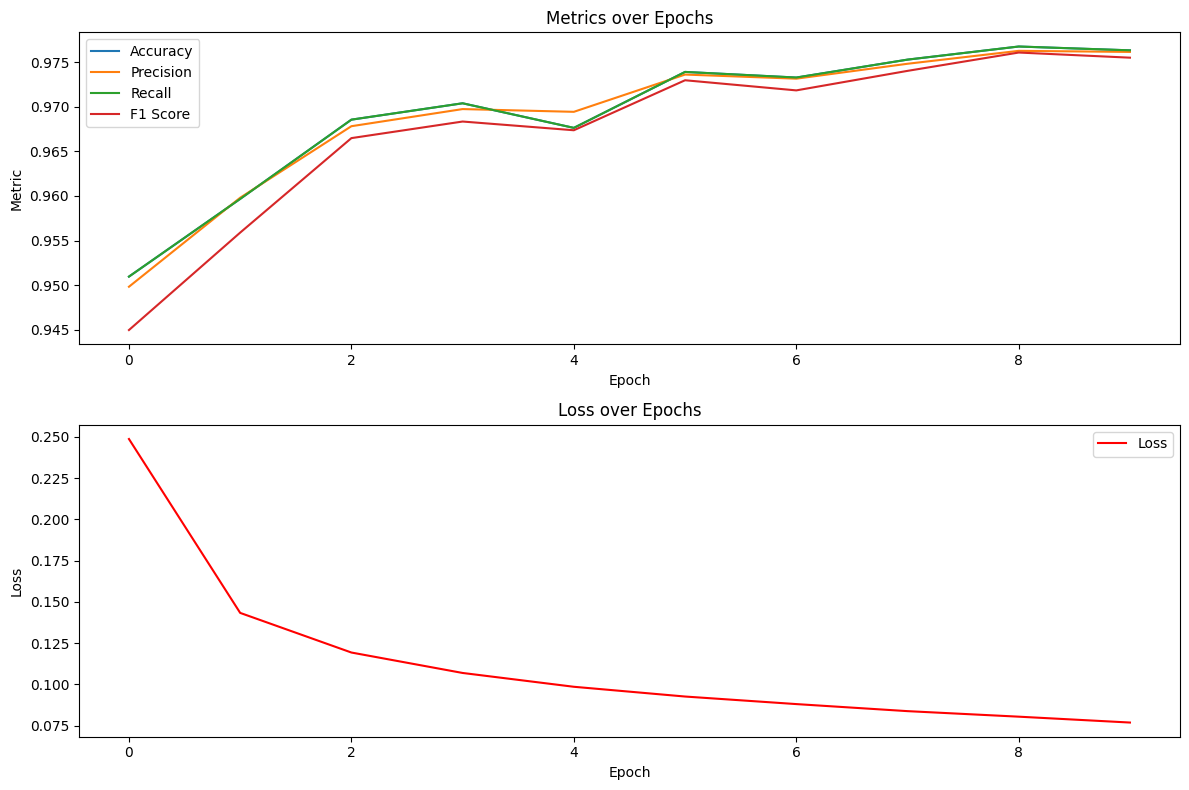

In [11]:
plot_metrics(epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses, "oscnn_metrics")

# OSCNN with Attention Experiment
### Description
Use Stratified K-Fold Cross Validation to evaluate the OSCNN+Attention model.

In [12]:
epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses = [], [], [], [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset_y)):
    print(f"FOLD {fold}")
    print("--------------------------------")

    # store metrics of each fold
    accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

    # split data
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # data loaders for training and testing data in this fold
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # set parameters
    #input_dim = 1         # ECG data is univariate, so the input dimension is 1
    #hidden_dim = 128
    #num_layers = 2
    num_classes = 5

    # initialize model for this fold
    model = AttentionOSCNN(num_classes)
    model.to(device)
    print(model)

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # train
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # store metrics
        accuracy, precision, recall, f1, _, _ = evaluate(model, test_loader)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Accumulate metrics for each epoch across folds
        if fold == 0:
            # Initialize lists in the first fold
            epoch_acc.append(accuracy)
            epoch_prc.append(precision)
            epoch_rec.append(recall)
            epoch_f1.append(f1)
            epoch_losses.append(batch_losses)
        else:
            # Add to existing totals for subsequent folds
            epoch_acc[epoch] += accuracy
            epoch_prc[epoch] += precision
            epoch_rec[epoch] += recall
            epoch_f1[epoch] += f1
            epoch_losses[epoch].extend(batch_losses)

# Average metrics across all folds for each epoch
epoch_acc = [x / k_folds for x in epoch_acc]
epoch_prc = [x / k_folds for x in epoch_prc]
epoch_rec = [x / k_folds for x in epoch_rec]
epoch_f1 = [x / k_folds for x in epoch_f1]
epoch_losses = [sum(x) / len(x) for x in epoch_losses]

# Print average metrics for each epoch
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} - Avg Accuracy: {epoch_acc[epoch]}, Avg Precision: {epoch_prc[epoch]}, Avg Recall: {epoch_rec[epoch]}, Avg F1 Score: {epoch_f1[epoch]}, Avg Loss: {epoch_losses[epoch]}")

FOLD 0
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:01:45,670 - root - INFO - Accuracy: 95.68%
2023-12-09 00:01:45,670 - root - INFO - Precision: 0.9485
2023-12-09 00:01:45,671 - root - INFO - Recall: 0.9568
2023-12-09 00:01:45,672 - root - INFO - F1 Score: 0.9511


Epoch [2/10], Step [100/3079], Loss: 0.0569
Epoch [2/10], Step [200/3079], Loss: 0.1950
Epoch [2/10], Step [300/3079], Loss: 0.2922
Epoch [2/10], Step [400/3079], Loss: 0.2795
Epoch [2/10], Step [500/3079], Loss: 0.0998
Epoch [2/10], Step [600/3079], Loss: 0.1697
Epoch [2/10], Step [700/3079], Loss: 0.2528
Epoch [2/10], Step [800/3079], Loss: 0.0623
Epoch [2/10], Step [900/3079], Loss: 0.2692
Epoch [2/10], Step [1000/3079], Loss: 0.0776
Epoch [2/10], Step [1100/3079], Loss: 0.2240
Epoch [2/10], Step [1200/3079], Loss: 0.2232
Epoch [2/10], Step [1300/3079], Loss: 0.1176
Epoch [2/10], Step [1400/3079], Loss: 0.2716
Epoch [2/10], Step [1500/3079], Loss: 0.2188
Epoch [2/10], Step [1600/3079], Loss: 0.1826
Epoch [2/10], Step [1700/3079], Loss: 0.0406
Epoch [2/10], Step [1800/3079], Loss: 0.1349
Epoch [2/10], Step [1900/3079], Loss: 0.2905
Epoch [2/10], Step [2000/3079], Loss: 0.0732
Epoch [2/10], Step [2100/3079], Loss: 0.1574
Epoch [2/10], Step [2200/3079], Loss: 0.0397
Epoch [2/10], Step 

2023-12-09 00:02:01,644 - root - INFO - Accuracy: 95.46%
2023-12-09 00:02:01,645 - root - INFO - Precision: 0.9575
2023-12-09 00:02:01,645 - root - INFO - Recall: 0.9546
2023-12-09 00:02:01,646 - root - INFO - F1 Score: 0.9546


Epoch [3/10], Step [100/3079], Loss: 0.3784
Epoch [3/10], Step [200/3079], Loss: 0.0325
Epoch [3/10], Step [300/3079], Loss: 0.3652
Epoch [3/10], Step [400/3079], Loss: 0.0563
Epoch [3/10], Step [500/3079], Loss: 0.0346
Epoch [3/10], Step [600/3079], Loss: 0.0237
Epoch [3/10], Step [700/3079], Loss: 0.1026
Epoch [3/10], Step [800/3079], Loss: 0.0274
Epoch [3/10], Step [900/3079], Loss: 0.0367
Epoch [3/10], Step [1000/3079], Loss: 0.1395
Epoch [3/10], Step [1100/3079], Loss: 0.1045
Epoch [3/10], Step [1200/3079], Loss: 0.2161
Epoch [3/10], Step [1300/3079], Loss: 0.0617
Epoch [3/10], Step [1400/3079], Loss: 0.1221
Epoch [3/10], Step [1500/3079], Loss: 0.1355
Epoch [3/10], Step [1600/3079], Loss: 0.2200
Epoch [3/10], Step [1700/3079], Loss: 0.0963
Epoch [3/10], Step [1800/3079], Loss: 0.0618
Epoch [3/10], Step [1900/3079], Loss: 0.1070
Epoch [3/10], Step [2000/3079], Loss: 0.0859
Epoch [3/10], Step [2100/3079], Loss: 0.0897
Epoch [3/10], Step [2200/3079], Loss: 0.0805
Epoch [3/10], Step 

2023-12-09 00:02:17,243 - root - INFO - Accuracy: 96.87%
2023-12-09 00:02:17,244 - root - INFO - Precision: 0.9683
2023-12-09 00:02:17,245 - root - INFO - Recall: 0.9687
2023-12-09 00:02:17,245 - root - INFO - F1 Score: 0.9657


Epoch [4/10], Step [100/3079], Loss: 0.1258
Epoch [4/10], Step [200/3079], Loss: 0.0848
Epoch [4/10], Step [300/3079], Loss: 0.0295
Epoch [4/10], Step [400/3079], Loss: 0.0641
Epoch [4/10], Step [500/3079], Loss: 0.0141
Epoch [4/10], Step [600/3079], Loss: 0.0420
Epoch [4/10], Step [700/3079], Loss: 0.1450
Epoch [4/10], Step [800/3079], Loss: 0.1098
Epoch [4/10], Step [900/3079], Loss: 0.1685
Epoch [4/10], Step [1000/3079], Loss: 0.3422
Epoch [4/10], Step [1100/3079], Loss: 0.0098
Epoch [4/10], Step [1200/3079], Loss: 0.0405
Epoch [4/10], Step [1300/3079], Loss: 0.1834
Epoch [4/10], Step [1400/3079], Loss: 0.1007
Epoch [4/10], Step [1500/3079], Loss: 0.1686
Epoch [4/10], Step [1600/3079], Loss: 0.0289
Epoch [4/10], Step [1700/3079], Loss: 0.0443
Epoch [4/10], Step [1800/3079], Loss: 0.0394
Epoch [4/10], Step [1900/3079], Loss: 0.0490
Epoch [4/10], Step [2000/3079], Loss: 0.0975
Epoch [4/10], Step [2100/3079], Loss: 0.0471
Epoch [4/10], Step [2200/3079], Loss: 0.1712
Epoch [4/10], Step 

2023-12-09 00:02:32,751 - root - INFO - Accuracy: 97.46%
2023-12-09 00:02:32,752 - root - INFO - Precision: 0.9745
2023-12-09 00:02:32,753 - root - INFO - Recall: 0.9746
2023-12-09 00:02:32,754 - root - INFO - F1 Score: 0.9735


Epoch [5/10], Step [100/3079], Loss: 0.0881
Epoch [5/10], Step [200/3079], Loss: 0.0757
Epoch [5/10], Step [300/3079], Loss: 0.0437
Epoch [5/10], Step [400/3079], Loss: 0.0292
Epoch [5/10], Step [500/3079], Loss: 0.1306
Epoch [5/10], Step [600/3079], Loss: 0.1408
Epoch [5/10], Step [700/3079], Loss: 0.0205
Epoch [5/10], Step [800/3079], Loss: 0.2628
Epoch [5/10], Step [900/3079], Loss: 0.0448
Epoch [5/10], Step [1000/3079], Loss: 0.1824
Epoch [5/10], Step [1100/3079], Loss: 0.0106
Epoch [5/10], Step [1200/3079], Loss: 0.1797
Epoch [5/10], Step [1300/3079], Loss: 0.0195
Epoch [5/10], Step [1400/3079], Loss: 0.2310
Epoch [5/10], Step [1500/3079], Loss: 0.0452
Epoch [5/10], Step [1600/3079], Loss: 0.1381
Epoch [5/10], Step [1700/3079], Loss: 0.0900
Epoch [5/10], Step [1800/3079], Loss: 0.0322
Epoch [5/10], Step [1900/3079], Loss: 0.0317
Epoch [5/10], Step [2000/3079], Loss: 0.0477
Epoch [5/10], Step [2100/3079], Loss: 0.0205
Epoch [5/10], Step [2200/3079], Loss: 0.2713
Epoch [5/10], Step 

2023-12-09 00:02:48,396 - root - INFO - Accuracy: 96.14%
2023-12-09 00:02:48,398 - root - INFO - Precision: 0.9640
2023-12-09 00:02:48,399 - root - INFO - Recall: 0.9614
2023-12-09 00:02:48,400 - root - INFO - F1 Score: 0.9618


Epoch [6/10], Step [100/3079], Loss: 0.1242
Epoch [6/10], Step [200/3079], Loss: 0.2241
Epoch [6/10], Step [300/3079], Loss: 0.1004
Epoch [6/10], Step [400/3079], Loss: 0.1317
Epoch [6/10], Step [500/3079], Loss: 0.3439
Epoch [6/10], Step [600/3079], Loss: 0.0538
Epoch [6/10], Step [700/3079], Loss: 0.0180
Epoch [6/10], Step [800/3079], Loss: 0.1459
Epoch [6/10], Step [900/3079], Loss: 0.1209
Epoch [6/10], Step [1000/3079], Loss: 0.1553
Epoch [6/10], Step [1100/3079], Loss: 0.0712
Epoch [6/10], Step [1200/3079], Loss: 0.0265
Epoch [6/10], Step [1300/3079], Loss: 0.0167
Epoch [6/10], Step [1400/3079], Loss: 0.1216
Epoch [6/10], Step [1500/3079], Loss: 0.0176
Epoch [6/10], Step [1600/3079], Loss: 0.2586
Epoch [6/10], Step [1700/3079], Loss: 0.2067
Epoch [6/10], Step [1800/3079], Loss: 0.0424
Epoch [6/10], Step [1900/3079], Loss: 0.1413
Epoch [6/10], Step [2000/3079], Loss: 0.0225
Epoch [6/10], Step [2100/3079], Loss: 0.0335
Epoch [6/10], Step [2200/3079], Loss: 0.0200
Epoch [6/10], Step 

2023-12-09 00:03:03,900 - root - INFO - Accuracy: 97.26%
2023-12-09 00:03:03,901 - root - INFO - Precision: 0.9731
2023-12-09 00:03:03,903 - root - INFO - Recall: 0.9726
2023-12-09 00:03:03,903 - root - INFO - F1 Score: 0.9728


Epoch [7/10], Step [100/3079], Loss: 0.0175
Epoch [7/10], Step [200/3079], Loss: 0.1784
Epoch [7/10], Step [300/3079], Loss: 0.0110
Epoch [7/10], Step [400/3079], Loss: 0.1231
Epoch [7/10], Step [500/3079], Loss: 0.1090
Epoch [7/10], Step [600/3079], Loss: 0.0171
Epoch [7/10], Step [700/3079], Loss: 0.2582
Epoch [7/10], Step [800/3079], Loss: 0.0707
Epoch [7/10], Step [900/3079], Loss: 0.1910
Epoch [7/10], Step [1000/3079], Loss: 0.0751
Epoch [7/10], Step [1100/3079], Loss: 0.0050
Epoch [7/10], Step [1200/3079], Loss: 0.0351
Epoch [7/10], Step [1300/3079], Loss: 0.0133
Epoch [7/10], Step [1400/3079], Loss: 0.0477
Epoch [7/10], Step [1500/3079], Loss: 0.0548
Epoch [7/10], Step [1600/3079], Loss: 0.1836
Epoch [7/10], Step [1700/3079], Loss: 0.0177
Epoch [7/10], Step [1800/3079], Loss: 0.0149
Epoch [7/10], Step [1900/3079], Loss: 0.3017
Epoch [7/10], Step [2000/3079], Loss: 0.0577
Epoch [7/10], Step [2100/3079], Loss: 0.0465
Epoch [7/10], Step [2200/3079], Loss: 0.2238
Epoch [7/10], Step 

2023-12-09 00:03:19,535 - root - INFO - Accuracy: 97.56%
2023-12-09 00:03:19,536 - root - INFO - Precision: 0.9751
2023-12-09 00:03:19,537 - root - INFO - Recall: 0.9756
2023-12-09 00:03:19,538 - root - INFO - F1 Score: 0.9749


Epoch [8/10], Step [100/3079], Loss: 0.0235
Epoch [8/10], Step [200/3079], Loss: 0.1114
Epoch [8/10], Step [300/3079], Loss: 0.0130
Epoch [8/10], Step [400/3079], Loss: 0.0126
Epoch [8/10], Step [500/3079], Loss: 0.0194
Epoch [8/10], Step [600/3079], Loss: 0.2062
Epoch [8/10], Step [700/3079], Loss: 0.0458
Epoch [8/10], Step [800/3079], Loss: 0.0212
Epoch [8/10], Step [900/3079], Loss: 0.0484
Epoch [8/10], Step [1000/3079], Loss: 0.1532
Epoch [8/10], Step [1100/3079], Loss: 0.0265
Epoch [8/10], Step [1200/3079], Loss: 0.1877
Epoch [8/10], Step [1300/3079], Loss: 0.0122
Epoch [8/10], Step [1400/3079], Loss: 0.0411
Epoch [8/10], Step [1500/3079], Loss: 0.0610
Epoch [8/10], Step [1600/3079], Loss: 0.1703
Epoch [8/10], Step [1700/3079], Loss: 0.2171
Epoch [8/10], Step [1800/3079], Loss: 0.1190
Epoch [8/10], Step [1900/3079], Loss: 0.0371
Epoch [8/10], Step [2000/3079], Loss: 0.3159
Epoch [8/10], Step [2100/3079], Loss: 0.0492
Epoch [8/10], Step [2200/3079], Loss: 0.0876
Epoch [8/10], Step 

2023-12-09 00:03:35,243 - root - INFO - Accuracy: 97.83%
2023-12-09 00:03:35,244 - root - INFO - Precision: 0.9778
2023-12-09 00:03:35,245 - root - INFO - Recall: 0.9783
2023-12-09 00:03:35,246 - root - INFO - F1 Score: 0.9773


Epoch [9/10], Step [100/3079], Loss: 0.2416
Epoch [9/10], Step [200/3079], Loss: 0.0364
Epoch [9/10], Step [300/3079], Loss: 0.1220
Epoch [9/10], Step [400/3079], Loss: 0.0521
Epoch [9/10], Step [500/3079], Loss: 0.0456
Epoch [9/10], Step [600/3079], Loss: 0.1043
Epoch [9/10], Step [700/3079], Loss: 0.0269
Epoch [9/10], Step [800/3079], Loss: 0.2062
Epoch [9/10], Step [900/3079], Loss: 0.0465
Epoch [9/10], Step [1000/3079], Loss: 0.0445
Epoch [9/10], Step [1100/3079], Loss: 0.0593
Epoch [9/10], Step [1200/3079], Loss: 0.0398
Epoch [9/10], Step [1300/3079], Loss: 0.0307
Epoch [9/10], Step [1400/3079], Loss: 0.0153
Epoch [9/10], Step [1500/3079], Loss: 0.0108
Epoch [9/10], Step [1600/3079], Loss: 0.0107
Epoch [9/10], Step [1700/3079], Loss: 0.0108
Epoch [9/10], Step [1800/3079], Loss: 0.3262
Epoch [9/10], Step [1900/3079], Loss: 0.0415
Epoch [9/10], Step [2000/3079], Loss: 0.0362
Epoch [9/10], Step [2100/3079], Loss: 0.0237
Epoch [9/10], Step [2200/3079], Loss: 0.0079
Epoch [9/10], Step 

2023-12-09 00:03:50,810 - root - INFO - Accuracy: 97.85%
2023-12-09 00:03:50,811 - root - INFO - Precision: 0.9782
2023-12-09 00:03:50,812 - root - INFO - Recall: 0.9785
2023-12-09 00:03:50,813 - root - INFO - F1 Score: 0.9783


Epoch [10/10], Step [100/3079], Loss: 0.0362
Epoch [10/10], Step [200/3079], Loss: 0.0371
Epoch [10/10], Step [300/3079], Loss: 0.0130
Epoch [10/10], Step [400/3079], Loss: 0.0303
Epoch [10/10], Step [500/3079], Loss: 0.0199
Epoch [10/10], Step [600/3079], Loss: 0.0812
Epoch [10/10], Step [700/3079], Loss: 0.0363
Epoch [10/10], Step [800/3079], Loss: 0.1031
Epoch [10/10], Step [900/3079], Loss: 0.0983
Epoch [10/10], Step [1000/3079], Loss: 0.0333
Epoch [10/10], Step [1100/3079], Loss: 0.0212
Epoch [10/10], Step [1200/3079], Loss: 0.0149
Epoch [10/10], Step [1300/3079], Loss: 0.1460
Epoch [10/10], Step [1400/3079], Loss: 0.0387
Epoch [10/10], Step [1500/3079], Loss: 0.0806
Epoch [10/10], Step [1600/3079], Loss: 0.0201
Epoch [10/10], Step [1700/3079], Loss: 0.0825
Epoch [10/10], Step [1800/3079], Loss: 0.0365
Epoch [10/10], Step [1900/3079], Loss: 0.0922
Epoch [10/10], Step [2000/3079], Loss: 0.1040
Epoch [10/10], Step [2100/3079], Loss: 0.0169
Epoch [10/10], Step [2200/3079], Loss: 0.00

2023-12-09 00:04:06,350 - root - INFO - Accuracy: 97.75%
2023-12-09 00:04:06,351 - root - INFO - Precision: 0.9773
2023-12-09 00:04:06,352 - root - INFO - Recall: 0.9775
2023-12-09 00:04:06,353 - root - INFO - F1 Score: 0.9758


FOLD 1
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

2023-12-09 00:04:22,091 - root - INFO - Accuracy: 96.39%
2023-12-09 00:04:22,092 - root - INFO - Precision: 0.9628
2023-12-09 00:04:22,093 - root - INFO - Recall: 0.9639
2023-12-09 00:04:22,095 - root - INFO - F1 Score: 0.9605


Epoch [2/10], Step [100/3079], Loss: 0.1266
Epoch [2/10], Step [200/3079], Loss: 0.0697
Epoch [2/10], Step [300/3079], Loss: 0.3399
Epoch [2/10], Step [400/3079], Loss: 0.2672
Epoch [2/10], Step [500/3079], Loss: 0.0905
Epoch [2/10], Step [600/3079], Loss: 0.3465
Epoch [2/10], Step [700/3079], Loss: 0.1619
Epoch [2/10], Step [800/3079], Loss: 0.0401
Epoch [2/10], Step [900/3079], Loss: 0.0419
Epoch [2/10], Step [1000/3079], Loss: 0.2315
Epoch [2/10], Step [1100/3079], Loss: 0.0249
Epoch [2/10], Step [1200/3079], Loss: 0.2491
Epoch [2/10], Step [1300/3079], Loss: 0.1766
Epoch [2/10], Step [1400/3079], Loss: 0.0653
Epoch [2/10], Step [1500/3079], Loss: 0.0710
Epoch [2/10], Step [1600/3079], Loss: 0.0506
Epoch [2/10], Step [1700/3079], Loss: 0.0922
Epoch [2/10], Step [1800/3079], Loss: 0.2592
Epoch [2/10], Step [1900/3079], Loss: 0.0877
Epoch [2/10], Step [2000/3079], Loss: 0.1419
Epoch [2/10], Step [2100/3079], Loss: 0.0154
Epoch [2/10], Step [2200/3079], Loss: 0.0157
Epoch [2/10], Step 

2023-12-09 00:04:37,895 - root - INFO - Accuracy: 96.35%
2023-12-09 00:04:37,896 - root - INFO - Precision: 0.9630
2023-12-09 00:04:37,897 - root - INFO - Recall: 0.9635
2023-12-09 00:04:37,898 - root - INFO - F1 Score: 0.9624


Epoch [3/10], Step [100/3079], Loss: 0.0289
Epoch [3/10], Step [200/3079], Loss: 0.0723
Epoch [3/10], Step [300/3079], Loss: 0.2183
Epoch [3/10], Step [400/3079], Loss: 0.0335
Epoch [3/10], Step [500/3079], Loss: 0.0247
Epoch [3/10], Step [600/3079], Loss: 0.1397
Epoch [3/10], Step [700/3079], Loss: 0.1269
Epoch [3/10], Step [800/3079], Loss: 0.4536
Epoch [3/10], Step [900/3079], Loss: 0.0936
Epoch [3/10], Step [1000/3079], Loss: 0.0914
Epoch [3/10], Step [1100/3079], Loss: 0.0797
Epoch [3/10], Step [1200/3079], Loss: 0.1107
Epoch [3/10], Step [1300/3079], Loss: 0.0914
Epoch [3/10], Step [1400/3079], Loss: 0.0244
Epoch [3/10], Step [1500/3079], Loss: 0.1105
Epoch [3/10], Step [1600/3079], Loss: 0.2337
Epoch [3/10], Step [1700/3079], Loss: 0.0259
Epoch [3/10], Step [1800/3079], Loss: 0.1604
Epoch [3/10], Step [1900/3079], Loss: 0.1833
Epoch [3/10], Step [2000/3079], Loss: 0.0476
Epoch [3/10], Step [2100/3079], Loss: 0.0444
Epoch [3/10], Step [2200/3079], Loss: 0.1087
Epoch [3/10], Step 

2023-12-09 00:04:53,650 - root - INFO - Accuracy: 97.20%
2023-12-09 00:04:53,651 - root - INFO - Precision: 0.9711
2023-12-09 00:04:53,652 - root - INFO - Recall: 0.9720
2023-12-09 00:04:53,653 - root - INFO - F1 Score: 0.9706


Epoch [4/10], Step [100/3079], Loss: 0.0285
Epoch [4/10], Step [200/3079], Loss: 0.0857
Epoch [4/10], Step [300/3079], Loss: 0.2247
Epoch [4/10], Step [400/3079], Loss: 0.1505
Epoch [4/10], Step [500/3079], Loss: 0.0408
Epoch [4/10], Step [600/3079], Loss: 0.3611
Epoch [4/10], Step [700/3079], Loss: 0.0128
Epoch [4/10], Step [800/3079], Loss: 0.0174
Epoch [4/10], Step [900/3079], Loss: 0.0382
Epoch [4/10], Step [1000/3079], Loss: 0.0156
Epoch [4/10], Step [1100/3079], Loss: 0.0358
Epoch [4/10], Step [1200/3079], Loss: 0.1104
Epoch [4/10], Step [1300/3079], Loss: 0.0159
Epoch [4/10], Step [1400/3079], Loss: 0.0780
Epoch [4/10], Step [1500/3079], Loss: 0.0835
Epoch [4/10], Step [1600/3079], Loss: 0.1247
Epoch [4/10], Step [1700/3079], Loss: 0.2447
Epoch [4/10], Step [1800/3079], Loss: 0.0718
Epoch [4/10], Step [1900/3079], Loss: 0.1389
Epoch [4/10], Step [2000/3079], Loss: 0.1556
Epoch [4/10], Step [2100/3079], Loss: 0.0272
Epoch [4/10], Step [2200/3079], Loss: 0.0271
Epoch [4/10], Step 

2023-12-09 00:05:09,255 - root - INFO - Accuracy: 97.02%
2023-12-09 00:05:09,256 - root - INFO - Precision: 0.9691
2023-12-09 00:05:09,257 - root - INFO - Recall: 0.9702
2023-12-09 00:05:09,257 - root - INFO - F1 Score: 0.9680


Epoch [5/10], Step [100/3079], Loss: 0.2113
Epoch [5/10], Step [200/3079], Loss: 0.0127
Epoch [5/10], Step [300/3079], Loss: 0.0464
Epoch [5/10], Step [400/3079], Loss: 0.0203
Epoch [5/10], Step [500/3079], Loss: 0.3086
Epoch [5/10], Step [600/3079], Loss: 0.1576
Epoch [5/10], Step [700/3079], Loss: 0.0742
Epoch [5/10], Step [800/3079], Loss: 0.0328
Epoch [5/10], Step [900/3079], Loss: 0.0371
Epoch [5/10], Step [1000/3079], Loss: 0.0925
Epoch [5/10], Step [1100/3079], Loss: 0.0252
Epoch [5/10], Step [1200/3079], Loss: 0.0688
Epoch [5/10], Step [1300/3079], Loss: 0.0130
Epoch [5/10], Step [1400/3079], Loss: 0.3305
Epoch [5/10], Step [1500/3079], Loss: 0.1598
Epoch [5/10], Step [1600/3079], Loss: 0.2213
Epoch [5/10], Step [1700/3079], Loss: 0.0324
Epoch [5/10], Step [1800/3079], Loss: 0.0184
Epoch [5/10], Step [1900/3079], Loss: 0.2440
Epoch [5/10], Step [2000/3079], Loss: 0.0575
Epoch [5/10], Step [2100/3079], Loss: 0.0073
Epoch [5/10], Step [2200/3079], Loss: 0.0092
Epoch [5/10], Step 

2023-12-09 00:05:24,832 - root - INFO - Accuracy: 97.24%
2023-12-09 00:05:24,833 - root - INFO - Precision: 0.9717
2023-12-09 00:05:24,834 - root - INFO - Recall: 0.9724
2023-12-09 00:05:24,835 - root - INFO - F1 Score: 0.9709


Epoch [6/10], Step [100/3079], Loss: 0.0137
Epoch [6/10], Step [200/3079], Loss: 0.0770
Epoch [6/10], Step [300/3079], Loss: 0.1214
Epoch [6/10], Step [400/3079], Loss: 0.0511
Epoch [6/10], Step [500/3079], Loss: 0.0426
Epoch [6/10], Step [600/3079], Loss: 0.0287
Epoch [6/10], Step [700/3079], Loss: 0.1470
Epoch [6/10], Step [800/3079], Loss: 0.0108
Epoch [6/10], Step [900/3079], Loss: 0.0127
Epoch [6/10], Step [1000/3079], Loss: 0.0315
Epoch [6/10], Step [1100/3079], Loss: 0.1191
Epoch [6/10], Step [1200/3079], Loss: 0.0316
Epoch [6/10], Step [1300/3079], Loss: 0.0320
Epoch [6/10], Step [1400/3079], Loss: 0.1338
Epoch [6/10], Step [1500/3079], Loss: 0.0320
Epoch [6/10], Step [1600/3079], Loss: 0.3109
Epoch [6/10], Step [1700/3079], Loss: 0.0335
Epoch [6/10], Step [1800/3079], Loss: 0.0139
Epoch [6/10], Step [1900/3079], Loss: 0.1209
Epoch [6/10], Step [2000/3079], Loss: 0.1239
Epoch [6/10], Step [2100/3079], Loss: 0.0200
Epoch [6/10], Step [2200/3079], Loss: 0.0216
Epoch [6/10], Step 

2023-12-09 00:05:40,317 - root - INFO - Accuracy: 97.63%
2023-12-09 00:05:40,318 - root - INFO - Precision: 0.9756
2023-12-09 00:05:40,319 - root - INFO - Recall: 0.9763
2023-12-09 00:05:40,320 - root - INFO - F1 Score: 0.9752


Epoch [7/10], Step [100/3079], Loss: 0.0223
Epoch [7/10], Step [200/3079], Loss: 0.0172
Epoch [7/10], Step [300/3079], Loss: 0.0662
Epoch [7/10], Step [400/3079], Loss: 0.2423
Epoch [7/10], Step [500/3079], Loss: 0.0456
Epoch [7/10], Step [600/3079], Loss: 0.3259
Epoch [7/10], Step [700/3079], Loss: 0.0740
Epoch [7/10], Step [800/3079], Loss: 0.0711
Epoch [7/10], Step [900/3079], Loss: 0.3312
Epoch [7/10], Step [1000/3079], Loss: 0.0081
Epoch [7/10], Step [1100/3079], Loss: 0.1816
Epoch [7/10], Step [1200/3079], Loss: 0.0071
Epoch [7/10], Step [1300/3079], Loss: 0.1780
Epoch [7/10], Step [1400/3079], Loss: 0.0243
Epoch [7/10], Step [1500/3079], Loss: 0.1758
Epoch [7/10], Step [1600/3079], Loss: 0.0515
Epoch [7/10], Step [1700/3079], Loss: 0.1743
Epoch [7/10], Step [1800/3079], Loss: 0.0931
Epoch [7/10], Step [1900/3079], Loss: 0.2686
Epoch [7/10], Step [2000/3079], Loss: 0.0916
Epoch [7/10], Step [2100/3079], Loss: 0.1180
Epoch [7/10], Step [2200/3079], Loss: 0.0257
Epoch [7/10], Step 

2023-12-09 00:05:55,928 - root - INFO - Accuracy: 97.60%
2023-12-09 00:05:55,929 - root - INFO - Precision: 0.9752
2023-12-09 00:05:55,930 - root - INFO - Recall: 0.9760
2023-12-09 00:05:55,931 - root - INFO - F1 Score: 0.9750


Epoch [8/10], Step [100/3079], Loss: 0.0533
Epoch [8/10], Step [200/3079], Loss: 0.1622
Epoch [8/10], Step [300/3079], Loss: 0.0225
Epoch [8/10], Step [400/3079], Loss: 0.0084
Epoch [8/10], Step [500/3079], Loss: 0.0115
Epoch [8/10], Step [600/3079], Loss: 0.1201
Epoch [8/10], Step [700/3079], Loss: 0.0673
Epoch [8/10], Step [800/3079], Loss: 0.0154
Epoch [8/10], Step [900/3079], Loss: 0.0370
Epoch [8/10], Step [1000/3079], Loss: 0.0475
Epoch [8/10], Step [1100/3079], Loss: 0.2118
Epoch [8/10], Step [1200/3079], Loss: 0.1387
Epoch [8/10], Step [1300/3079], Loss: 0.0481
Epoch [8/10], Step [1400/3079], Loss: 0.0228
Epoch [8/10], Step [1500/3079], Loss: 0.0053
Epoch [8/10], Step [1600/3079], Loss: 0.0107
Epoch [8/10], Step [1700/3079], Loss: 0.0526
Epoch [8/10], Step [1800/3079], Loss: 0.1248
Epoch [8/10], Step [1900/3079], Loss: 0.1732
Epoch [8/10], Step [2000/3079], Loss: 0.1755
Epoch [8/10], Step [2100/3079], Loss: 0.0238
Epoch [8/10], Step [2200/3079], Loss: 0.0266
Epoch [8/10], Step 

2023-12-09 00:06:11,400 - root - INFO - Accuracy: 97.83%
2023-12-09 00:06:11,401 - root - INFO - Precision: 0.9780
2023-12-09 00:06:11,402 - root - INFO - Recall: 0.9783
2023-12-09 00:06:11,403 - root - INFO - F1 Score: 0.9772


Epoch [9/10], Step [100/3079], Loss: 0.1461
Epoch [9/10], Step [200/3079], Loss: 0.0170
Epoch [9/10], Step [300/3079], Loss: 0.0380
Epoch [9/10], Step [400/3079], Loss: 0.0889
Epoch [9/10], Step [500/3079], Loss: 0.0067
Epoch [9/10], Step [600/3079], Loss: 0.1870
Epoch [9/10], Step [700/3079], Loss: 0.0093
Epoch [9/10], Step [800/3079], Loss: 0.0330
Epoch [9/10], Step [900/3079], Loss: 0.2069
Epoch [9/10], Step [1000/3079], Loss: 0.0849
Epoch [9/10], Step [1100/3079], Loss: 0.0425
Epoch [9/10], Step [1200/3079], Loss: 0.2983
Epoch [9/10], Step [1300/3079], Loss: 0.2982
Epoch [9/10], Step [1400/3079], Loss: 0.0877
Epoch [9/10], Step [1500/3079], Loss: 0.0482
Epoch [9/10], Step [1600/3079], Loss: 0.0197
Epoch [9/10], Step [1700/3079], Loss: 0.0463
Epoch [9/10], Step [1800/3079], Loss: 0.0299
Epoch [9/10], Step [1900/3079], Loss: 0.0204
Epoch [9/10], Step [2000/3079], Loss: 0.0592
Epoch [9/10], Step [2100/3079], Loss: 0.0984
Epoch [9/10], Step [2200/3079], Loss: 0.2430
Epoch [9/10], Step 

2023-12-09 00:06:26,937 - root - INFO - Accuracy: 97.88%
2023-12-09 00:06:26,938 - root - INFO - Precision: 0.9781
2023-12-09 00:06:26,939 - root - INFO - Recall: 0.9788
2023-12-09 00:06:26,940 - root - INFO - F1 Score: 0.9779


Epoch [10/10], Step [100/3079], Loss: 0.1948
Epoch [10/10], Step [200/3079], Loss: 0.1104
Epoch [10/10], Step [300/3079], Loss: 0.0132
Epoch [10/10], Step [400/3079], Loss: 0.0077
Epoch [10/10], Step [500/3079], Loss: 0.0375
Epoch [10/10], Step [600/3079], Loss: 0.1596
Epoch [10/10], Step [700/3079], Loss: 0.1422
Epoch [10/10], Step [800/3079], Loss: 0.0296
Epoch [10/10], Step [900/3079], Loss: 0.0142
Epoch [10/10], Step [1000/3079], Loss: 0.3884
Epoch [10/10], Step [1100/3079], Loss: 0.2899
Epoch [10/10], Step [1200/3079], Loss: 0.1954
Epoch [10/10], Step [1300/3079], Loss: 0.0073
Epoch [10/10], Step [1400/3079], Loss: 0.0105
Epoch [10/10], Step [1500/3079], Loss: 0.1109
Epoch [10/10], Step [1600/3079], Loss: 0.0188
Epoch [10/10], Step [1700/3079], Loss: 0.0507
Epoch [10/10], Step [1800/3079], Loss: 0.0156
Epoch [10/10], Step [1900/3079], Loss: 0.0217
Epoch [10/10], Step [2000/3079], Loss: 0.0547
Epoch [10/10], Step [2100/3079], Loss: 0.0106
Epoch [10/10], Step [2200/3079], Loss: 0.37

2023-12-09 00:06:42,176 - root - INFO - Accuracy: 97.93%
2023-12-09 00:06:42,177 - root - INFO - Precision: 0.9789
2023-12-09 00:06:42,179 - root - INFO - Recall: 0.9793
2023-12-09 00:06:42,180 - root - INFO - F1 Score: 0.9783


FOLD 2
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:06:57,677 - root - INFO - Accuracy: 95.26%
2023-12-09 00:06:57,678 - root - INFO - Precision: 0.9454
2023-12-09 00:06:57,680 - root - INFO - Recall: 0.9526
2023-12-09 00:06:57,681 - root - INFO - F1 Score: 0.9477


Epoch [2/10], Step [100/3079], Loss: 0.0875
Epoch [2/10], Step [200/3079], Loss: 0.2400
Epoch [2/10], Step [300/3079], Loss: 0.1584
Epoch [2/10], Step [400/3079], Loss: 0.0645
Epoch [2/10], Step [500/3079], Loss: 0.0714
Epoch [2/10], Step [600/3079], Loss: 0.1193
Epoch [2/10], Step [700/3079], Loss: 0.1213
Epoch [2/10], Step [800/3079], Loss: 0.0600
Epoch [2/10], Step [900/3079], Loss: 0.1042
Epoch [2/10], Step [1000/3079], Loss: 0.1761
Epoch [2/10], Step [1100/3079], Loss: 0.2573
Epoch [2/10], Step [1200/3079], Loss: 0.2970
Epoch [2/10], Step [1300/3079], Loss: 0.0549
Epoch [2/10], Step [1400/3079], Loss: 0.0357
Epoch [2/10], Step [1500/3079], Loss: 0.3215
Epoch [2/10], Step [1600/3079], Loss: 0.0764
Epoch [2/10], Step [1700/3079], Loss: 0.0701
Epoch [2/10], Step [1800/3079], Loss: 0.0760
Epoch [2/10], Step [1900/3079], Loss: 0.2860
Epoch [2/10], Step [2000/3079], Loss: 0.0967
Epoch [2/10], Step [2100/3079], Loss: 0.1908
Epoch [2/10], Step [2200/3079], Loss: 0.0326
Epoch [2/10], Step 

2023-12-09 00:07:13,208 - root - INFO - Accuracy: 96.05%
2023-12-09 00:07:13,210 - root - INFO - Precision: 0.9606
2023-12-09 00:07:13,211 - root - INFO - Recall: 0.9605
2023-12-09 00:07:13,212 - root - INFO - F1 Score: 0.9542


Epoch [3/10], Step [100/3079], Loss: 0.1346
Epoch [3/10], Step [200/3079], Loss: 0.0666
Epoch [3/10], Step [300/3079], Loss: 0.0854
Epoch [3/10], Step [400/3079], Loss: 0.0802
Epoch [3/10], Step [500/3079], Loss: 0.1878
Epoch [3/10], Step [600/3079], Loss: 0.1504
Epoch [3/10], Step [700/3079], Loss: 0.1188
Epoch [3/10], Step [800/3079], Loss: 0.0910
Epoch [3/10], Step [900/3079], Loss: 0.0647
Epoch [3/10], Step [1000/3079], Loss: 0.1752
Epoch [3/10], Step [1100/3079], Loss: 0.1171
Epoch [3/10], Step [1200/3079], Loss: 0.0518
Epoch [3/10], Step [1300/3079], Loss: 0.0233
Epoch [3/10], Step [1400/3079], Loss: 0.1018
Epoch [3/10], Step [1500/3079], Loss: 0.1266
Epoch [3/10], Step [1600/3079], Loss: 0.4166
Epoch [3/10], Step [1700/3079], Loss: 0.1582
Epoch [3/10], Step [1800/3079], Loss: 0.0951
Epoch [3/10], Step [1900/3079], Loss: 0.0472
Epoch [3/10], Step [2000/3079], Loss: 0.1978
Epoch [3/10], Step [2100/3079], Loss: 0.1401
Epoch [3/10], Step [2200/3079], Loss: 0.0546
Epoch [3/10], Step 

2023-12-09 00:07:28,796 - root - INFO - Accuracy: 95.00%
2023-12-09 00:07:28,797 - root - INFO - Precision: 0.9495
2023-12-09 00:07:28,798 - root - INFO - Recall: 0.9500
2023-12-09 00:07:28,798 - root - INFO - F1 Score: 0.9397


Epoch [4/10], Step [100/3079], Loss: 0.2480
Epoch [4/10], Step [200/3079], Loss: 0.1244
Epoch [4/10], Step [300/3079], Loss: 0.1163
Epoch [4/10], Step [400/3079], Loss: 0.0316
Epoch [4/10], Step [500/3079], Loss: 0.1337
Epoch [4/10], Step [600/3079], Loss: 0.2002
Epoch [4/10], Step [700/3079], Loss: 0.3505
Epoch [4/10], Step [800/3079], Loss: 0.0379
Epoch [4/10], Step [900/3079], Loss: 0.1625
Epoch [4/10], Step [1000/3079], Loss: 0.0197
Epoch [4/10], Step [1100/3079], Loss: 0.0393
Epoch [4/10], Step [1200/3079], Loss: 0.0843
Epoch [4/10], Step [1300/3079], Loss: 0.2023
Epoch [4/10], Step [1400/3079], Loss: 0.0390
Epoch [4/10], Step [1500/3079], Loss: 0.0074
Epoch [4/10], Step [1600/3079], Loss: 0.1916
Epoch [4/10], Step [1700/3079], Loss: 0.2325
Epoch [4/10], Step [1800/3079], Loss: 0.0920
Epoch [4/10], Step [1900/3079], Loss: 0.0471
Epoch [4/10], Step [2000/3079], Loss: 0.0669
Epoch [4/10], Step [2100/3079], Loss: 0.2836
Epoch [4/10], Step [2200/3079], Loss: 0.0245
Epoch [4/10], Step 

2023-12-09 00:07:44,475 - root - INFO - Accuracy: 95.84%
2023-12-09 00:07:44,477 - root - INFO - Precision: 0.9600
2023-12-09 00:07:44,477 - root - INFO - Recall: 0.9584
2023-12-09 00:07:44,478 - root - INFO - F1 Score: 0.9581


Epoch [5/10], Step [100/3079], Loss: 0.1698
Epoch [5/10], Step [200/3079], Loss: 0.0287
Epoch [5/10], Step [300/3079], Loss: 0.1307
Epoch [5/10], Step [400/3079], Loss: 0.0339
Epoch [5/10], Step [500/3079], Loss: 0.2201
Epoch [5/10], Step [600/3079], Loss: 0.0813
Epoch [5/10], Step [700/3079], Loss: 0.0328
Epoch [5/10], Step [800/3079], Loss: 0.0177
Epoch [5/10], Step [900/3079], Loss: 0.1224
Epoch [5/10], Step [1000/3079], Loss: 0.1169
Epoch [5/10], Step [1100/3079], Loss: 0.1126
Epoch [5/10], Step [1200/3079], Loss: 0.0430
Epoch [5/10], Step [1300/3079], Loss: 0.1719
Epoch [5/10], Step [1400/3079], Loss: 0.0860
Epoch [5/10], Step [1500/3079], Loss: 0.1709
Epoch [5/10], Step [1600/3079], Loss: 0.0332
Epoch [5/10], Step [1700/3079], Loss: 0.0983
Epoch [5/10], Step [1800/3079], Loss: 0.0156
Epoch [5/10], Step [1900/3079], Loss: 0.2524
Epoch [5/10], Step [2000/3079], Loss: 0.0702
Epoch [5/10], Step [2100/3079], Loss: 0.0169
Epoch [5/10], Step [2200/3079], Loss: 0.0089
Epoch [5/10], Step 

2023-12-09 00:07:59,965 - root - INFO - Accuracy: 96.97%
2023-12-09 00:07:59,967 - root - INFO - Precision: 0.9690
2023-12-09 00:07:59,968 - root - INFO - Recall: 0.9697
2023-12-09 00:07:59,969 - root - INFO - F1 Score: 0.9675


Epoch [6/10], Step [100/3079], Loss: 0.0354
Epoch [6/10], Step [200/3079], Loss: 0.0260
Epoch [6/10], Step [300/3079], Loss: 0.1277
Epoch [6/10], Step [400/3079], Loss: 0.2073
Epoch [6/10], Step [500/3079], Loss: 0.0124
Epoch [6/10], Step [600/3079], Loss: 0.0800
Epoch [6/10], Step [700/3079], Loss: 0.0277
Epoch [6/10], Step [800/3079], Loss: 0.1127
Epoch [6/10], Step [900/3079], Loss: 0.0260
Epoch [6/10], Step [1000/3079], Loss: 0.0835
Epoch [6/10], Step [1100/3079], Loss: 0.0051
Epoch [6/10], Step [1200/3079], Loss: 0.0262
Epoch [6/10], Step [1300/3079], Loss: 0.1082
Epoch [6/10], Step [1400/3079], Loss: 0.0151
Epoch [6/10], Step [1500/3079], Loss: 0.0810
Epoch [6/10], Step [1600/3079], Loss: 0.0424
Epoch [6/10], Step [1700/3079], Loss: 0.1941
Epoch [6/10], Step [1800/3079], Loss: 0.0115
Epoch [6/10], Step [1900/3079], Loss: 0.0197
Epoch [6/10], Step [2000/3079], Loss: 0.0250
Epoch [6/10], Step [2100/3079], Loss: 0.0364
Epoch [6/10], Step [2200/3079], Loss: 0.0270
Epoch [6/10], Step 

2023-12-09 00:08:15,875 - root - INFO - Accuracy: 97.42%
2023-12-09 00:08:15,876 - root - INFO - Precision: 0.9736
2023-12-09 00:08:15,877 - root - INFO - Recall: 0.9742
2023-12-09 00:08:15,879 - root - INFO - F1 Score: 0.9722


Epoch [7/10], Step [100/3079], Loss: 0.1630
Epoch [7/10], Step [200/3079], Loss: 0.0300
Epoch [7/10], Step [300/3079], Loss: 0.0146
Epoch [7/10], Step [400/3079], Loss: 0.1664
Epoch [7/10], Step [500/3079], Loss: 0.0119
Epoch [7/10], Step [600/3079], Loss: 0.1427
Epoch [7/10], Step [700/3079], Loss: 0.0860
Epoch [7/10], Step [800/3079], Loss: 0.0247
Epoch [7/10], Step [900/3079], Loss: 0.1367
Epoch [7/10], Step [1000/3079], Loss: 0.0716
Epoch [7/10], Step [1100/3079], Loss: 0.0824
Epoch [7/10], Step [1200/3079], Loss: 0.0198
Epoch [7/10], Step [1300/3079], Loss: 0.0211
Epoch [7/10], Step [1400/3079], Loss: 0.0038
Epoch [7/10], Step [1500/3079], Loss: 0.1075
Epoch [7/10], Step [1600/3079], Loss: 0.0194
Epoch [7/10], Step [1700/3079], Loss: 0.0858
Epoch [7/10], Step [1800/3079], Loss: 0.1346
Epoch [7/10], Step [1900/3079], Loss: 0.0354
Epoch [7/10], Step [2000/3079], Loss: 0.0560
Epoch [7/10], Step [2100/3079], Loss: 0.0220
Epoch [7/10], Step [2200/3079], Loss: 0.3271
Epoch [7/10], Step 

2023-12-09 00:08:31,581 - root - INFO - Accuracy: 97.07%
2023-12-09 00:08:31,582 - root - INFO - Precision: 0.9699
2023-12-09 00:08:31,583 - root - INFO - Recall: 0.9707
2023-12-09 00:08:31,584 - root - INFO - F1 Score: 0.9697


Epoch [8/10], Step [100/3079], Loss: 0.0946
Epoch [8/10], Step [200/3079], Loss: 0.0197
Epoch [8/10], Step [300/3079], Loss: 0.0552
Epoch [8/10], Step [400/3079], Loss: 0.0464
Epoch [8/10], Step [500/3079], Loss: 0.0930
Epoch [8/10], Step [600/3079], Loss: 0.0255
Epoch [8/10], Step [700/3079], Loss: 0.0541
Epoch [8/10], Step [800/3079], Loss: 0.4337
Epoch [8/10], Step [900/3079], Loss: 0.0090
Epoch [8/10], Step [1000/3079], Loss: 0.1915
Epoch [8/10], Step [1100/3079], Loss: 0.1176
Epoch [8/10], Step [1200/3079], Loss: 0.0235
Epoch [8/10], Step [1300/3079], Loss: 0.0149
Epoch [8/10], Step [1400/3079], Loss: 0.0857
Epoch [8/10], Step [1500/3079], Loss: 0.0562
Epoch [8/10], Step [1600/3079], Loss: 0.0608
Epoch [8/10], Step [1700/3079], Loss: 0.0948
Epoch [8/10], Step [1800/3079], Loss: 0.1300
Epoch [8/10], Step [1900/3079], Loss: 0.0256
Epoch [8/10], Step [2000/3079], Loss: 0.0131
Epoch [8/10], Step [2100/3079], Loss: 0.0297
Epoch [8/10], Step [2200/3079], Loss: 0.0579
Epoch [8/10], Step 

2023-12-09 00:08:47,583 - root - INFO - Accuracy: 97.44%
2023-12-09 00:08:47,585 - root - INFO - Precision: 0.9735
2023-12-09 00:08:47,585 - root - INFO - Recall: 0.9744
2023-12-09 00:08:47,586 - root - INFO - F1 Score: 0.9733


Epoch [9/10], Step [100/3079], Loss: 0.0235
Epoch [9/10], Step [200/3079], Loss: 0.0741
Epoch [9/10], Step [300/3079], Loss: 0.0671
Epoch [9/10], Step [400/3079], Loss: 0.0296
Epoch [9/10], Step [500/3079], Loss: 0.0289
Epoch [9/10], Step [600/3079], Loss: 0.0299
Epoch [9/10], Step [700/3079], Loss: 0.1314
Epoch [9/10], Step [800/3079], Loss: 0.0312
Epoch [9/10], Step [900/3079], Loss: 0.0716
Epoch [9/10], Step [1000/3079], Loss: 0.0944
Epoch [9/10], Step [1100/3079], Loss: 0.0243
Epoch [9/10], Step [1200/3079], Loss: 0.0084
Epoch [9/10], Step [1300/3079], Loss: 0.0443
Epoch [9/10], Step [1400/3079], Loss: 0.0419
Epoch [9/10], Step [1500/3079], Loss: 0.0109
Epoch [9/10], Step [1600/3079], Loss: 0.0491
Epoch [9/10], Step [1700/3079], Loss: 0.2908
Epoch [9/10], Step [1800/3079], Loss: 0.1293
Epoch [9/10], Step [1900/3079], Loss: 0.0702
Epoch [9/10], Step [2000/3079], Loss: 0.0183
Epoch [9/10], Step [2100/3079], Loss: 0.0938
Epoch [9/10], Step [2200/3079], Loss: 0.0387
Epoch [9/10], Step 

2023-12-09 00:09:03,408 - root - INFO - Accuracy: 97.60%
2023-12-09 00:09:03,409 - root - INFO - Precision: 0.9753
2023-12-09 00:09:03,410 - root - INFO - Recall: 0.9760
2023-12-09 00:09:03,410 - root - INFO - F1 Score: 0.9743


Epoch [10/10], Step [100/3079], Loss: 0.1828
Epoch [10/10], Step [200/3079], Loss: 0.1535
Epoch [10/10], Step [300/3079], Loss: 0.0564
Epoch [10/10], Step [400/3079], Loss: 0.0238
Epoch [10/10], Step [500/3079], Loss: 0.0192
Epoch [10/10], Step [600/3079], Loss: 0.1092
Epoch [10/10], Step [700/3079], Loss: 0.0112
Epoch [10/10], Step [800/3079], Loss: 0.0127
Epoch [10/10], Step [900/3079], Loss: 0.0728
Epoch [10/10], Step [1000/3079], Loss: 0.1014
Epoch [10/10], Step [1100/3079], Loss: 0.0102
Epoch [10/10], Step [1200/3079], Loss: 0.2471
Epoch [10/10], Step [1300/3079], Loss: 0.0183
Epoch [10/10], Step [1400/3079], Loss: 0.1962
Epoch [10/10], Step [1500/3079], Loss: 0.0197
Epoch [10/10], Step [1600/3079], Loss: 0.1788
Epoch [10/10], Step [1700/3079], Loss: 0.0081
Epoch [10/10], Step [1800/3079], Loss: 0.0335
Epoch [10/10], Step [1900/3079], Loss: 0.0392
Epoch [10/10], Step [2000/3079], Loss: 0.0873
Epoch [10/10], Step [2100/3079], Loss: 0.0732
Epoch [10/10], Step [2200/3079], Loss: 0.04

2023-12-09 00:09:19,077 - root - INFO - Accuracy: 97.32%
2023-12-09 00:09:19,079 - root - INFO - Precision: 0.9724
2023-12-09 00:09:19,080 - root - INFO - Recall: 0.9732
2023-12-09 00:09:19,081 - root - INFO - F1 Score: 0.9722


FOLD 3
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

2023-12-09 00:09:35,076 - root - INFO - Accuracy: 94.76%
2023-12-09 00:09:35,077 - root - INFO - Precision: 0.9470
2023-12-09 00:09:35,078 - root - INFO - Recall: 0.9476
2023-12-09 00:09:35,079 - root - INFO - F1 Score: 0.9360


Epoch [2/10], Step [100/3079], Loss: 0.2589
Epoch [2/10], Step [200/3079], Loss: 0.1152
Epoch [2/10], Step [300/3079], Loss: 0.0542
Epoch [2/10], Step [400/3079], Loss: 0.0743
Epoch [2/10], Step [500/3079], Loss: 0.0260
Epoch [2/10], Step [600/3079], Loss: 0.2369
Epoch [2/10], Step [700/3079], Loss: 0.0826
Epoch [2/10], Step [800/3079], Loss: 0.0792
Epoch [2/10], Step [900/3079], Loss: 0.2969
Epoch [2/10], Step [1000/3079], Loss: 0.2739
Epoch [2/10], Step [1100/3079], Loss: 0.1057
Epoch [2/10], Step [1200/3079], Loss: 0.2618
Epoch [2/10], Step [1300/3079], Loss: 0.2558
Epoch [2/10], Step [1400/3079], Loss: 0.2051
Epoch [2/10], Step [1500/3079], Loss: 0.1297
Epoch [2/10], Step [1600/3079], Loss: 0.0379
Epoch [2/10], Step [1700/3079], Loss: 0.2109
Epoch [2/10], Step [1800/3079], Loss: 0.0465
Epoch [2/10], Step [1900/3079], Loss: 0.4661
Epoch [2/10], Step [2000/3079], Loss: 0.1396
Epoch [2/10], Step [2100/3079], Loss: 0.0725
Epoch [2/10], Step [2200/3079], Loss: 0.3615
Epoch [2/10], Step 

2023-12-09 00:09:50,924 - root - INFO - Accuracy: 96.25%
2023-12-09 00:09:50,925 - root - INFO - Precision: 0.9609
2023-12-09 00:09:50,926 - root - INFO - Recall: 0.9625
2023-12-09 00:09:50,927 - root - INFO - F1 Score: 0.9606


Epoch [3/10], Step [100/3079], Loss: 0.2293
Epoch [3/10], Step [200/3079], Loss: 0.2196
Epoch [3/10], Step [300/3079], Loss: 0.0604
Epoch [3/10], Step [400/3079], Loss: 0.0317
Epoch [3/10], Step [500/3079], Loss: 0.1015
Epoch [3/10], Step [600/3079], Loss: 0.1114
Epoch [3/10], Step [700/3079], Loss: 0.0419
Epoch [3/10], Step [800/3079], Loss: 0.1022
Epoch [3/10], Step [900/3079], Loss: 0.0185
Epoch [3/10], Step [1000/3079], Loss: 0.0487
Epoch [3/10], Step [1100/3079], Loss: 0.0528
Epoch [3/10], Step [1200/3079], Loss: 0.0311
Epoch [3/10], Step [1300/3079], Loss: 0.1030
Epoch [3/10], Step [1400/3079], Loss: 0.0507
Epoch [3/10], Step [1500/3079], Loss: 0.0892
Epoch [3/10], Step [1600/3079], Loss: 0.1366
Epoch [3/10], Step [1700/3079], Loss: 0.1576
Epoch [3/10], Step [1800/3079], Loss: 0.0865
Epoch [3/10], Step [1900/3079], Loss: 0.4603
Epoch [3/10], Step [2000/3079], Loss: 0.1852
Epoch [3/10], Step [2100/3079], Loss: 0.1324
Epoch [3/10], Step [2200/3079], Loss: 0.0625
Epoch [3/10], Step 

2023-12-09 00:10:06,798 - root - INFO - Accuracy: 96.88%
2023-12-09 00:10:06,799 - root - INFO - Precision: 0.9685
2023-12-09 00:10:06,800 - root - INFO - Recall: 0.9688
2023-12-09 00:10:06,801 - root - INFO - F1 Score: 0.9664


Epoch [4/10], Step [100/3079], Loss: 0.1411
Epoch [4/10], Step [200/3079], Loss: 0.0545
Epoch [4/10], Step [300/3079], Loss: 0.1869
Epoch [4/10], Step [400/3079], Loss: 0.0253
Epoch [4/10], Step [500/3079], Loss: 0.0685
Epoch [4/10], Step [600/3079], Loss: 0.0232
Epoch [4/10], Step [700/3079], Loss: 0.0203
Epoch [4/10], Step [800/3079], Loss: 0.1400
Epoch [4/10], Step [900/3079], Loss: 0.2333
Epoch [4/10], Step [1000/3079], Loss: 0.0390
Epoch [4/10], Step [1100/3079], Loss: 0.2144
Epoch [4/10], Step [1200/3079], Loss: 0.1152
Epoch [4/10], Step [1300/3079], Loss: 0.0525
Epoch [4/10], Step [1400/3079], Loss: 0.1037
Epoch [4/10], Step [1500/3079], Loss: 0.0463
Epoch [4/10], Step [1600/3079], Loss: 0.1821
Epoch [4/10], Step [1700/3079], Loss: 0.0273
Epoch [4/10], Step [1800/3079], Loss: 0.0348
Epoch [4/10], Step [1900/3079], Loss: 0.0187
Epoch [4/10], Step [2000/3079], Loss: 0.1989
Epoch [4/10], Step [2100/3079], Loss: 0.2222
Epoch [4/10], Step [2200/3079], Loss: 0.0824
Epoch [4/10], Step 

2023-12-09 00:10:22,411 - root - INFO - Accuracy: 96.36%
2023-12-09 00:10:22,412 - root - INFO - Precision: 0.9627
2023-12-09 00:10:22,413 - root - INFO - Recall: 0.9636
2023-12-09 00:10:22,414 - root - INFO - F1 Score: 0.9602


Epoch [5/10], Step [100/3079], Loss: 0.2125
Epoch [5/10], Step [200/3079], Loss: 0.1465
Epoch [5/10], Step [300/3079], Loss: 0.0195
Epoch [5/10], Step [400/3079], Loss: 0.0777
Epoch [5/10], Step [500/3079], Loss: 0.0804
Epoch [5/10], Step [600/3079], Loss: 0.0818
Epoch [5/10], Step [700/3079], Loss: 0.0300
Epoch [5/10], Step [800/3079], Loss: 0.1695
Epoch [5/10], Step [900/3079], Loss: 0.1923
Epoch [5/10], Step [1000/3079], Loss: 0.0237
Epoch [5/10], Step [1100/3079], Loss: 0.3276
Epoch [5/10], Step [1200/3079], Loss: 0.0816
Epoch [5/10], Step [1300/3079], Loss: 0.1108
Epoch [5/10], Step [1400/3079], Loss: 0.1137
Epoch [5/10], Step [1500/3079], Loss: 0.0668
Epoch [5/10], Step [1600/3079], Loss: 0.0382
Epoch [5/10], Step [1700/3079], Loss: 0.0407
Epoch [5/10], Step [1800/3079], Loss: 0.0956
Epoch [5/10], Step [1900/3079], Loss: 0.0264
Epoch [5/10], Step [2000/3079], Loss: 0.2783
Epoch [5/10], Step [2100/3079], Loss: 0.0099
Epoch [5/10], Step [2200/3079], Loss: 0.0804
Epoch [5/10], Step 

2023-12-09 00:10:38,057 - root - INFO - Accuracy: 96.97%
2023-12-09 00:10:38,058 - root - INFO - Precision: 0.9695
2023-12-09 00:10:38,059 - root - INFO - Recall: 0.9697
2023-12-09 00:10:38,062 - root - INFO - F1 Score: 0.9671


Epoch [6/10], Step [100/3079], Loss: 0.0256
Epoch [6/10], Step [200/3079], Loss: 0.0741
Epoch [6/10], Step [300/3079], Loss: 0.0253
Epoch [6/10], Step [400/3079], Loss: 0.0657
Epoch [6/10], Step [500/3079], Loss: 0.0358
Epoch [6/10], Step [600/3079], Loss: 0.1341
Epoch [6/10], Step [700/3079], Loss: 0.2050
Epoch [6/10], Step [800/3079], Loss: 0.0301
Epoch [6/10], Step [900/3079], Loss: 0.0491
Epoch [6/10], Step [1000/3079], Loss: 0.0930
Epoch [6/10], Step [1100/3079], Loss: 0.2395
Epoch [6/10], Step [1200/3079], Loss: 0.0199
Epoch [6/10], Step [1300/3079], Loss: 0.0913
Epoch [6/10], Step [1400/3079], Loss: 0.0910
Epoch [6/10], Step [1500/3079], Loss: 0.0317
Epoch [6/10], Step [1600/3079], Loss: 0.0392
Epoch [6/10], Step [1700/3079], Loss: 0.0464
Epoch [6/10], Step [1800/3079], Loss: 0.0476
Epoch [6/10], Step [1900/3079], Loss: 0.1568
Epoch [6/10], Step [2000/3079], Loss: 0.0944
Epoch [6/10], Step [2100/3079], Loss: 0.2412
Epoch [6/10], Step [2200/3079], Loss: 0.1605
Epoch [6/10], Step 

2023-12-09 00:10:53,575 - root - INFO - Accuracy: 97.23%
2023-12-09 00:10:53,576 - root - INFO - Precision: 0.9721
2023-12-09 00:10:53,577 - root - INFO - Recall: 0.9723
2023-12-09 00:10:53,578 - root - INFO - F1 Score: 0.9705


Epoch [7/10], Step [100/3079], Loss: 0.3112
Epoch [7/10], Step [200/3079], Loss: 0.0091
Epoch [7/10], Step [300/3079], Loss: 0.0582
Epoch [7/10], Step [400/3079], Loss: 0.0156
Epoch [7/10], Step [500/3079], Loss: 0.1451
Epoch [7/10], Step [600/3079], Loss: 0.0545
Epoch [7/10], Step [700/3079], Loss: 0.0736
Epoch [7/10], Step [800/3079], Loss: 0.0364
Epoch [7/10], Step [900/3079], Loss: 0.1114
Epoch [7/10], Step [1000/3079], Loss: 0.0398
Epoch [7/10], Step [1100/3079], Loss: 0.0131
Epoch [7/10], Step [1200/3079], Loss: 0.1542
Epoch [7/10], Step [1300/3079], Loss: 0.0076
Epoch [7/10], Step [1400/3079], Loss: 0.1902
Epoch [7/10], Step [1500/3079], Loss: 0.1980
Epoch [7/10], Step [1600/3079], Loss: 0.1198
Epoch [7/10], Step [1700/3079], Loss: 0.2557
Epoch [7/10], Step [1800/3079], Loss: 0.0592
Epoch [7/10], Step [1900/3079], Loss: 0.1642
Epoch [7/10], Step [2000/3079], Loss: 0.0133
Epoch [7/10], Step [2100/3079], Loss: 0.0759
Epoch [7/10], Step [2200/3079], Loss: 0.2682
Epoch [7/10], Step 

2023-12-09 00:11:09,154 - root - INFO - Accuracy: 97.45%
2023-12-09 00:11:09,155 - root - INFO - Precision: 0.9738
2023-12-09 00:11:09,156 - root - INFO - Recall: 0.9745
2023-12-09 00:11:09,157 - root - INFO - F1 Score: 0.9733


Epoch [8/10], Step [100/3079], Loss: 0.0977
Epoch [8/10], Step [200/3079], Loss: 0.0124
Epoch [8/10], Step [300/3079], Loss: 0.0693
Epoch [8/10], Step [400/3079], Loss: 0.1962
Epoch [8/10], Step [500/3079], Loss: 0.0158
Epoch [8/10], Step [600/3079], Loss: 0.0494
Epoch [8/10], Step [700/3079], Loss: 0.2303
Epoch [8/10], Step [800/3079], Loss: 0.0837
Epoch [8/10], Step [900/3079], Loss: 0.0750
Epoch [8/10], Step [1000/3079], Loss: 0.0129
Epoch [8/10], Step [1100/3079], Loss: 0.1792
Epoch [8/10], Step [1200/3079], Loss: 0.3978
Epoch [8/10], Step [1300/3079], Loss: 0.1916
Epoch [8/10], Step [1400/3079], Loss: 0.0327
Epoch [8/10], Step [1500/3079], Loss: 0.0305
Epoch [8/10], Step [1600/3079], Loss: 0.0640
Epoch [8/10], Step [1700/3079], Loss: 0.1012
Epoch [8/10], Step [1800/3079], Loss: 0.0530
Epoch [8/10], Step [1900/3079], Loss: 0.0423
Epoch [8/10], Step [2000/3079], Loss: 0.0258
Epoch [8/10], Step [2100/3079], Loss: 0.0608
Epoch [8/10], Step [2200/3079], Loss: 0.0694
Epoch [8/10], Step 

2023-12-09 00:11:24,883 - root - INFO - Accuracy: 97.38%
2023-12-09 00:11:24,884 - root - INFO - Precision: 0.9740
2023-12-09 00:11:24,885 - root - INFO - Recall: 0.9738
2023-12-09 00:11:24,886 - root - INFO - F1 Score: 0.9715


Epoch [9/10], Step [100/3079], Loss: 0.0095
Epoch [9/10], Step [200/3079], Loss: 0.0136
Epoch [9/10], Step [300/3079], Loss: 0.0405
Epoch [9/10], Step [400/3079], Loss: 0.0505
Epoch [9/10], Step [500/3079], Loss: 0.0713
Epoch [9/10], Step [600/3079], Loss: 0.0565
Epoch [9/10], Step [700/3079], Loss: 0.0824
Epoch [9/10], Step [800/3079], Loss: 0.0301
Epoch [9/10], Step [900/3079], Loss: 0.0389
Epoch [9/10], Step [1000/3079], Loss: 0.1114
Epoch [9/10], Step [1100/3079], Loss: 0.0492
Epoch [9/10], Step [1200/3079], Loss: 0.0311
Epoch [9/10], Step [1300/3079], Loss: 0.0189
Epoch [9/10], Step [1400/3079], Loss: 0.0128
Epoch [9/10], Step [1500/3079], Loss: 0.0713
Epoch [9/10], Step [1600/3079], Loss: 0.0161
Epoch [9/10], Step [1700/3079], Loss: 0.0347
Epoch [9/10], Step [1800/3079], Loss: 0.0138
Epoch [9/10], Step [1900/3079], Loss: 0.0921
Epoch [9/10], Step [2000/3079], Loss: 0.0212
Epoch [9/10], Step [2100/3079], Loss: 0.5046
Epoch [9/10], Step [2200/3079], Loss: 0.0928
Epoch [9/10], Step 

2023-12-09 00:11:40,376 - root - INFO - Accuracy: 97.47%
2023-12-09 00:11:40,377 - root - INFO - Precision: 0.9745
2023-12-09 00:11:40,378 - root - INFO - Recall: 0.9747
2023-12-09 00:11:40,379 - root - INFO - F1 Score: 0.9726


Epoch [10/10], Step [100/3079], Loss: 0.0559
Epoch [10/10], Step [200/3079], Loss: 0.4969
Epoch [10/10], Step [300/3079], Loss: 0.1518
Epoch [10/10], Step [400/3079], Loss: 0.0804
Epoch [10/10], Step [500/3079], Loss: 0.0378
Epoch [10/10], Step [600/3079], Loss: 0.1096
Epoch [10/10], Step [700/3079], Loss: 0.0566
Epoch [10/10], Step [800/3079], Loss: 0.1108
Epoch [10/10], Step [900/3079], Loss: 0.2761
Epoch [10/10], Step [1000/3079], Loss: 0.0097
Epoch [10/10], Step [1100/3079], Loss: 0.0108
Epoch [10/10], Step [1200/3079], Loss: 0.0081
Epoch [10/10], Step [1300/3079], Loss: 0.0134
Epoch [10/10], Step [1400/3079], Loss: 0.0295
Epoch [10/10], Step [1500/3079], Loss: 0.0447
Epoch [10/10], Step [1600/3079], Loss: 0.0248
Epoch [10/10], Step [1700/3079], Loss: 0.0901
Epoch [10/10], Step [1800/3079], Loss: 0.2214
Epoch [10/10], Step [1900/3079], Loss: 0.0113
Epoch [10/10], Step [2000/3079], Loss: 0.0509
Epoch [10/10], Step [2100/3079], Loss: 0.0457
Epoch [10/10], Step [2200/3079], Loss: 0.15

2023-12-09 00:11:55,746 - root - INFO - Accuracy: 97.16%
2023-12-09 00:11:55,747 - root - INFO - Precision: 0.9731
2023-12-09 00:11:55,748 - root - INFO - Recall: 0.9716
2023-12-09 00:11:55,749 - root - INFO - F1 Score: 0.9706


FOLD 4
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

2023-12-09 00:12:11,254 - root - INFO - Accuracy: 91.59%
2023-12-09 00:12:11,255 - root - INFO - Precision: 0.9417
2023-12-09 00:12:11,255 - root - INFO - Recall: 0.9159
2023-12-09 00:12:11,256 - root - INFO - F1 Score: 0.9202


Epoch [2/10], Step [100/3079], Loss: 0.2049
Epoch [2/10], Step [200/3079], Loss: 0.3383
Epoch [2/10], Step [300/3079], Loss: 0.2593
Epoch [2/10], Step [400/3079], Loss: 0.0789
Epoch [2/10], Step [500/3079], Loss: 0.2679
Epoch [2/10], Step [600/3079], Loss: 0.1717
Epoch [2/10], Step [700/3079], Loss: 0.0517
Epoch [2/10], Step [800/3079], Loss: 0.0977
Epoch [2/10], Step [900/3079], Loss: 0.3885
Epoch [2/10], Step [1000/3079], Loss: 0.4145
Epoch [2/10], Step [1100/3079], Loss: 0.1672
Epoch [2/10], Step [1200/3079], Loss: 0.2528
Epoch [2/10], Step [1300/3079], Loss: 0.0548
Epoch [2/10], Step [1400/3079], Loss: 0.2515
Epoch [2/10], Step [1500/3079], Loss: 0.0517
Epoch [2/10], Step [1600/3079], Loss: 0.1704
Epoch [2/10], Step [1700/3079], Loss: 0.1168
Epoch [2/10], Step [1800/3079], Loss: 0.1239
Epoch [2/10], Step [1900/3079], Loss: 0.0322
Epoch [2/10], Step [2000/3079], Loss: 0.3410
Epoch [2/10], Step [2100/3079], Loss: 0.1228
Epoch [2/10], Step [2200/3079], Loss: 0.0219
Epoch [2/10], Step 

2023-12-09 00:12:26,742 - root - INFO - Accuracy: 95.55%
2023-12-09 00:12:26,743 - root - INFO - Precision: 0.9590
2023-12-09 00:12:26,744 - root - INFO - Recall: 0.9555
2023-12-09 00:12:26,745 - root - INFO - F1 Score: 0.9553


Epoch [3/10], Step [100/3079], Loss: 0.3684
Epoch [3/10], Step [200/3079], Loss: 0.0440
Epoch [3/10], Step [300/3079], Loss: 0.0201
Epoch [3/10], Step [400/3079], Loss: 0.0440
Epoch [3/10], Step [500/3079], Loss: 0.0666
Epoch [3/10], Step [600/3079], Loss: 0.0332
Epoch [3/10], Step [700/3079], Loss: 0.1708
Epoch [3/10], Step [800/3079], Loss: 0.0918
Epoch [3/10], Step [900/3079], Loss: 0.1446
Epoch [3/10], Step [1000/3079], Loss: 0.0685
Epoch [3/10], Step [1100/3079], Loss: 0.4614
Epoch [3/10], Step [1200/3079], Loss: 0.0732
Epoch [3/10], Step [1300/3079], Loss: 0.2146
Epoch [3/10], Step [1400/3079], Loss: 0.1310
Epoch [3/10], Step [1500/3079], Loss: 0.0615
Epoch [3/10], Step [1600/3079], Loss: 0.0936
Epoch [3/10], Step [1700/3079], Loss: 0.1710
Epoch [3/10], Step [1800/3079], Loss: 0.1022
Epoch [3/10], Step [1900/3079], Loss: 0.0624
Epoch [3/10], Step [2000/3079], Loss: 0.1441
Epoch [3/10], Step [2100/3079], Loss: 0.1908
Epoch [3/10], Step [2200/3079], Loss: 0.0504
Epoch [3/10], Step 

2023-12-09 00:12:42,327 - root - INFO - Accuracy: 96.83%
2023-12-09 00:12:42,328 - root - INFO - Precision: 0.9670
2023-12-09 00:12:42,329 - root - INFO - Recall: 0.9683
2023-12-09 00:12:42,331 - root - INFO - F1 Score: 0.9657


Epoch [4/10], Step [100/3079], Loss: 0.0580
Epoch [4/10], Step [200/3079], Loss: 0.0860
Epoch [4/10], Step [300/3079], Loss: 0.0860
Epoch [4/10], Step [400/3079], Loss: 0.1059
Epoch [4/10], Step [500/3079], Loss: 0.0396
Epoch [4/10], Step [600/3079], Loss: 0.2688
Epoch [4/10], Step [700/3079], Loss: 0.0590
Epoch [4/10], Step [800/3079], Loss: 0.0565
Epoch [4/10], Step [900/3079], Loss: 0.1170
Epoch [4/10], Step [1000/3079], Loss: 0.1844
Epoch [4/10], Step [1100/3079], Loss: 0.2001
Epoch [4/10], Step [1200/3079], Loss: 0.1107
Epoch [4/10], Step [1300/3079], Loss: 0.1179
Epoch [4/10], Step [1400/3079], Loss: 0.1008
Epoch [4/10], Step [1500/3079], Loss: 0.1605
Epoch [4/10], Step [1600/3079], Loss: 0.0677
Epoch [4/10], Step [1700/3079], Loss: 0.0185
Epoch [4/10], Step [1800/3079], Loss: 0.0909
Epoch [4/10], Step [1900/3079], Loss: 0.0170
Epoch [4/10], Step [2000/3079], Loss: 0.1343
Epoch [4/10], Step [2100/3079], Loss: 0.1260
Epoch [4/10], Step [2200/3079], Loss: 0.0343
Epoch [4/10], Step 

2023-12-09 00:12:57,858 - root - INFO - Accuracy: 97.13%
2023-12-09 00:12:57,859 - root - INFO - Precision: 0.9705
2023-12-09 00:12:57,860 - root - INFO - Recall: 0.9713
2023-12-09 00:12:57,861 - root - INFO - F1 Score: 0.9696


Epoch [5/10], Step [100/3079], Loss: 0.1468
Epoch [5/10], Step [200/3079], Loss: 0.0840
Epoch [5/10], Step [300/3079], Loss: 0.0151
Epoch [5/10], Step [400/3079], Loss: 0.0635
Epoch [5/10], Step [500/3079], Loss: 0.2149
Epoch [5/10], Step [600/3079], Loss: 0.0171
Epoch [5/10], Step [700/3079], Loss: 0.0833
Epoch [5/10], Step [800/3079], Loss: 0.0126
Epoch [5/10], Step [900/3079], Loss: 0.3255
Epoch [5/10], Step [1000/3079], Loss: 0.0370
Epoch [5/10], Step [1100/3079], Loss: 0.2055
Epoch [5/10], Step [1200/3079], Loss: 0.2174
Epoch [5/10], Step [1300/3079], Loss: 0.0439
Epoch [5/10], Step [1400/3079], Loss: 0.0386
Epoch [5/10], Step [1500/3079], Loss: 0.3890
Epoch [5/10], Step [1600/3079], Loss: 0.1511
Epoch [5/10], Step [1700/3079], Loss: 0.0482
Epoch [5/10], Step [1800/3079], Loss: 0.1324
Epoch [5/10], Step [1900/3079], Loss: 0.1720
Epoch [5/10], Step [2000/3079], Loss: 0.0142
Epoch [5/10], Step [2100/3079], Loss: 0.0262
Epoch [5/10], Step [2200/3079], Loss: 0.0200
Epoch [5/10], Step 

2023-12-09 00:13:13,755 - root - INFO - Accuracy: 96.88%
2023-12-09 00:13:13,756 - root - INFO - Precision: 0.9687
2023-12-09 00:13:13,757 - root - INFO - Recall: 0.9688
2023-12-09 00:13:13,758 - root - INFO - F1 Score: 0.9654


Epoch [6/10], Step [100/3079], Loss: 0.1246
Epoch [6/10], Step [200/3079], Loss: 0.0099
Epoch [6/10], Step [300/3079], Loss: 0.0773
Epoch [6/10], Step [400/3079], Loss: 0.0221
Epoch [6/10], Step [500/3079], Loss: 0.2675
Epoch [6/10], Step [600/3079], Loss: 0.0455
Epoch [6/10], Step [700/3079], Loss: 0.1242
Epoch [6/10], Step [800/3079], Loss: 0.0192
Epoch [6/10], Step [900/3079], Loss: 0.1566
Epoch [6/10], Step [1000/3079], Loss: 0.0138
Epoch [6/10], Step [1100/3079], Loss: 0.0393
Epoch [6/10], Step [1200/3079], Loss: 0.1754
Epoch [6/10], Step [1300/3079], Loss: 0.1669
Epoch [6/10], Step [1400/3079], Loss: 0.1634
Epoch [6/10], Step [1500/3079], Loss: 0.1159
Epoch [6/10], Step [1600/3079], Loss: 0.1381
Epoch [6/10], Step [1700/3079], Loss: 0.0064
Epoch [6/10], Step [1800/3079], Loss: 0.0167
Epoch [6/10], Step [1900/3079], Loss: 0.1493
Epoch [6/10], Step [2000/3079], Loss: 0.2299
Epoch [6/10], Step [2100/3079], Loss: 0.0383
Epoch [6/10], Step [2200/3079], Loss: 0.0069
Epoch [6/10], Step 

2023-12-09 00:13:29,194 - root - INFO - Accuracy: 96.90%
2023-12-09 00:13:29,195 - root - INFO - Precision: 0.9683
2023-12-09 00:13:29,196 - root - INFO - Recall: 0.9690
2023-12-09 00:13:29,197 - root - INFO - F1 Score: 0.9669


Epoch [7/10], Step [100/3079], Loss: 0.0814
Epoch [7/10], Step [200/3079], Loss: 0.1064
Epoch [7/10], Step [300/3079], Loss: 0.0155
Epoch [7/10], Step [400/3079], Loss: 0.0053
Epoch [7/10], Step [500/3079], Loss: 0.0123
Epoch [7/10], Step [600/3079], Loss: 0.0147
Epoch [7/10], Step [700/3079], Loss: 0.1125
Epoch [7/10], Step [800/3079], Loss: 0.3226
Epoch [7/10], Step [900/3079], Loss: 0.2058
Epoch [7/10], Step [1000/3079], Loss: 0.0705
Epoch [7/10], Step [1100/3079], Loss: 0.0190
Epoch [7/10], Step [1200/3079], Loss: 0.0360
Epoch [7/10], Step [1300/3079], Loss: 0.2542
Epoch [7/10], Step [1400/3079], Loss: 0.0222
Epoch [7/10], Step [1500/3079], Loss: 0.0187
Epoch [7/10], Step [1600/3079], Loss: 0.0276
Epoch [7/10], Step [1700/3079], Loss: 0.2666
Epoch [7/10], Step [1800/3079], Loss: 0.0760
Epoch [7/10], Step [1900/3079], Loss: 0.0304
Epoch [7/10], Step [2000/3079], Loss: 0.0114
Epoch [7/10], Step [2100/3079], Loss: 0.1213
Epoch [7/10], Step [2200/3079], Loss: 0.0141
Epoch [7/10], Step 

2023-12-09 00:13:44,839 - root - INFO - Accuracy: 97.34%
2023-12-09 00:13:44,840 - root - INFO - Precision: 0.9742
2023-12-09 00:13:44,841 - root - INFO - Recall: 0.9734
2023-12-09 00:13:44,842 - root - INFO - F1 Score: 0.9721


Epoch [8/10], Step [100/3079], Loss: 0.1457
Epoch [8/10], Step [200/3079], Loss: 0.0270
Epoch [8/10], Step [300/3079], Loss: 0.0727
Epoch [8/10], Step [400/3079], Loss: 0.0269
Epoch [8/10], Step [500/3079], Loss: 0.0281
Epoch [8/10], Step [600/3079], Loss: 0.0156
Epoch [8/10], Step [700/3079], Loss: 0.0211
Epoch [8/10], Step [800/3079], Loss: 0.0137
Epoch [8/10], Step [900/3079], Loss: 0.1196
Epoch [8/10], Step [1000/3079], Loss: 0.2266
Epoch [8/10], Step [1100/3079], Loss: 0.2641
Epoch [8/10], Step [1200/3079], Loss: 0.0405
Epoch [8/10], Step [1300/3079], Loss: 0.0228
Epoch [8/10], Step [1400/3079], Loss: 0.2352
Epoch [8/10], Step [1500/3079], Loss: 0.1797
Epoch [8/10], Step [1600/3079], Loss: 0.1213
Epoch [8/10], Step [1700/3079], Loss: 0.1482
Epoch [8/10], Step [1800/3079], Loss: 0.1279
Epoch [8/10], Step [1900/3079], Loss: 0.0535
Epoch [8/10], Step [2000/3079], Loss: 0.1008
Epoch [8/10], Step [2100/3079], Loss: 0.0376
Epoch [8/10], Step [2200/3079], Loss: 0.3137
Epoch [8/10], Step 

2023-12-09 00:14:00,275 - root - INFO - Accuracy: 97.71%
2023-12-09 00:14:00,276 - root - INFO - Precision: 0.9763
2023-12-09 00:14:00,277 - root - INFO - Recall: 0.9771
2023-12-09 00:14:00,278 - root - INFO - F1 Score: 0.9765


Epoch [9/10], Step [100/3079], Loss: 0.0659
Epoch [9/10], Step [200/3079], Loss: 0.1670
Epoch [9/10], Step [300/3079], Loss: 0.0607
Epoch [9/10], Step [400/3079], Loss: 0.0401
Epoch [9/10], Step [500/3079], Loss: 0.0115
Epoch [9/10], Step [600/3079], Loss: 0.0128
Epoch [9/10], Step [700/3079], Loss: 0.0816
Epoch [9/10], Step [800/3079], Loss: 0.0115
Epoch [9/10], Step [900/3079], Loss: 0.0883
Epoch [9/10], Step [1000/3079], Loss: 0.3421
Epoch [9/10], Step [1100/3079], Loss: 0.1382
Epoch [9/10], Step [1200/3079], Loss: 0.1076
Epoch [9/10], Step [1300/3079], Loss: 0.0349
Epoch [9/10], Step [1400/3079], Loss: 0.1487
Epoch [9/10], Step [1500/3079], Loss: 0.0205
Epoch [9/10], Step [1600/3079], Loss: 0.0062
Epoch [9/10], Step [1700/3079], Loss: 0.2461
Epoch [9/10], Step [1800/3079], Loss: 0.0090
Epoch [9/10], Step [1900/3079], Loss: 0.0418
Epoch [9/10], Step [2000/3079], Loss: 0.5693
Epoch [9/10], Step [2100/3079], Loss: 0.1633
Epoch [9/10], Step [2200/3079], Loss: 0.0153
Epoch [9/10], Step 

2023-12-09 00:14:15,781 - root - INFO - Accuracy: 97.17%
2023-12-09 00:14:15,782 - root - INFO - Precision: 0.9712
2023-12-09 00:14:15,783 - root - INFO - Recall: 0.9717
2023-12-09 00:14:15,784 - root - INFO - F1 Score: 0.9694


Epoch [10/10], Step [100/3079], Loss: 0.0168
Epoch [10/10], Step [200/3079], Loss: 0.0163
Epoch [10/10], Step [300/3079], Loss: 0.0352
Epoch [10/10], Step [400/3079], Loss: 0.0380
Epoch [10/10], Step [500/3079], Loss: 0.0594
Epoch [10/10], Step [600/3079], Loss: 0.1308
Epoch [10/10], Step [700/3079], Loss: 0.1867
Epoch [10/10], Step [800/3079], Loss: 0.1548
Epoch [10/10], Step [900/3079], Loss: 0.0498
Epoch [10/10], Step [1000/3079], Loss: 0.0084
Epoch [10/10], Step [1100/3079], Loss: 0.0297
Epoch [10/10], Step [1200/3079], Loss: 0.0892
Epoch [10/10], Step [1300/3079], Loss: 0.0422
Epoch [10/10], Step [1400/3079], Loss: 0.1899
Epoch [10/10], Step [1500/3079], Loss: 0.1160
Epoch [10/10], Step [1600/3079], Loss: 0.0603
Epoch [10/10], Step [1700/3079], Loss: 0.0927
Epoch [10/10], Step [1800/3079], Loss: 0.0294
Epoch [10/10], Step [1900/3079], Loss: 0.0176
Epoch [10/10], Step [2000/3079], Loss: 0.0217
Epoch [10/10], Step [2100/3079], Loss: 0.0534
Epoch [10/10], Step [2200/3079], Loss: 0.01

2023-12-09 00:14:31,363 - root - INFO - Accuracy: 97.70%
2023-12-09 00:14:31,364 - root - INFO - Precision: 0.9765
2023-12-09 00:14:31,365 - root - INFO - Recall: 0.9770
2023-12-09 00:14:31,367 - root - INFO - F1 Score: 0.9766


FOLD 5
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

2023-12-09 00:14:46,999 - root - INFO - Accuracy: 96.14%
2023-12-09 00:14:47,000 - root - INFO - Precision: 0.9595
2023-12-09 00:14:47,001 - root - INFO - Recall: 0.9614
2023-12-09 00:14:47,002 - root - INFO - F1 Score: 0.9580


Epoch [2/10], Step [100/3079], Loss: 0.1049
Epoch [2/10], Step [200/3079], Loss: 0.0832
Epoch [2/10], Step [300/3079], Loss: 0.4350
Epoch [2/10], Step [400/3079], Loss: 0.1724
Epoch [2/10], Step [500/3079], Loss: 0.1886
Epoch [2/10], Step [600/3079], Loss: 0.0214
Epoch [2/10], Step [700/3079], Loss: 0.0515
Epoch [2/10], Step [800/3079], Loss: 0.1730
Epoch [2/10], Step [900/3079], Loss: 0.0400
Epoch [2/10], Step [1000/3079], Loss: 0.4533
Epoch [2/10], Step [1100/3079], Loss: 0.1668
Epoch [2/10], Step [1200/3079], Loss: 0.1675
Epoch [2/10], Step [1300/3079], Loss: 0.1353
Epoch [2/10], Step [1400/3079], Loss: 0.0500
Epoch [2/10], Step [1500/3079], Loss: 0.1986
Epoch [2/10], Step [1600/3079], Loss: 0.0519
Epoch [2/10], Step [1700/3079], Loss: 0.1767
Epoch [2/10], Step [1800/3079], Loss: 0.0719
Epoch [2/10], Step [1900/3079], Loss: 0.0334
Epoch [2/10], Step [2000/3079], Loss: 0.0295
Epoch [2/10], Step [2100/3079], Loss: 0.0629
Epoch [2/10], Step [2200/3079], Loss: 0.0970
Epoch [2/10], Step 

2023-12-09 00:15:02,503 - root - INFO - Accuracy: 96.04%
2023-12-09 00:15:02,504 - root - INFO - Precision: 0.9595
2023-12-09 00:15:02,506 - root - INFO - Recall: 0.9604
2023-12-09 00:15:02,507 - root - INFO - F1 Score: 0.9553


Epoch [3/10], Step [100/3079], Loss: 0.1513
Epoch [3/10], Step [200/3079], Loss: 0.1441
Epoch [3/10], Step [300/3079], Loss: 0.0151
Epoch [3/10], Step [400/3079], Loss: 0.0417
Epoch [3/10], Step [500/3079], Loss: 0.2014
Epoch [3/10], Step [600/3079], Loss: 0.1680
Epoch [3/10], Step [700/3079], Loss: 0.3651
Epoch [3/10], Step [800/3079], Loss: 0.0579
Epoch [3/10], Step [900/3079], Loss: 0.0216
Epoch [3/10], Step [1000/3079], Loss: 0.0265
Epoch [3/10], Step [1100/3079], Loss: 0.1089
Epoch [3/10], Step [1200/3079], Loss: 0.0131
Epoch [3/10], Step [1300/3079], Loss: 0.1609
Epoch [3/10], Step [1400/3079], Loss: 0.0565
Epoch [3/10], Step [1500/3079], Loss: 0.0097
Epoch [3/10], Step [1600/3079], Loss: 0.0237
Epoch [3/10], Step [1700/3079], Loss: 0.0159
Epoch [3/10], Step [1800/3079], Loss: 0.1817
Epoch [3/10], Step [1900/3079], Loss: 0.0495
Epoch [3/10], Step [2000/3079], Loss: 0.2253
Epoch [3/10], Step [2100/3079], Loss: 0.0136
Epoch [3/10], Step [2200/3079], Loss: 0.1811
Epoch [3/10], Step 

2023-12-09 00:15:18,128 - root - INFO - Accuracy: 96.66%
2023-12-09 00:15:18,129 - root - INFO - Precision: 0.9655
2023-12-09 00:15:18,130 - root - INFO - Recall: 0.9666
2023-12-09 00:15:18,130 - root - INFO - F1 Score: 0.9648


Epoch [4/10], Step [100/3079], Loss: 0.1081
Epoch [4/10], Step [200/3079], Loss: 0.1302
Epoch [4/10], Step [300/3079], Loss: 0.0616
Epoch [4/10], Step [400/3079], Loss: 0.2323
Epoch [4/10], Step [500/3079], Loss: 0.0138
Epoch [4/10], Step [600/3079], Loss: 0.1218
Epoch [4/10], Step [700/3079], Loss: 0.1044
Epoch [4/10], Step [800/3079], Loss: 0.1608
Epoch [4/10], Step [900/3079], Loss: 0.0159
Epoch [4/10], Step [1000/3079], Loss: 0.1319
Epoch [4/10], Step [1100/3079], Loss: 0.2156
Epoch [4/10], Step [1200/3079], Loss: 0.0231
Epoch [4/10], Step [1300/3079], Loss: 0.1097
Epoch [4/10], Step [1400/3079], Loss: 0.1924
Epoch [4/10], Step [1500/3079], Loss: 0.5158
Epoch [4/10], Step [1600/3079], Loss: 0.0671
Epoch [4/10], Step [1700/3079], Loss: 0.1145
Epoch [4/10], Step [1800/3079], Loss: 0.0287
Epoch [4/10], Step [1900/3079], Loss: 0.0920
Epoch [4/10], Step [2000/3079], Loss: 0.1351
Epoch [4/10], Step [2100/3079], Loss: 0.1650
Epoch [4/10], Step [2200/3079], Loss: 0.0248
Epoch [4/10], Step 

2023-12-09 00:15:33,799 - root - INFO - Accuracy: 97.04%
2023-12-09 00:15:33,800 - root - INFO - Precision: 0.9697
2023-12-09 00:15:33,801 - root - INFO - Recall: 0.9704
2023-12-09 00:15:33,803 - root - INFO - F1 Score: 0.9688


Epoch [5/10], Step [100/3079], Loss: 0.0142
Epoch [5/10], Step [200/3079], Loss: 0.2373
Epoch [5/10], Step [300/3079], Loss: 0.0267
Epoch [5/10], Step [400/3079], Loss: 0.0193
Epoch [5/10], Step [500/3079], Loss: 0.0576
Epoch [5/10], Step [600/3079], Loss: 0.0246
Epoch [5/10], Step [700/3079], Loss: 0.0188
Epoch [5/10], Step [800/3079], Loss: 0.2191
Epoch [5/10], Step [900/3079], Loss: 0.0227
Epoch [5/10], Step [1000/3079], Loss: 0.0586
Epoch [5/10], Step [1100/3079], Loss: 0.3776
Epoch [5/10], Step [1200/3079], Loss: 0.0367
Epoch [5/10], Step [1300/3079], Loss: 0.0240
Epoch [5/10], Step [1400/3079], Loss: 0.0194
Epoch [5/10], Step [1500/3079], Loss: 0.0466
Epoch [5/10], Step [1600/3079], Loss: 0.1719
Epoch [5/10], Step [1700/3079], Loss: 0.0547
Epoch [5/10], Step [1800/3079], Loss: 0.1071
Epoch [5/10], Step [1900/3079], Loss: 0.0343
Epoch [5/10], Step [2000/3079], Loss: 0.1516
Epoch [5/10], Step [2100/3079], Loss: 0.1906
Epoch [5/10], Step [2200/3079], Loss: 0.0612
Epoch [5/10], Step 

2023-12-09 00:15:49,382 - root - INFO - Accuracy: 97.18%
2023-12-09 00:15:49,383 - root - INFO - Precision: 0.9712
2023-12-09 00:15:49,384 - root - INFO - Recall: 0.9718
2023-12-09 00:15:49,385 - root - INFO - F1 Score: 0.9705


Epoch [6/10], Step [100/3079], Loss: 0.2443
Epoch [6/10], Step [200/3079], Loss: 0.1375
Epoch [6/10], Step [300/3079], Loss: 0.0673
Epoch [6/10], Step [400/3079], Loss: 0.0309
Epoch [6/10], Step [500/3079], Loss: 0.0194
Epoch [6/10], Step [600/3079], Loss: 0.0540
Epoch [6/10], Step [700/3079], Loss: 0.0088
Epoch [6/10], Step [800/3079], Loss: 0.0671
Epoch [6/10], Step [900/3079], Loss: 0.0901
Epoch [6/10], Step [1000/3079], Loss: 0.0177
Epoch [6/10], Step [1100/3079], Loss: 0.0866
Epoch [6/10], Step [1200/3079], Loss: 0.0119
Epoch [6/10], Step [1300/3079], Loss: 0.2029
Epoch [6/10], Step [1400/3079], Loss: 0.0426
Epoch [6/10], Step [1500/3079], Loss: 0.0176
Epoch [6/10], Step [1600/3079], Loss: 0.0262
Epoch [6/10], Step [1700/3079], Loss: 0.0507
Epoch [6/10], Step [1800/3079], Loss: 0.0254
Epoch [6/10], Step [1900/3079], Loss: 0.0196
Epoch [6/10], Step [2000/3079], Loss: 0.0255
Epoch [6/10], Step [2100/3079], Loss: 0.0365
Epoch [6/10], Step [2200/3079], Loss: 0.0104
Epoch [6/10], Step 

2023-12-09 00:16:05,044 - root - INFO - Accuracy: 97.34%
2023-12-09 00:16:05,045 - root - INFO - Precision: 0.9724
2023-12-09 00:16:05,045 - root - INFO - Recall: 0.9734
2023-12-09 00:16:05,046 - root - INFO - F1 Score: 0.9724


Epoch [7/10], Step [100/3079], Loss: 0.1690
Epoch [7/10], Step [200/3079], Loss: 0.1395
Epoch [7/10], Step [300/3079], Loss: 0.0617
Epoch [7/10], Step [400/3079], Loss: 0.0284
Epoch [7/10], Step [500/3079], Loss: 0.2215
Epoch [7/10], Step [600/3079], Loss: 0.0129
Epoch [7/10], Step [700/3079], Loss: 0.0102
Epoch [7/10], Step [800/3079], Loss: 0.0441
Epoch [7/10], Step [900/3079], Loss: 0.0113
Epoch [7/10], Step [1000/3079], Loss: 0.0159
Epoch [7/10], Step [1100/3079], Loss: 0.0172
Epoch [7/10], Step [1200/3079], Loss: 0.4147
Epoch [7/10], Step [1300/3079], Loss: 0.0516
Epoch [7/10], Step [1400/3079], Loss: 0.1762
Epoch [7/10], Step [1500/3079], Loss: 0.0216
Epoch [7/10], Step [1600/3079], Loss: 0.0670
Epoch [7/10], Step [1700/3079], Loss: 0.0971
Epoch [7/10], Step [1800/3079], Loss: 0.1362
Epoch [7/10], Step [1900/3079], Loss: 0.0812
Epoch [7/10], Step [2000/3079], Loss: 0.0718
Epoch [7/10], Step [2100/3079], Loss: 0.0428
Epoch [7/10], Step [2200/3079], Loss: 0.1492
Epoch [7/10], Step 

2023-12-09 00:16:20,720 - root - INFO - Accuracy: 97.49%
2023-12-09 00:16:20,722 - root - INFO - Precision: 0.9742
2023-12-09 00:16:20,723 - root - INFO - Recall: 0.9749
2023-12-09 00:16:20,724 - root - INFO - F1 Score: 0.9734


Epoch [8/10], Step [100/3079], Loss: 0.1644
Epoch [8/10], Step [200/3079], Loss: 0.0356
Epoch [8/10], Step [300/3079], Loss: 0.0657
Epoch [8/10], Step [400/3079], Loss: 0.1225
Epoch [8/10], Step [500/3079], Loss: 0.0390
Epoch [8/10], Step [600/3079], Loss: 0.1414
Epoch [8/10], Step [700/3079], Loss: 0.1288
Epoch [8/10], Step [800/3079], Loss: 0.0731
Epoch [8/10], Step [900/3079], Loss: 0.0746
Epoch [8/10], Step [1000/3079], Loss: 0.0550
Epoch [8/10], Step [1100/3079], Loss: 0.0246
Epoch [8/10], Step [1200/3079], Loss: 0.0276
Epoch [8/10], Step [1300/3079], Loss: 0.0206
Epoch [8/10], Step [1400/3079], Loss: 0.0459
Epoch [8/10], Step [1500/3079], Loss: 0.1704
Epoch [8/10], Step [1600/3079], Loss: 0.3093
Epoch [8/10], Step [1700/3079], Loss: 0.1805
Epoch [8/10], Step [1800/3079], Loss: 0.0216
Epoch [8/10], Step [1900/3079], Loss: 0.1326
Epoch [8/10], Step [2000/3079], Loss: 0.3381
Epoch [8/10], Step [2100/3079], Loss: 0.0562
Epoch [8/10], Step [2200/3079], Loss: 0.0623
Epoch [8/10], Step 

2023-12-09 00:16:36,610 - root - INFO - Accuracy: 97.33%
2023-12-09 00:16:36,611 - root - INFO - Precision: 0.9722
2023-12-09 00:16:36,611 - root - INFO - Recall: 0.9733
2023-12-09 00:16:36,612 - root - INFO - F1 Score: 0.9721


Epoch [9/10], Step [100/3079], Loss: 0.0226
Epoch [9/10], Step [200/3079], Loss: 0.1932
Epoch [9/10], Step [300/3079], Loss: 0.0186
Epoch [9/10], Step [400/3079], Loss: 0.0094
Epoch [9/10], Step [500/3079], Loss: 0.0406
Epoch [9/10], Step [600/3079], Loss: 0.1076
Epoch [9/10], Step [700/3079], Loss: 0.0329
Epoch [9/10], Step [800/3079], Loss: 0.0930
Epoch [9/10], Step [900/3079], Loss: 0.1696
Epoch [9/10], Step [1000/3079], Loss: 0.0768
Epoch [9/10], Step [1100/3079], Loss: 0.0416
Epoch [9/10], Step [1200/3079], Loss: 0.0062
Epoch [9/10], Step [1300/3079], Loss: 0.1205
Epoch [9/10], Step [1400/3079], Loss: 0.0308
Epoch [9/10], Step [1500/3079], Loss: 0.0191
Epoch [9/10], Step [1600/3079], Loss: 0.2324
Epoch [9/10], Step [1700/3079], Loss: 0.0102
Epoch [9/10], Step [1800/3079], Loss: 0.0271
Epoch [9/10], Step [1900/3079], Loss: 0.0978
Epoch [9/10], Step [2000/3079], Loss: 0.0127
Epoch [9/10], Step [2100/3079], Loss: 0.1000
Epoch [9/10], Step [2200/3079], Loss: 0.0091
Epoch [9/10], Step 

2023-12-09 00:16:52,637 - root - INFO - Accuracy: 97.36%
2023-12-09 00:16:52,638 - root - INFO - Precision: 0.9730
2023-12-09 00:16:52,639 - root - INFO - Recall: 0.9736
2023-12-09 00:16:52,640 - root - INFO - F1 Score: 0.9729


Epoch [10/10], Step [100/3079], Loss: 0.1040
Epoch [10/10], Step [200/3079], Loss: 0.0154
Epoch [10/10], Step [300/3079], Loss: 0.4457
Epoch [10/10], Step [400/3079], Loss: 0.0667
Epoch [10/10], Step [500/3079], Loss: 0.0535
Epoch [10/10], Step [600/3079], Loss: 0.0362
Epoch [10/10], Step [700/3079], Loss: 0.1385
Epoch [10/10], Step [800/3079], Loss: 0.0729
Epoch [10/10], Step [900/3079], Loss: 0.0132
Epoch [10/10], Step [1000/3079], Loss: 0.1976
Epoch [10/10], Step [1100/3079], Loss: 0.0436
Epoch [10/10], Step [1200/3079], Loss: 0.0443
Epoch [10/10], Step [1300/3079], Loss: 0.0154
Epoch [10/10], Step [1400/3079], Loss: 0.0267
Epoch [10/10], Step [1500/3079], Loss: 0.0225
Epoch [10/10], Step [1600/3079], Loss: 0.0247
Epoch [10/10], Step [1700/3079], Loss: 0.0054
Epoch [10/10], Step [1800/3079], Loss: 0.2280
Epoch [10/10], Step [1900/3079], Loss: 0.0138
Epoch [10/10], Step [2000/3079], Loss: 0.1023
Epoch [10/10], Step [2100/3079], Loss: 0.1897
Epoch [10/10], Step [2200/3079], Loss: 0.02

2023-12-09 00:17:08,013 - root - INFO - Accuracy: 97.53%
2023-12-09 00:17:08,014 - root - INFO - Precision: 0.9753
2023-12-09 00:17:08,014 - root - INFO - Recall: 0.9753
2023-12-09 00:17:08,015 - root - INFO - F1 Score: 0.9751


FOLD 6
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:17:23,851 - root - INFO - Accuracy: 95.30%
2023-12-09 00:17:23,852 - root - INFO - Precision: 0.9480
2023-12-09 00:17:23,853 - root - INFO - Recall: 0.9530
2023-12-09 00:17:23,854 - root - INFO - F1 Score: 0.9498


Epoch [2/10], Step [100/3079], Loss: 0.1841
Epoch [2/10], Step [200/3079], Loss: 0.2439
Epoch [2/10], Step [300/3079], Loss: 0.0718
Epoch [2/10], Step [400/3079], Loss: 0.2101
Epoch [2/10], Step [500/3079], Loss: 0.0180
Epoch [2/10], Step [600/3079], Loss: 0.1348
Epoch [2/10], Step [700/3079], Loss: 0.1051
Epoch [2/10], Step [800/3079], Loss: 0.0422
Epoch [2/10], Step [900/3079], Loss: 0.0685
Epoch [2/10], Step [1000/3079], Loss: 0.2842
Epoch [2/10], Step [1100/3079], Loss: 0.1625
Epoch [2/10], Step [1200/3079], Loss: 0.2408
Epoch [2/10], Step [1300/3079], Loss: 0.1724
Epoch [2/10], Step [1400/3079], Loss: 0.0505
Epoch [2/10], Step [1500/3079], Loss: 0.1107
Epoch [2/10], Step [1600/3079], Loss: 0.3064
Epoch [2/10], Step [1700/3079], Loss: 0.0239
Epoch [2/10], Step [1800/3079], Loss: 0.1979
Epoch [2/10], Step [1900/3079], Loss: 0.0798
Epoch [2/10], Step [2000/3079], Loss: 0.0595
Epoch [2/10], Step [2100/3079], Loss: 0.0936
Epoch [2/10], Step [2200/3079], Loss: 0.0696
Epoch [2/10], Step 

2023-12-09 00:17:39,258 - root - INFO - Accuracy: 96.50%
2023-12-09 00:17:39,259 - root - INFO - Precision: 0.9635
2023-12-09 00:17:39,260 - root - INFO - Recall: 0.9650
2023-12-09 00:17:39,261 - root - INFO - F1 Score: 0.9637


Epoch [3/10], Step [100/3079], Loss: 0.0773
Epoch [3/10], Step [200/3079], Loss: 0.0121
Epoch [3/10], Step [300/3079], Loss: 0.1260
Epoch [3/10], Step [400/3079], Loss: 0.1826
Epoch [3/10], Step [500/3079], Loss: 0.1035
Epoch [3/10], Step [600/3079], Loss: 0.0193
Epoch [3/10], Step [700/3079], Loss: 0.0213
Epoch [3/10], Step [800/3079], Loss: 0.0226
Epoch [3/10], Step [900/3079], Loss: 0.3819
Epoch [3/10], Step [1000/3079], Loss: 0.1211
Epoch [3/10], Step [1100/3079], Loss: 0.1416
Epoch [3/10], Step [1200/3079], Loss: 0.2313
Epoch [3/10], Step [1300/3079], Loss: 0.0214
Epoch [3/10], Step [1400/3079], Loss: 0.2600
Epoch [3/10], Step [1500/3079], Loss: 0.1504
Epoch [3/10], Step [1600/3079], Loss: 0.0652
Epoch [3/10], Step [1700/3079], Loss: 0.1137
Epoch [3/10], Step [1800/3079], Loss: 0.3606
Epoch [3/10], Step [1900/3079], Loss: 0.0741
Epoch [3/10], Step [2000/3079], Loss: 0.0521
Epoch [3/10], Step [2100/3079], Loss: 0.1046
Epoch [3/10], Step [2200/3079], Loss: 0.1413
Epoch [3/10], Step 

2023-12-09 00:17:55,087 - root - INFO - Accuracy: 96.77%
2023-12-09 00:17:55,088 - root - INFO - Precision: 0.9679
2023-12-09 00:17:55,089 - root - INFO - Recall: 0.9677
2023-12-09 00:17:55,089 - root - INFO - F1 Score: 0.9675


Epoch [4/10], Step [100/3079], Loss: 0.2313
Epoch [4/10], Step [200/3079], Loss: 0.0228
Epoch [4/10], Step [300/3079], Loss: 0.0932
Epoch [4/10], Step [400/3079], Loss: 0.1261
Epoch [4/10], Step [500/3079], Loss: 0.0536
Epoch [4/10], Step [600/3079], Loss: 0.0366
Epoch [4/10], Step [700/3079], Loss: 0.3150
Epoch [4/10], Step [800/3079], Loss: 0.0988
Epoch [4/10], Step [900/3079], Loss: 0.0218
Epoch [4/10], Step [1000/3079], Loss: 0.2041
Epoch [4/10], Step [1100/3079], Loss: 0.1593
Epoch [4/10], Step [1200/3079], Loss: 0.1741
Epoch [4/10], Step [1300/3079], Loss: 0.1482
Epoch [4/10], Step [1400/3079], Loss: 0.1093
Epoch [4/10], Step [1500/3079], Loss: 0.0593
Epoch [4/10], Step [1600/3079], Loss: 0.0637
Epoch [4/10], Step [1700/3079], Loss: 0.0779
Epoch [4/10], Step [1800/3079], Loss: 0.1669
Epoch [4/10], Step [1900/3079], Loss: 0.2044
Epoch [4/10], Step [2000/3079], Loss: 0.1972
Epoch [4/10], Step [2100/3079], Loss: 0.2144
Epoch [4/10], Step [2200/3079], Loss: 0.0283
Epoch [4/10], Step 

2023-12-09 00:18:10,851 - root - INFO - Accuracy: 97.10%
2023-12-09 00:18:10,852 - root - INFO - Precision: 0.9703
2023-12-09 00:18:10,853 - root - INFO - Recall: 0.9710
2023-12-09 00:18:10,854 - root - INFO - F1 Score: 0.9703


Epoch [5/10], Step [100/3079], Loss: 0.0551
Epoch [5/10], Step [200/3079], Loss: 0.0517
Epoch [5/10], Step [300/3079], Loss: 0.1000
Epoch [5/10], Step [400/3079], Loss: 0.1805
Epoch [5/10], Step [500/3079], Loss: 0.3957
Epoch [5/10], Step [600/3079], Loss: 0.0206
Epoch [5/10], Step [700/3079], Loss: 0.0144
Epoch [5/10], Step [800/3079], Loss: 0.0725
Epoch [5/10], Step [900/3079], Loss: 0.0767
Epoch [5/10], Step [1000/3079], Loss: 0.0254
Epoch [5/10], Step [1100/3079], Loss: 0.0523
Epoch [5/10], Step [1200/3079], Loss: 0.0876
Epoch [5/10], Step [1300/3079], Loss: 0.0362
Epoch [5/10], Step [1400/3079], Loss: 0.0168
Epoch [5/10], Step [1500/3079], Loss: 0.6014
Epoch [5/10], Step [1600/3079], Loss: 0.0191
Epoch [5/10], Step [1700/3079], Loss: 0.1935
Epoch [5/10], Step [1800/3079], Loss: 0.0257
Epoch [5/10], Step [1900/3079], Loss: 0.0258
Epoch [5/10], Step [2000/3079], Loss: 0.0191
Epoch [5/10], Step [2100/3079], Loss: 0.0361
Epoch [5/10], Step [2200/3079], Loss: 0.2675
Epoch [5/10], Step 

2023-12-09 00:18:26,524 - root - INFO - Accuracy: 96.92%
2023-12-09 00:18:26,525 - root - INFO - Precision: 0.9684
2023-12-09 00:18:26,527 - root - INFO - Recall: 0.9692
2023-12-09 00:18:26,527 - root - INFO - F1 Score: 0.9676


Epoch [6/10], Step [100/3079], Loss: 0.1355
Epoch [6/10], Step [200/3079], Loss: 0.0171
Epoch [6/10], Step [300/3079], Loss: 0.0780
Epoch [6/10], Step [400/3079], Loss: 0.0137
Epoch [6/10], Step [500/3079], Loss: 0.4556
Epoch [6/10], Step [600/3079], Loss: 0.0325
Epoch [6/10], Step [700/3079], Loss: 0.1019
Epoch [6/10], Step [800/3079], Loss: 0.0316
Epoch [6/10], Step [900/3079], Loss: 0.3248
Epoch [6/10], Step [1000/3079], Loss: 0.0502
Epoch [6/10], Step [1100/3079], Loss: 0.1176
Epoch [6/10], Step [1200/3079], Loss: 0.0282
Epoch [6/10], Step [1300/3079], Loss: 0.0281
Epoch [6/10], Step [1400/3079], Loss: 0.0472
Epoch [6/10], Step [1500/3079], Loss: 0.0555
Epoch [6/10], Step [1600/3079], Loss: 0.0165
Epoch [6/10], Step [1700/3079], Loss: 0.0406
Epoch [6/10], Step [1800/3079], Loss: 0.0439
Epoch [6/10], Step [1900/3079], Loss: 0.0518
Epoch [6/10], Step [2000/3079], Loss: 0.0164
Epoch [6/10], Step [2100/3079], Loss: 0.0390
Epoch [6/10], Step [2200/3079], Loss: 0.0121
Epoch [6/10], Step 

2023-12-09 00:18:42,094 - root - INFO - Accuracy: 97.60%
2023-12-09 00:18:42,095 - root - INFO - Precision: 0.9750
2023-12-09 00:18:42,096 - root - INFO - Recall: 0.9760
2023-12-09 00:18:42,098 - root - INFO - F1 Score: 0.9751


Epoch [7/10], Step [100/3079], Loss: 0.1400
Epoch [7/10], Step [200/3079], Loss: 0.0236
Epoch [7/10], Step [300/3079], Loss: 0.0544
Epoch [7/10], Step [400/3079], Loss: 0.4876
Epoch [7/10], Step [500/3079], Loss: 0.0204
Epoch [7/10], Step [600/3079], Loss: 0.0339
Epoch [7/10], Step [700/3079], Loss: 0.0940
Epoch [7/10], Step [800/3079], Loss: 0.0679
Epoch [7/10], Step [900/3079], Loss: 0.0210
Epoch [7/10], Step [1000/3079], Loss: 0.0145
Epoch [7/10], Step [1100/3079], Loss: 0.1409
Epoch [7/10], Step [1200/3079], Loss: 0.0173
Epoch [7/10], Step [1300/3079], Loss: 0.0385
Epoch [7/10], Step [1400/3079], Loss: 0.2285
Epoch [7/10], Step [1500/3079], Loss: 0.2195
Epoch [7/10], Step [1600/3079], Loss: 0.0901
Epoch [7/10], Step [1700/3079], Loss: 0.2414
Epoch [7/10], Step [1800/3079], Loss: 0.0492
Epoch [7/10], Step [1900/3079], Loss: 0.0117
Epoch [7/10], Step [2000/3079], Loss: 0.0059
Epoch [7/10], Step [2100/3079], Loss: 0.1215
Epoch [7/10], Step [2200/3079], Loss: 0.2150
Epoch [7/10], Step 

2023-12-09 00:18:57,881 - root - INFO - Accuracy: 97.40%
2023-12-09 00:18:57,882 - root - INFO - Precision: 0.9732
2023-12-09 00:18:57,883 - root - INFO - Recall: 0.9740
2023-12-09 00:18:57,886 - root - INFO - F1 Score: 0.9733


Epoch [8/10], Step [100/3079], Loss: 0.1977
Epoch [8/10], Step [200/3079], Loss: 0.0157
Epoch [8/10], Step [300/3079], Loss: 0.0087
Epoch [8/10], Step [400/3079], Loss: 0.0426
Epoch [8/10], Step [500/3079], Loss: 0.0166
Epoch [8/10], Step [600/3079], Loss: 0.0670
Epoch [8/10], Step [700/3079], Loss: 0.0291
Epoch [8/10], Step [800/3079], Loss: 0.1784
Epoch [8/10], Step [900/3079], Loss: 0.4317
Epoch [8/10], Step [1000/3079], Loss: 0.0472
Epoch [8/10], Step [1100/3079], Loss: 0.3335
Epoch [8/10], Step [1200/3079], Loss: 0.0189
Epoch [8/10], Step [1300/3079], Loss: 0.0286
Epoch [8/10], Step [1400/3079], Loss: 0.3443
Epoch [8/10], Step [1500/3079], Loss: 0.1788
Epoch [8/10], Step [1600/3079], Loss: 0.0272
Epoch [8/10], Step [1700/3079], Loss: 0.0191
Epoch [8/10], Step [1800/3079], Loss: 0.0840
Epoch [8/10], Step [1900/3079], Loss: 0.0314
Epoch [8/10], Step [2000/3079], Loss: 0.0929
Epoch [8/10], Step [2100/3079], Loss: 0.3514
Epoch [8/10], Step [2200/3079], Loss: 0.1507
Epoch [8/10], Step 

2023-12-09 00:19:13,509 - root - INFO - Accuracy: 97.57%
2023-12-09 00:19:13,510 - root - INFO - Precision: 0.9749
2023-12-09 00:19:13,511 - root - INFO - Recall: 0.9757
2023-12-09 00:19:13,512 - root - INFO - F1 Score: 0.9751


Epoch [9/10], Step [100/3079], Loss: 0.0504
Epoch [9/10], Step [200/3079], Loss: 0.0614
Epoch [9/10], Step [300/3079], Loss: 0.0127
Epoch [9/10], Step [400/3079], Loss: 0.0117
Epoch [9/10], Step [500/3079], Loss: 0.0156
Epoch [9/10], Step [600/3079], Loss: 0.1145
Epoch [9/10], Step [700/3079], Loss: 0.1335
Epoch [9/10], Step [800/3079], Loss: 0.2235
Epoch [9/10], Step [900/3079], Loss: 0.0749
Epoch [9/10], Step [1000/3079], Loss: 0.0518
Epoch [9/10], Step [1100/3079], Loss: 0.1208
Epoch [9/10], Step [1200/3079], Loss: 0.0183
Epoch [9/10], Step [1300/3079], Loss: 0.0656
Epoch [9/10], Step [1400/3079], Loss: 0.0081
Epoch [9/10], Step [1500/3079], Loss: 0.0061
Epoch [9/10], Step [1600/3079], Loss: 0.0101
Epoch [9/10], Step [1700/3079], Loss: 0.0168
Epoch [9/10], Step [1800/3079], Loss: 0.1467
Epoch [9/10], Step [1900/3079], Loss: 0.0259
Epoch [9/10], Step [2000/3079], Loss: 0.1208
Epoch [9/10], Step [2100/3079], Loss: 0.3356
Epoch [9/10], Step [2200/3079], Loss: 0.2196
Epoch [9/10], Step 

2023-12-09 00:19:29,044 - root - INFO - Accuracy: 97.07%
2023-12-09 00:19:29,045 - root - INFO - Precision: 0.9705
2023-12-09 00:19:29,046 - root - INFO - Recall: 0.9707
2023-12-09 00:19:29,048 - root - INFO - F1 Score: 0.9702


Epoch [10/10], Step [100/3079], Loss: 0.0931
Epoch [10/10], Step [200/3079], Loss: 0.0103
Epoch [10/10], Step [300/3079], Loss: 0.0471
Epoch [10/10], Step [400/3079], Loss: 0.0683
Epoch [10/10], Step [500/3079], Loss: 0.1006
Epoch [10/10], Step [600/3079], Loss: 0.0181
Epoch [10/10], Step [700/3079], Loss: 0.0125
Epoch [10/10], Step [800/3079], Loss: 0.0937
Epoch [10/10], Step [900/3079], Loss: 0.0498
Epoch [10/10], Step [1000/3079], Loss: 0.0232
Epoch [10/10], Step [1100/3079], Loss: 0.0106
Epoch [10/10], Step [1200/3079], Loss: 0.0378
Epoch [10/10], Step [1300/3079], Loss: 0.0809
Epoch [10/10], Step [1400/3079], Loss: 0.1197
Epoch [10/10], Step [1500/3079], Loss: 0.0529
Epoch [10/10], Step [1600/3079], Loss: 0.0851
Epoch [10/10], Step [1700/3079], Loss: 0.0045
Epoch [10/10], Step [1800/3079], Loss: 0.0460
Epoch [10/10], Step [1900/3079], Loss: 0.1103
Epoch [10/10], Step [2000/3079], Loss: 0.0226
Epoch [10/10], Step [2100/3079], Loss: 0.1465
Epoch [10/10], Step [2200/3079], Loss: 0.00

2023-12-09 00:19:44,389 - root - INFO - Accuracy: 97.68%
2023-12-09 00:19:44,390 - root - INFO - Precision: 0.9760
2023-12-09 00:19:44,391 - root - INFO - Recall: 0.9768
2023-12-09 00:19:44,392 - root - INFO - F1 Score: 0.9761


FOLD 7
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

2023-12-09 00:20:00,153 - root - INFO - Accuracy: 95.72%
2023-12-09 00:20:00,154 - root - INFO - Precision: 0.9560
2023-12-09 00:20:00,155 - root - INFO - Recall: 0.9572
2023-12-09 00:20:00,157 - root - INFO - F1 Score: 0.9529


Epoch [2/10], Step [100/3079], Loss: 0.1140
Epoch [2/10], Step [200/3079], Loss: 0.0566
Epoch [2/10], Step [300/3079], Loss: 0.0893
Epoch [2/10], Step [400/3079], Loss: 0.0996
Epoch [2/10], Step [500/3079], Loss: 0.1809
Epoch [2/10], Step [600/3079], Loss: 0.0680
Epoch [2/10], Step [700/3079], Loss: 0.1708
Epoch [2/10], Step [800/3079], Loss: 0.1808
Epoch [2/10], Step [900/3079], Loss: 0.2580
Epoch [2/10], Step [1000/3079], Loss: 0.1419
Epoch [2/10], Step [1100/3079], Loss: 0.0899
Epoch [2/10], Step [1200/3079], Loss: 0.0676
Epoch [2/10], Step [1300/3079], Loss: 0.1909
Epoch [2/10], Step [1400/3079], Loss: 0.1461
Epoch [2/10], Step [1500/3079], Loss: 0.0716
Epoch [2/10], Step [1600/3079], Loss: 0.4669
Epoch [2/10], Step [1700/3079], Loss: 0.1732
Epoch [2/10], Step [1800/3079], Loss: 0.3634
Epoch [2/10], Step [1900/3079], Loss: 0.2675
Epoch [2/10], Step [2000/3079], Loss: 0.1938
Epoch [2/10], Step [2100/3079], Loss: 0.0758
Epoch [2/10], Step [2200/3079], Loss: 0.0705
Epoch [2/10], Step 

2023-12-09 00:20:15,769 - root - INFO - Accuracy: 96.40%
2023-12-09 00:20:15,771 - root - INFO - Precision: 0.9634
2023-12-09 00:20:15,772 - root - INFO - Recall: 0.9640
2023-12-09 00:20:15,773 - root - INFO - F1 Score: 0.9619


Epoch [3/10], Step [100/3079], Loss: 0.0813
Epoch [3/10], Step [200/3079], Loss: 0.4404
Epoch [3/10], Step [300/3079], Loss: 0.0767
Epoch [3/10], Step [400/3079], Loss: 0.2257
Epoch [3/10], Step [500/3079], Loss: 0.2074
Epoch [3/10], Step [600/3079], Loss: 0.1596
Epoch [3/10], Step [700/3079], Loss: 0.0491
Epoch [3/10], Step [800/3079], Loss: 0.0572
Epoch [3/10], Step [900/3079], Loss: 0.0592
Epoch [3/10], Step [1000/3079], Loss: 0.0523
Epoch [3/10], Step [1100/3079], Loss: 0.0369
Epoch [3/10], Step [1200/3079], Loss: 0.1379
Epoch [3/10], Step [1300/3079], Loss: 0.1322
Epoch [3/10], Step [1400/3079], Loss: 0.0935
Epoch [3/10], Step [1500/3079], Loss: 0.3254
Epoch [3/10], Step [1600/3079], Loss: 0.2642
Epoch [3/10], Step [1700/3079], Loss: 0.1468
Epoch [3/10], Step [1800/3079], Loss: 0.0865
Epoch [3/10], Step [1900/3079], Loss: 0.3000
Epoch [3/10], Step [2000/3079], Loss: 0.1210
Epoch [3/10], Step [2100/3079], Loss: 0.0731
Epoch [3/10], Step [2200/3079], Loss: 0.0271
Epoch [3/10], Step 

2023-12-09 00:20:31,294 - root - INFO - Accuracy: 96.31%
2023-12-09 00:20:31,295 - root - INFO - Precision: 0.9631
2023-12-09 00:20:31,296 - root - INFO - Recall: 0.9631
2023-12-09 00:20:31,297 - root - INFO - F1 Score: 0.9588


Epoch [4/10], Step [100/3079], Loss: 0.0497
Epoch [4/10], Step [200/3079], Loss: 0.0611
Epoch [4/10], Step [300/3079], Loss: 0.0452
Epoch [4/10], Step [400/3079], Loss: 0.2468
Epoch [4/10], Step [500/3079], Loss: 0.0277
Epoch [4/10], Step [600/3079], Loss: 0.1337
Epoch [4/10], Step [700/3079], Loss: 0.0872
Epoch [4/10], Step [800/3079], Loss: 0.0251
Epoch [4/10], Step [900/3079], Loss: 0.1019
Epoch [4/10], Step [1000/3079], Loss: 0.0717
Epoch [4/10], Step [1100/3079], Loss: 0.1130
Epoch [4/10], Step [1200/3079], Loss: 0.0531
Epoch [4/10], Step [1300/3079], Loss: 0.0482
Epoch [4/10], Step [1400/3079], Loss: 0.1197
Epoch [4/10], Step [1500/3079], Loss: 0.1015
Epoch [4/10], Step [1600/3079], Loss: 0.0326
Epoch [4/10], Step [1700/3079], Loss: 0.0509
Epoch [4/10], Step [1800/3079], Loss: 0.1158
Epoch [4/10], Step [1900/3079], Loss: 0.0678
Epoch [4/10], Step [2000/3079], Loss: 0.0294
Epoch [4/10], Step [2100/3079], Loss: 0.0993
Epoch [4/10], Step [2200/3079], Loss: 0.0722
Epoch [4/10], Step 

2023-12-09 00:20:46,725 - root - INFO - Accuracy: 96.53%
2023-12-09 00:20:46,726 - root - INFO - Precision: 0.9664
2023-12-09 00:20:46,727 - root - INFO - Recall: 0.9653
2023-12-09 00:20:46,728 - root - INFO - F1 Score: 0.9649


Epoch [5/10], Step [100/3079], Loss: 0.0297
Epoch [5/10], Step [200/3079], Loss: 0.0346
Epoch [5/10], Step [300/3079], Loss: 0.1398
Epoch [5/10], Step [400/3079], Loss: 0.0870
Epoch [5/10], Step [500/3079], Loss: 0.0313
Epoch [5/10], Step [600/3079], Loss: 0.0692
Epoch [5/10], Step [700/3079], Loss: 0.0446
Epoch [5/10], Step [800/3079], Loss: 0.0485
Epoch [5/10], Step [900/3079], Loss: 0.1466
Epoch [5/10], Step [1000/3079], Loss: 0.0641
Epoch [5/10], Step [1100/3079], Loss: 0.0285
Epoch [5/10], Step [1200/3079], Loss: 0.1270
Epoch [5/10], Step [1300/3079], Loss: 0.1329
Epoch [5/10], Step [1400/3079], Loss: 0.1270
Epoch [5/10], Step [1500/3079], Loss: 0.1610
Epoch [5/10], Step [1600/3079], Loss: 0.1067
Epoch [5/10], Step [1700/3079], Loss: 0.0404
Epoch [5/10], Step [1800/3079], Loss: 0.1560
Epoch [5/10], Step [1900/3079], Loss: 0.0796
Epoch [5/10], Step [2000/3079], Loss: 0.1646
Epoch [5/10], Step [2100/3079], Loss: 0.0403
Epoch [5/10], Step [2200/3079], Loss: 0.2367
Epoch [5/10], Step 

2023-12-09 00:21:02,292 - root - INFO - Accuracy: 96.45%
2023-12-09 00:21:02,293 - root - INFO - Precision: 0.9639
2023-12-09 00:21:02,295 - root - INFO - Recall: 0.9645
2023-12-09 00:21:02,295 - root - INFO - F1 Score: 0.9620


Epoch [6/10], Step [100/3079], Loss: 0.0540
Epoch [6/10], Step [200/3079], Loss: 0.0875
Epoch [6/10], Step [300/3079], Loss: 0.0707
Epoch [6/10], Step [400/3079], Loss: 0.0176
Epoch [6/10], Step [500/3079], Loss: 0.1170
Epoch [6/10], Step [600/3079], Loss: 0.0252
Epoch [6/10], Step [700/3079], Loss: 0.0237
Epoch [6/10], Step [800/3079], Loss: 0.1274
Epoch [6/10], Step [900/3079], Loss: 0.0308
Epoch [6/10], Step [1000/3079], Loss: 0.0151
Epoch [6/10], Step [1100/3079], Loss: 0.1166
Epoch [6/10], Step [1200/3079], Loss: 0.1168
Epoch [6/10], Step [1300/3079], Loss: 0.0481
Epoch [6/10], Step [1400/3079], Loss: 0.0234
Epoch [6/10], Step [1500/3079], Loss: 0.0134
Epoch [6/10], Step [1600/3079], Loss: 0.0273
Epoch [6/10], Step [1700/3079], Loss: 0.0361
Epoch [6/10], Step [1800/3079], Loss: 0.1756
Epoch [6/10], Step [1900/3079], Loss: 0.0255
Epoch [6/10], Step [2000/3079], Loss: 0.0917
Epoch [6/10], Step [2100/3079], Loss: 0.0292
Epoch [6/10], Step [2200/3079], Loss: 0.2307
Epoch [6/10], Step 

2023-12-09 00:21:17,931 - root - INFO - Accuracy: 97.44%
2023-12-09 00:21:17,932 - root - INFO - Precision: 0.9736
2023-12-09 00:21:17,933 - root - INFO - Recall: 0.9744
2023-12-09 00:21:17,934 - root - INFO - F1 Score: 0.9737


Epoch [7/10], Step [100/3079], Loss: 0.0914
Epoch [7/10], Step [200/3079], Loss: 0.0476
Epoch [7/10], Step [300/3079], Loss: 0.1432
Epoch [7/10], Step [400/3079], Loss: 0.1947
Epoch [7/10], Step [500/3079], Loss: 0.0899
Epoch [7/10], Step [600/3079], Loss: 0.0095
Epoch [7/10], Step [700/3079], Loss: 0.1369
Epoch [7/10], Step [800/3079], Loss: 0.0235
Epoch [7/10], Step [900/3079], Loss: 0.2010
Epoch [7/10], Step [1000/3079], Loss: 0.0387
Epoch [7/10], Step [1100/3079], Loss: 0.2074
Epoch [7/10], Step [1200/3079], Loss: 0.0358
Epoch [7/10], Step [1300/3079], Loss: 0.0236
Epoch [7/10], Step [1400/3079], Loss: 0.1931
Epoch [7/10], Step [1500/3079], Loss: 0.4009
Epoch [7/10], Step [1600/3079], Loss: 0.1157
Epoch [7/10], Step [1700/3079], Loss: 0.5665
Epoch [7/10], Step [1800/3079], Loss: 0.0687
Epoch [7/10], Step [1900/3079], Loss: 0.0893
Epoch [7/10], Step [2000/3079], Loss: 0.0652
Epoch [7/10], Step [2100/3079], Loss: 0.0161
Epoch [7/10], Step [2200/3079], Loss: 0.0436
Epoch [7/10], Step 

2023-12-09 00:21:33,463 - root - INFO - Accuracy: 97.69%
2023-12-09 00:21:33,464 - root - INFO - Precision: 0.9761
2023-12-09 00:21:33,465 - root - INFO - Recall: 0.9769
2023-12-09 00:21:33,465 - root - INFO - F1 Score: 0.9760


Epoch [8/10], Step [100/3079], Loss: 0.0659
Epoch [8/10], Step [200/3079], Loss: 0.2397
Epoch [8/10], Step [300/3079], Loss: 0.0087
Epoch [8/10], Step [400/3079], Loss: 0.0836
Epoch [8/10], Step [500/3079], Loss: 0.0261
Epoch [8/10], Step [600/3079], Loss: 0.0332
Epoch [8/10], Step [700/3079], Loss: 0.1280
Epoch [8/10], Step [800/3079], Loss: 0.0161
Epoch [8/10], Step [900/3079], Loss: 0.1812
Epoch [8/10], Step [1000/3079], Loss: 0.0399
Epoch [8/10], Step [1100/3079], Loss: 0.0490
Epoch [8/10], Step [1200/3079], Loss: 0.0634
Epoch [8/10], Step [1300/3079], Loss: 0.0780
Epoch [8/10], Step [1400/3079], Loss: 0.0181
Epoch [8/10], Step [1500/3079], Loss: 0.0290
Epoch [8/10], Step [1600/3079], Loss: 0.0334
Epoch [8/10], Step [1700/3079], Loss: 0.1180
Epoch [8/10], Step [1800/3079], Loss: 0.0418
Epoch [8/10], Step [1900/3079], Loss: 0.0279
Epoch [8/10], Step [2000/3079], Loss: 0.1237
Epoch [8/10], Step [2100/3079], Loss: 0.0609
Epoch [8/10], Step [2200/3079], Loss: 0.1428
Epoch [8/10], Step 

2023-12-09 00:21:49,028 - root - INFO - Accuracy: 97.48%
2023-12-09 00:21:49,029 - root - INFO - Precision: 0.9738
2023-12-09 00:21:49,030 - root - INFO - Recall: 0.9748
2023-12-09 00:21:49,031 - root - INFO - F1 Score: 0.9739


Epoch [9/10], Step [100/3079], Loss: 0.0562
Epoch [9/10], Step [200/3079], Loss: 0.0206
Epoch [9/10], Step [300/3079], Loss: 0.0629
Epoch [9/10], Step [400/3079], Loss: 0.0323
Epoch [9/10], Step [500/3079], Loss: 0.0093
Epoch [9/10], Step [600/3079], Loss: 0.0424
Epoch [9/10], Step [700/3079], Loss: 0.0329
Epoch [9/10], Step [800/3079], Loss: 0.0737
Epoch [9/10], Step [900/3079], Loss: 0.1303
Epoch [9/10], Step [1000/3079], Loss: 0.0887
Epoch [9/10], Step [1100/3079], Loss: 0.0261
Epoch [9/10], Step [1200/3079], Loss: 0.0141
Epoch [9/10], Step [1300/3079], Loss: 0.0165
Epoch [9/10], Step [1400/3079], Loss: 0.0180
Epoch [9/10], Step [1500/3079], Loss: 0.0278
Epoch [9/10], Step [1600/3079], Loss: 0.1909
Epoch [9/10], Step [1700/3079], Loss: 0.1241
Epoch [9/10], Step [1800/3079], Loss: 0.0945
Epoch [9/10], Step [1900/3079], Loss: 0.0521
Epoch [9/10], Step [2000/3079], Loss: 0.0777
Epoch [9/10], Step [2100/3079], Loss: 0.0539
Epoch [9/10], Step [2200/3079], Loss: 0.0357
Epoch [9/10], Step 

2023-12-09 00:22:04,595 - root - INFO - Accuracy: 97.43%
2023-12-09 00:22:04,597 - root - INFO - Precision: 0.9737
2023-12-09 00:22:04,597 - root - INFO - Recall: 0.9743
2023-12-09 00:22:04,598 - root - INFO - F1 Score: 0.9733


Epoch [10/10], Step [100/3079], Loss: 0.0722
Epoch [10/10], Step [200/3079], Loss: 0.0473
Epoch [10/10], Step [300/3079], Loss: 0.0182
Epoch [10/10], Step [400/3079], Loss: 0.0296
Epoch [10/10], Step [500/3079], Loss: 0.1377
Epoch [10/10], Step [600/3079], Loss: 0.2829
Epoch [10/10], Step [700/3079], Loss: 0.3369
Epoch [10/10], Step [800/3079], Loss: 0.1706
Epoch [10/10], Step [900/3079], Loss: 0.0459
Epoch [10/10], Step [1000/3079], Loss: 0.0512
Epoch [10/10], Step [1100/3079], Loss: 0.0448
Epoch [10/10], Step [1200/3079], Loss: 0.0395
Epoch [10/10], Step [1300/3079], Loss: 0.0138
Epoch [10/10], Step [1400/3079], Loss: 0.4753
Epoch [10/10], Step [1500/3079], Loss: 0.0553
Epoch [10/10], Step [1600/3079], Loss: 0.0455
Epoch [10/10], Step [1700/3079], Loss: 0.1349
Epoch [10/10], Step [1800/3079], Loss: 0.0117
Epoch [10/10], Step [1900/3079], Loss: 0.0691
Epoch [10/10], Step [2000/3079], Loss: 0.2452
Epoch [10/10], Step [2100/3079], Loss: 0.0364
Epoch [10/10], Step [2200/3079], Loss: 0.03

2023-12-09 00:22:19,984 - root - INFO - Accuracy: 97.70%
2023-12-09 00:22:19,985 - root - INFO - Precision: 0.9766
2023-12-09 00:22:19,986 - root - INFO - Recall: 0.9770
2023-12-09 00:22:19,989 - root - INFO - F1 Score: 0.9761


FOLD 8
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:22:35,583 - root - INFO - Accuracy: 95.18%
2023-12-09 00:22:35,584 - root - INFO - Precision: 0.9439
2023-12-09 00:22:35,585 - root - INFO - Recall: 0.9518
2023-12-09 00:22:35,587 - root - INFO - F1 Score: 0.9434


Epoch [2/10], Step [100/3079], Loss: 0.1036
Epoch [2/10], Step [200/3079], Loss: 0.0519
Epoch [2/10], Step [300/3079], Loss: 0.2681
Epoch [2/10], Step [400/3079], Loss: 0.1124
Epoch [2/10], Step [500/3079], Loss: 0.0397
Epoch [2/10], Step [600/3079], Loss: 0.3862
Epoch [2/10], Step [700/3079], Loss: 0.0497
Epoch [2/10], Step [800/3079], Loss: 0.0355
Epoch [2/10], Step [900/3079], Loss: 0.1171
Epoch [2/10], Step [1000/3079], Loss: 0.2136
Epoch [2/10], Step [1100/3079], Loss: 0.1202
Epoch [2/10], Step [1200/3079], Loss: 0.1098
Epoch [2/10], Step [1300/3079], Loss: 0.0678
Epoch [2/10], Step [1400/3079], Loss: 0.1917
Epoch [2/10], Step [1500/3079], Loss: 0.0440
Epoch [2/10], Step [1600/3079], Loss: 0.1030
Epoch [2/10], Step [1700/3079], Loss: 0.0456
Epoch [2/10], Step [1800/3079], Loss: 0.0939
Epoch [2/10], Step [1900/3079], Loss: 0.0860
Epoch [2/10], Step [2000/3079], Loss: 0.1627
Epoch [2/10], Step [2100/3079], Loss: 0.1216
Epoch [2/10], Step [2200/3079], Loss: 0.2500
Epoch [2/10], Step 

2023-12-09 00:22:51,125 - root - INFO - Accuracy: 96.15%
2023-12-09 00:22:51,126 - root - INFO - Precision: 0.9611
2023-12-09 00:22:51,127 - root - INFO - Recall: 0.9615
2023-12-09 00:22:51,128 - root - INFO - F1 Score: 0.9562


Epoch [3/10], Step [100/3079], Loss: 0.0575
Epoch [3/10], Step [200/3079], Loss: 0.2208
Epoch [3/10], Step [300/3079], Loss: 0.0283
Epoch [3/10], Step [400/3079], Loss: 0.0240
Epoch [3/10], Step [500/3079], Loss: 0.4399
Epoch [3/10], Step [600/3079], Loss: 0.0564
Epoch [3/10], Step [700/3079], Loss: 0.0351
Epoch [3/10], Step [800/3079], Loss: 0.0432
Epoch [3/10], Step [900/3079], Loss: 0.0333
Epoch [3/10], Step [1000/3079], Loss: 0.0811
Epoch [3/10], Step [1100/3079], Loss: 0.1707
Epoch [3/10], Step [1200/3079], Loss: 0.0294
Epoch [3/10], Step [1300/3079], Loss: 0.2855
Epoch [3/10], Step [1400/3079], Loss: 0.2429
Epoch [3/10], Step [1500/3079], Loss: 0.1290
Epoch [3/10], Step [1600/3079], Loss: 0.0307
Epoch [3/10], Step [1700/3079], Loss: 0.3152
Epoch [3/10], Step [1800/3079], Loss: 0.0969
Epoch [3/10], Step [1900/3079], Loss: 0.0373
Epoch [3/10], Step [2000/3079], Loss: 0.1053
Epoch [3/10], Step [2100/3079], Loss: 0.3664
Epoch [3/10], Step [2200/3079], Loss: 0.0276
Epoch [3/10], Step 

2023-12-09 00:23:06,757 - root - INFO - Accuracy: 96.99%
2023-12-09 00:23:06,759 - root - INFO - Precision: 0.9688
2023-12-09 00:23:06,759 - root - INFO - Recall: 0.9699
2023-12-09 00:23:06,760 - root - INFO - F1 Score: 0.9676


Epoch [4/10], Step [100/3079], Loss: 0.0500
Epoch [4/10], Step [200/3079], Loss: 0.0110
Epoch [4/10], Step [300/3079], Loss: 0.0642
Epoch [4/10], Step [400/3079], Loss: 0.1107
Epoch [4/10], Step [500/3079], Loss: 0.0337
Epoch [4/10], Step [600/3079], Loss: 0.0140
Epoch [4/10], Step [700/3079], Loss: 0.3354
Epoch [4/10], Step [800/3079], Loss: 0.1874
Epoch [4/10], Step [900/3079], Loss: 0.0486
Epoch [4/10], Step [1000/3079], Loss: 0.1420
Epoch [4/10], Step [1100/3079], Loss: 0.0145
Epoch [4/10], Step [1200/3079], Loss: 0.0183
Epoch [4/10], Step [1300/3079], Loss: 0.0226
Epoch [4/10], Step [1400/3079], Loss: 0.1561
Epoch [4/10], Step [1500/3079], Loss: 0.0906
Epoch [4/10], Step [1600/3079], Loss: 0.0519
Epoch [4/10], Step [1700/3079], Loss: 0.1320
Epoch [4/10], Step [1800/3079], Loss: 0.0482
Epoch [4/10], Step [1900/3079], Loss: 0.5097
Epoch [4/10], Step [2000/3079], Loss: 0.1050
Epoch [4/10], Step [2100/3079], Loss: 0.0244
Epoch [4/10], Step [2200/3079], Loss: 0.0407
Epoch [4/10], Step 

2023-12-09 00:23:22,331 - root - INFO - Accuracy: 97.03%
2023-12-09 00:23:22,332 - root - INFO - Precision: 0.9700
2023-12-09 00:23:22,333 - root - INFO - Recall: 0.9703
2023-12-09 00:23:22,334 - root - INFO - F1 Score: 0.9696


Epoch [5/10], Step [100/3079], Loss: 0.0304
Epoch [5/10], Step [200/3079], Loss: 0.0454
Epoch [5/10], Step [300/3079], Loss: 0.0314
Epoch [5/10], Step [400/3079], Loss: 0.0330
Epoch [5/10], Step [500/3079], Loss: 0.0124
Epoch [5/10], Step [600/3079], Loss: 0.0304
Epoch [5/10], Step [700/3079], Loss: 0.1315
Epoch [5/10], Step [800/3079], Loss: 0.0182
Epoch [5/10], Step [900/3079], Loss: 0.0131
Epoch [5/10], Step [1000/3079], Loss: 0.0502
Epoch [5/10], Step [1100/3079], Loss: 0.2575
Epoch [5/10], Step [1200/3079], Loss: 0.0351
Epoch [5/10], Step [1300/3079], Loss: 0.0731
Epoch [5/10], Step [1400/3079], Loss: 0.2051
Epoch [5/10], Step [1500/3079], Loss: 0.1906
Epoch [5/10], Step [1600/3079], Loss: 0.0501
Epoch [5/10], Step [1700/3079], Loss: 0.1567
Epoch [5/10], Step [1800/3079], Loss: 0.0525
Epoch [5/10], Step [1900/3079], Loss: 0.1711
Epoch [5/10], Step [2000/3079], Loss: 0.0660
Epoch [5/10], Step [2100/3079], Loss: 0.0662
Epoch [5/10], Step [2200/3079], Loss: 0.0212
Epoch [5/10], Step 

2023-12-09 00:23:37,977 - root - INFO - Accuracy: 97.44%
2023-12-09 00:23:37,978 - root - INFO - Precision: 0.9741
2023-12-09 00:23:37,978 - root - INFO - Recall: 0.9744
2023-12-09 00:23:37,979 - root - INFO - F1 Score: 0.9741


Epoch [6/10], Step [100/3079], Loss: 0.1495
Epoch [6/10], Step [200/3079], Loss: 0.0865
Epoch [6/10], Step [300/3079], Loss: 0.0862
Epoch [6/10], Step [400/3079], Loss: 0.1298
Epoch [6/10], Step [500/3079], Loss: 0.1872
Epoch [6/10], Step [600/3079], Loss: 0.1830
Epoch [6/10], Step [700/3079], Loss: 0.0905
Epoch [6/10], Step [800/3079], Loss: 0.2706
Epoch [6/10], Step [900/3079], Loss: 0.1607
Epoch [6/10], Step [1000/3079], Loss: 0.0193
Epoch [6/10], Step [1100/3079], Loss: 0.2285
Epoch [6/10], Step [1200/3079], Loss: 0.2312
Epoch [6/10], Step [1300/3079], Loss: 0.2762
Epoch [6/10], Step [1400/3079], Loss: 0.0851
Epoch [6/10], Step [1500/3079], Loss: 0.0458
Epoch [6/10], Step [1600/3079], Loss: 0.1487
Epoch [6/10], Step [1700/3079], Loss: 0.1048
Epoch [6/10], Step [1800/3079], Loss: 0.1185
Epoch [6/10], Step [1900/3079], Loss: 0.1052
Epoch [6/10], Step [2000/3079], Loss: 0.0624
Epoch [6/10], Step [2100/3079], Loss: 0.0438
Epoch [6/10], Step [2200/3079], Loss: 0.2441
Epoch [6/10], Step 

2023-12-09 00:23:53,690 - root - INFO - Accuracy: 91.59%
2023-12-09 00:23:53,691 - root - INFO - Precision: 0.9501
2023-12-09 00:23:53,692 - root - INFO - Recall: 0.9159
2023-12-09 00:23:53,694 - root - INFO - F1 Score: 0.9273


Epoch [7/10], Step [100/3079], Loss: 0.0569
Epoch [7/10], Step [200/3079], Loss: 0.2372
Epoch [7/10], Step [300/3079], Loss: 0.0363
Epoch [7/10], Step [400/3079], Loss: 0.0321
Epoch [7/10], Step [500/3079], Loss: 0.0303
Epoch [7/10], Step [600/3079], Loss: 0.0557
Epoch [7/10], Step [700/3079], Loss: 0.0136
Epoch [7/10], Step [800/3079], Loss: 0.0396
Epoch [7/10], Step [900/3079], Loss: 0.0535
Epoch [7/10], Step [1000/3079], Loss: 0.1818
Epoch [7/10], Step [1100/3079], Loss: 0.0707
Epoch [7/10], Step [1200/3079], Loss: 0.0704
Epoch [7/10], Step [1300/3079], Loss: 0.0383
Epoch [7/10], Step [1400/3079], Loss: 0.2510
Epoch [7/10], Step [1500/3079], Loss: 0.2162
Epoch [7/10], Step [1600/3079], Loss: 0.1304
Epoch [7/10], Step [1700/3079], Loss: 0.0853
Epoch [7/10], Step [1800/3079], Loss: 0.1386
Epoch [7/10], Step [1900/3079], Loss: 0.0206
Epoch [7/10], Step [2000/3079], Loss: 0.0205
Epoch [7/10], Step [2100/3079], Loss: 0.0743
Epoch [7/10], Step [2200/3079], Loss: 0.0255
Epoch [7/10], Step 

2023-12-09 00:24:09,440 - root - INFO - Accuracy: 97.72%
2023-12-09 00:24:09,441 - root - INFO - Precision: 0.9763
2023-12-09 00:24:09,442 - root - INFO - Recall: 0.9772
2023-12-09 00:24:09,443 - root - INFO - F1 Score: 0.9761


Epoch [8/10], Step [100/3079], Loss: 0.0283
Epoch [8/10], Step [200/3079], Loss: 0.2753
Epoch [8/10], Step [300/3079], Loss: 0.0276
Epoch [8/10], Step [400/3079], Loss: 0.2336
Epoch [8/10], Step [500/3079], Loss: 0.1319
Epoch [8/10], Step [600/3079], Loss: 0.0137
Epoch [8/10], Step [700/3079], Loss: 0.0332
Epoch [8/10], Step [800/3079], Loss: 0.0839
Epoch [8/10], Step [900/3079], Loss: 0.0259
Epoch [8/10], Step [1000/3079], Loss: 0.1809
Epoch [8/10], Step [1100/3079], Loss: 0.0244
Epoch [8/10], Step [1200/3079], Loss: 0.1091
Epoch [8/10], Step [1300/3079], Loss: 0.0330
Epoch [8/10], Step [1400/3079], Loss: 0.0422
Epoch [8/10], Step [1500/3079], Loss: 0.1131
Epoch [8/10], Step [1600/3079], Loss: 0.0212
Epoch [8/10], Step [1700/3079], Loss: 0.0710
Epoch [8/10], Step [1800/3079], Loss: 0.0115
Epoch [8/10], Step [1900/3079], Loss: 0.0418
Epoch [8/10], Step [2000/3079], Loss: 0.0138
Epoch [8/10], Step [2100/3079], Loss: 0.0088
Epoch [8/10], Step [2200/3079], Loss: 0.0168
Epoch [8/10], Step 

2023-12-09 00:24:25,401 - root - INFO - Accuracy: 97.79%
2023-12-09 00:24:25,402 - root - INFO - Precision: 0.9774
2023-12-09 00:24:25,403 - root - INFO - Recall: 0.9779
2023-12-09 00:24:25,403 - root - INFO - F1 Score: 0.9775


Epoch [9/10], Step [100/3079], Loss: 0.1632
Epoch [9/10], Step [200/3079], Loss: 0.4461
Epoch [9/10], Step [300/3079], Loss: 0.3419
Epoch [9/10], Step [400/3079], Loss: 0.1115
Epoch [9/10], Step [500/3079], Loss: 0.1471
Epoch [9/10], Step [600/3079], Loss: 0.0196
Epoch [9/10], Step [700/3079], Loss: 0.0125
Epoch [9/10], Step [800/3079], Loss: 0.0174
Epoch [9/10], Step [900/3079], Loss: 0.0110
Epoch [9/10], Step [1000/3079], Loss: 0.0336
Epoch [9/10], Step [1100/3079], Loss: 0.0487
Epoch [9/10], Step [1200/3079], Loss: 0.0139
Epoch [9/10], Step [1300/3079], Loss: 0.0196
Epoch [9/10], Step [1400/3079], Loss: 0.0529
Epoch [9/10], Step [1500/3079], Loss: 0.0232
Epoch [9/10], Step [1600/3079], Loss: 0.1047
Epoch [9/10], Step [1700/3079], Loss: 0.1355
Epoch [9/10], Step [1800/3079], Loss: 0.0331
Epoch [9/10], Step [1900/3079], Loss: 0.0325
Epoch [9/10], Step [2000/3079], Loss: 0.0096
Epoch [9/10], Step [2100/3079], Loss: 0.1200
Epoch [9/10], Step [2200/3079], Loss: 0.0261
Epoch [9/10], Step 

2023-12-09 00:24:40,916 - root - INFO - Accuracy: 97.70%
2023-12-09 00:24:40,917 - root - INFO - Precision: 0.9764
2023-12-09 00:24:40,918 - root - INFO - Recall: 0.9770
2023-12-09 00:24:40,919 - root - INFO - F1 Score: 0.9765


Epoch [10/10], Step [100/3079], Loss: 0.0561
Epoch [10/10], Step [200/3079], Loss: 0.0233
Epoch [10/10], Step [300/3079], Loss: 0.0159
Epoch [10/10], Step [400/3079], Loss: 0.0211
Epoch [10/10], Step [500/3079], Loss: 0.0254
Epoch [10/10], Step [600/3079], Loss: 0.2444
Epoch [10/10], Step [700/3079], Loss: 0.1169
Epoch [10/10], Step [800/3079], Loss: 0.0500
Epoch [10/10], Step [900/3079], Loss: 0.0616
Epoch [10/10], Step [1000/3079], Loss: 0.0438
Epoch [10/10], Step [1100/3079], Loss: 0.1029
Epoch [10/10], Step [1200/3079], Loss: 0.0245
Epoch [10/10], Step [1300/3079], Loss: 0.1228
Epoch [10/10], Step [1400/3079], Loss: 0.0516
Epoch [10/10], Step [1500/3079], Loss: 0.2050
Epoch [10/10], Step [1600/3079], Loss: 0.0174
Epoch [10/10], Step [1700/3079], Loss: 0.0387
Epoch [10/10], Step [1800/3079], Loss: 0.0106
Epoch [10/10], Step [1900/3079], Loss: 0.1145
Epoch [10/10], Step [2000/3079], Loss: 0.0961
Epoch [10/10], Step [2100/3079], Loss: 0.1958
Epoch [10/10], Step [2200/3079], Loss: 0.02

2023-12-09 00:24:56,357 - root - INFO - Accuracy: 98.02%
2023-12-09 00:24:56,359 - root - INFO - Precision: 0.9795
2023-12-09 00:24:56,360 - root - INFO - Recall: 0.9802
2023-12-09 00:24:56,361 - root - INFO - F1 Score: 0.9792


FOLD 9
--------------------------------
AttentionOSCNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediate): Linear(in_features=1, out_features=128, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Epoch [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:25:11,999 - root - INFO - Accuracy: 94.86%
2023-12-09 00:25:12,000 - root - INFO - Precision: 0.9415
2023-12-09 00:25:12,001 - root - INFO - Recall: 0.9486
2023-12-09 00:25:12,002 - root - INFO - F1 Score: 0.9385


Epoch [2/10], Step [100/3079], Loss: 0.1913
Epoch [2/10], Step [200/3079], Loss: 0.3876
Epoch [2/10], Step [300/3079], Loss: 0.0224
Epoch [2/10], Step [400/3079], Loss: 0.2380
Epoch [2/10], Step [500/3079], Loss: 0.0392
Epoch [2/10], Step [600/3079], Loss: 0.1141
Epoch [2/10], Step [700/3079], Loss: 0.0344
Epoch [2/10], Step [800/3079], Loss: 0.1422
Epoch [2/10], Step [900/3079], Loss: 0.1990
Epoch [2/10], Step [1000/3079], Loss: 0.2928
Epoch [2/10], Step [1100/3079], Loss: 0.3288
Epoch [2/10], Step [1200/3079], Loss: 0.1924
Epoch [2/10], Step [1300/3079], Loss: 0.1300
Epoch [2/10], Step [1400/3079], Loss: 0.1738
Epoch [2/10], Step [1500/3079], Loss: 0.0998
Epoch [2/10], Step [1600/3079], Loss: 0.0351
Epoch [2/10], Step [1700/3079], Loss: 0.1446
Epoch [2/10], Step [1800/3079], Loss: 0.1526
Epoch [2/10], Step [1900/3079], Loss: 0.0540
Epoch [2/10], Step [2000/3079], Loss: 0.0934
Epoch [2/10], Step [2100/3079], Loss: 0.1268
Epoch [2/10], Step [2200/3079], Loss: 0.0822
Epoch [2/10], Step 

2023-12-09 00:25:27,545 - root - INFO - Accuracy: 95.60%
2023-12-09 00:25:27,547 - root - INFO - Precision: 0.9551
2023-12-09 00:25:27,548 - root - INFO - Recall: 0.9560
2023-12-09 00:25:27,549 - root - INFO - F1 Score: 0.9521


Epoch [3/10], Step [100/3079], Loss: 0.0318
Epoch [3/10], Step [200/3079], Loss: 0.0775
Epoch [3/10], Step [300/3079], Loss: 0.2306
Epoch [3/10], Step [400/3079], Loss: 0.1808
Epoch [3/10], Step [500/3079], Loss: 0.0209
Epoch [3/10], Step [600/3079], Loss: 0.5080
Epoch [3/10], Step [700/3079], Loss: 0.0689
Epoch [3/10], Step [800/3079], Loss: 0.1807
Epoch [3/10], Step [900/3079], Loss: 0.1819
Epoch [3/10], Step [1000/3079], Loss: 0.2776
Epoch [3/10], Step [1100/3079], Loss: 0.0551
Epoch [3/10], Step [1200/3079], Loss: 0.0748
Epoch [3/10], Step [1300/3079], Loss: 0.1675
Epoch [3/10], Step [1400/3079], Loss: 0.0262
Epoch [3/10], Step [1500/3079], Loss: 0.0116
Epoch [3/10], Step [1600/3079], Loss: 0.2199
Epoch [3/10], Step [1700/3079], Loss: 0.0354
Epoch [3/10], Step [1800/3079], Loss: 0.1624
Epoch [3/10], Step [1900/3079], Loss: 0.2363
Epoch [3/10], Step [2000/3079], Loss: 0.1716
Epoch [3/10], Step [2100/3079], Loss: 0.2662
Epoch [3/10], Step [2200/3079], Loss: 0.0273
Epoch [3/10], Step 

2023-12-09 00:25:43,025 - root - INFO - Accuracy: 96.28%
2023-12-09 00:25:43,026 - root - INFO - Precision: 0.9680
2023-12-09 00:25:43,027 - root - INFO - Recall: 0.9628
2023-12-09 00:25:43,030 - root - INFO - F1 Score: 0.9639


Epoch [4/10], Step [100/3079], Loss: 0.0680
Epoch [4/10], Step [200/3079], Loss: 0.1343
Epoch [4/10], Step [300/3079], Loss: 0.0518
Epoch [4/10], Step [400/3079], Loss: 0.0228
Epoch [4/10], Step [500/3079], Loss: 0.2840
Epoch [4/10], Step [600/3079], Loss: 0.1069
Epoch [4/10], Step [700/3079], Loss: 0.0848
Epoch [4/10], Step [800/3079], Loss: 0.1642
Epoch [4/10], Step [900/3079], Loss: 0.1814
Epoch [4/10], Step [1000/3079], Loss: 0.0578
Epoch [4/10], Step [1100/3079], Loss: 0.1278
Epoch [4/10], Step [1200/3079], Loss: 0.1268
Epoch [4/10], Step [1300/3079], Loss: 0.2307
Epoch [4/10], Step [1400/3079], Loss: 0.1641
Epoch [4/10], Step [1500/3079], Loss: 0.1939
Epoch [4/10], Step [1600/3079], Loss: 0.0128
Epoch [4/10], Step [1700/3079], Loss: 0.0187
Epoch [4/10], Step [1800/3079], Loss: 0.0061
Epoch [4/10], Step [1900/3079], Loss: 0.0487
Epoch [4/10], Step [2000/3079], Loss: 0.0660
Epoch [4/10], Step [2100/3079], Loss: 0.1363
Epoch [4/10], Step [2200/3079], Loss: 0.0093
Epoch [4/10], Step 

2023-12-09 00:25:58,720 - root - INFO - Accuracy: 96.80%
2023-12-09 00:25:58,721 - root - INFO - Precision: 0.9686
2023-12-09 00:25:58,722 - root - INFO - Recall: 0.9680
2023-12-09 00:25:58,723 - root - INFO - F1 Score: 0.9635


Epoch [5/10], Step [100/3079], Loss: 0.1376
Epoch [5/10], Step [200/3079], Loss: 0.1685
Epoch [5/10], Step [300/3079], Loss: 0.1560
Epoch [5/10], Step [400/3079], Loss: 0.3167
Epoch [5/10], Step [500/3079], Loss: 0.0596
Epoch [5/10], Step [600/3079], Loss: 0.0287
Epoch [5/10], Step [700/3079], Loss: 0.0866
Epoch [5/10], Step [800/3079], Loss: 0.0253
Epoch [5/10], Step [900/3079], Loss: 0.2457
Epoch [5/10], Step [1000/3079], Loss: 0.0445
Epoch [5/10], Step [1100/3079], Loss: 0.0339
Epoch [5/10], Step [1200/3079], Loss: 0.0697
Epoch [5/10], Step [1300/3079], Loss: 0.3281
Epoch [5/10], Step [1400/3079], Loss: 0.1455
Epoch [5/10], Step [1500/3079], Loss: 0.0262
Epoch [5/10], Step [1600/3079], Loss: 0.0181
Epoch [5/10], Step [1700/3079], Loss: 0.1796
Epoch [5/10], Step [1800/3079], Loss: 0.0301
Epoch [5/10], Step [1900/3079], Loss: 0.1178
Epoch [5/10], Step [2000/3079], Loss: 0.0937
Epoch [5/10], Step [2100/3079], Loss: 0.0443
Epoch [5/10], Step [2200/3079], Loss: 0.0573
Epoch [5/10], Step 

2023-12-09 00:26:14,533 - root - INFO - Accuracy: 97.55%
2023-12-09 00:26:14,534 - root - INFO - Precision: 0.9746
2023-12-09 00:26:14,535 - root - INFO - Recall: 0.9755
2023-12-09 00:26:14,536 - root - INFO - F1 Score: 0.9745


Epoch [6/10], Step [100/3079], Loss: 0.2939
Epoch [6/10], Step [200/3079], Loss: 0.0420
Epoch [6/10], Step [300/3079], Loss: 0.0541
Epoch [6/10], Step [400/3079], Loss: 0.0757
Epoch [6/10], Step [500/3079], Loss: 0.0893
Epoch [6/10], Step [600/3079], Loss: 0.0133
Epoch [6/10], Step [700/3079], Loss: 0.0417
Epoch [6/10], Step [800/3079], Loss: 0.1182
Epoch [6/10], Step [900/3079], Loss: 0.1748
Epoch [6/10], Step [1000/3079], Loss: 0.0213
Epoch [6/10], Step [1100/3079], Loss: 0.0475
Epoch [6/10], Step [1200/3079], Loss: 0.0516
Epoch [6/10], Step [1300/3079], Loss: 0.0101
Epoch [6/10], Step [1400/3079], Loss: 0.0435
Epoch [6/10], Step [1500/3079], Loss: 0.0400
Epoch [6/10], Step [1600/3079], Loss: 0.1722
Epoch [6/10], Step [1700/3079], Loss: 0.0352
Epoch [6/10], Step [1800/3079], Loss: 0.2145
Epoch [6/10], Step [1900/3079], Loss: 0.0614
Epoch [6/10], Step [2000/3079], Loss: 0.0834
Epoch [6/10], Step [2100/3079], Loss: 0.0420
Epoch [6/10], Step [2200/3079], Loss: 0.0212
Epoch [6/10], Step 

2023-12-09 00:26:30,128 - root - INFO - Accuracy: 97.52%
2023-12-09 00:26:30,129 - root - INFO - Precision: 0.9748
2023-12-09 00:26:30,130 - root - INFO - Recall: 0.9752
2023-12-09 00:26:30,131 - root - INFO - F1 Score: 0.9741


Epoch [7/10], Step [100/3079], Loss: 0.0056
Epoch [7/10], Step [200/3079], Loss: 0.0487
Epoch [7/10], Step [300/3079], Loss: 0.0295
Epoch [7/10], Step [400/3079], Loss: 0.0216
Epoch [7/10], Step [500/3079], Loss: 0.0773
Epoch [7/10], Step [600/3079], Loss: 0.1975
Epoch [7/10], Step [700/3079], Loss: 0.1299
Epoch [7/10], Step [800/3079], Loss: 0.1011
Epoch [7/10], Step [900/3079], Loss: 0.0460
Epoch [7/10], Step [1000/3079], Loss: 0.0181
Epoch [7/10], Step [1100/3079], Loss: 0.0438
Epoch [7/10], Step [1200/3079], Loss: 0.0233
Epoch [7/10], Step [1300/3079], Loss: 0.0124
Epoch [7/10], Step [1400/3079], Loss: 0.1202
Epoch [7/10], Step [1500/3079], Loss: 0.0761
Epoch [7/10], Step [1600/3079], Loss: 0.1687
Epoch [7/10], Step [1700/3079], Loss: 0.2815
Epoch [7/10], Step [1800/3079], Loss: 0.0104
Epoch [7/10], Step [1900/3079], Loss: 0.0940
Epoch [7/10], Step [2000/3079], Loss: 0.0248
Epoch [7/10], Step [2100/3079], Loss: 0.0602
Epoch [7/10], Step [2200/3079], Loss: 0.0245
Epoch [7/10], Step 

2023-12-09 00:26:45,457 - root - INFO - Accuracy: 97.80%
2023-12-09 00:26:45,458 - root - INFO - Precision: 0.9778
2023-12-09 00:26:45,459 - root - INFO - Recall: 0.9780
2023-12-09 00:26:45,459 - root - INFO - F1 Score: 0.9763


Epoch [8/10], Step [100/3079], Loss: 0.0393
Epoch [8/10], Step [200/3079], Loss: 0.0100
Epoch [8/10], Step [300/3079], Loss: 0.0298
Epoch [8/10], Step [400/3079], Loss: 0.0171
Epoch [8/10], Step [500/3079], Loss: 0.0688
Epoch [8/10], Step [600/3079], Loss: 0.0838
Epoch [8/10], Step [700/3079], Loss: 0.5720
Epoch [8/10], Step [800/3079], Loss: 0.0791
Epoch [8/10], Step [900/3079], Loss: 0.2149
Epoch [8/10], Step [1000/3079], Loss: 0.0519
Epoch [8/10], Step [1100/3079], Loss: 0.1705
Epoch [8/10], Step [1200/3079], Loss: 0.0084
Epoch [8/10], Step [1300/3079], Loss: 0.1558
Epoch [8/10], Step [1400/3079], Loss: 0.0053
Epoch [8/10], Step [1500/3079], Loss: 0.0717
Epoch [8/10], Step [1600/3079], Loss: 0.0622
Epoch [8/10], Step [1700/3079], Loss: 0.1061
Epoch [8/10], Step [1800/3079], Loss: 0.0261
Epoch [8/10], Step [1900/3079], Loss: 0.0250
Epoch [8/10], Step [2000/3079], Loss: 0.0377
Epoch [8/10], Step [2100/3079], Loss: 0.0213
Epoch [8/10], Step [2200/3079], Loss: 0.0096
Epoch [8/10], Step 

2023-12-09 00:27:01,053 - root - INFO - Accuracy: 97.90%
2023-12-09 00:27:01,053 - root - INFO - Precision: 0.9782
2023-12-09 00:27:01,054 - root - INFO - Recall: 0.9790
2023-12-09 00:27:01,055 - root - INFO - F1 Score: 0.9782


Epoch [9/10], Step [100/3079], Loss: 0.0185
Epoch [9/10], Step [200/3079], Loss: 0.0124
Epoch [9/10], Step [300/3079], Loss: 0.0337
Epoch [9/10], Step [400/3079], Loss: 0.3531
Epoch [9/10], Step [500/3079], Loss: 0.2495
Epoch [9/10], Step [600/3079], Loss: 0.2438
Epoch [9/10], Step [700/3079], Loss: 0.2942
Epoch [9/10], Step [800/3079], Loss: 0.1261
Epoch [9/10], Step [900/3079], Loss: 0.0693
Epoch [9/10], Step [1000/3079], Loss: 0.0266
Epoch [9/10], Step [1100/3079], Loss: 0.1152
Epoch [9/10], Step [1200/3079], Loss: 0.0122
Epoch [9/10], Step [1300/3079], Loss: 0.0364
Epoch [9/10], Step [1400/3079], Loss: 0.0679
Epoch [9/10], Step [1500/3079], Loss: 0.0111
Epoch [9/10], Step [1600/3079], Loss: 0.0111
Epoch [9/10], Step [1700/3079], Loss: 0.0125
Epoch [9/10], Step [1800/3079], Loss: 0.0820
Epoch [9/10], Step [1900/3079], Loss: 0.0385
Epoch [9/10], Step [2000/3079], Loss: 0.0705
Epoch [9/10], Step [2100/3079], Loss: 0.0473
Epoch [9/10], Step [2200/3079], Loss: 0.4495
Epoch [9/10], Step 

2023-12-09 00:27:16,594 - root - INFO - Accuracy: 97.75%
2023-12-09 00:27:16,595 - root - INFO - Precision: 0.9774
2023-12-09 00:27:16,596 - root - INFO - Recall: 0.9775
2023-12-09 00:27:16,596 - root - INFO - F1 Score: 0.9760


Epoch [10/10], Step [100/3079], Loss: 0.0206
Epoch [10/10], Step [200/3079], Loss: 0.2386
Epoch [10/10], Step [300/3079], Loss: 0.1784
Epoch [10/10], Step [400/3079], Loss: 0.0270
Epoch [10/10], Step [500/3079], Loss: 0.2450
Epoch [10/10], Step [600/3079], Loss: 0.1386
Epoch [10/10], Step [700/3079], Loss: 0.0142
Epoch [10/10], Step [800/3079], Loss: 0.0065
Epoch [10/10], Step [900/3079], Loss: 0.0315
Epoch [10/10], Step [1000/3079], Loss: 0.2651
Epoch [10/10], Step [1100/3079], Loss: 0.0418
Epoch [10/10], Step [1200/3079], Loss: 0.0594
Epoch [10/10], Step [1300/3079], Loss: 0.0141
Epoch [10/10], Step [1400/3079], Loss: 0.0474
Epoch [10/10], Step [1500/3079], Loss: 0.1536
Epoch [10/10], Step [1600/3079], Loss: 0.0474
Epoch [10/10], Step [1700/3079], Loss: 0.0087
Epoch [10/10], Step [1800/3079], Loss: 0.0051
Epoch [10/10], Step [1900/3079], Loss: 0.0558
Epoch [10/10], Step [2000/3079], Loss: 0.1619
Epoch [10/10], Step [2100/3079], Loss: 0.0236
Epoch [10/10], Step [2200/3079], Loss: 0.09

2023-12-09 00:27:32,192 - root - INFO - Accuracy: 97.72%
2023-12-09 00:27:32,193 - root - INFO - Precision: 0.9767
2023-12-09 00:27:32,194 - root - INFO - Recall: 0.9772
2023-12-09 00:27:32,195 - root - INFO - F1 Score: 0.9766


Epoch 1 - Avg Accuracy: 0.9508799513249393, Avg Precision: 0.949436987814028, Avg Recall: 0.9508799513249393, Avg F1 Score: 0.9458170143150548, Avg Loss: 0.2625691405892827
Epoch 2 - Avg Accuracy: 0.9603731985619218, Avg Precision: 0.9603614087086942, Avg Recall: 0.9603731985619218, Avg F1 Score: 0.9576175827857313, Avg Loss: 0.1500375855714385
Epoch 3 - Avg Accuracy: 0.9657822155033541, Avg Precision: 0.9657772264887511, Avg Recall: 0.9657822155033541, Avg F1 Score: 0.9630704037195976, Avg Loss: 0.12365690436481597
Epoch 4 - Avg Accuracy: 0.9683222899452071, Avg Precision: 0.9681800161333506, Avg Recall: 0.9683222899452071, Avg F1 Score: 0.9666768997089124, Avg Loss: 0.11013749495639275
Epoch 5 - Avg Accuracy: 0.969729407771179, Avg Precision: 0.9695193759007041, Avg Recall: 0.969729407771179, Avg F1 Score: 0.9681505798753939, Avg Loss: 0.1014521382215438
Epoch 6 - Avg Accuracy: 0.9679473874556193, Avg Precision: 0.9708606625465193, Avg Recall: 0.9679473874556193, Avg F1 Score: 0.9680

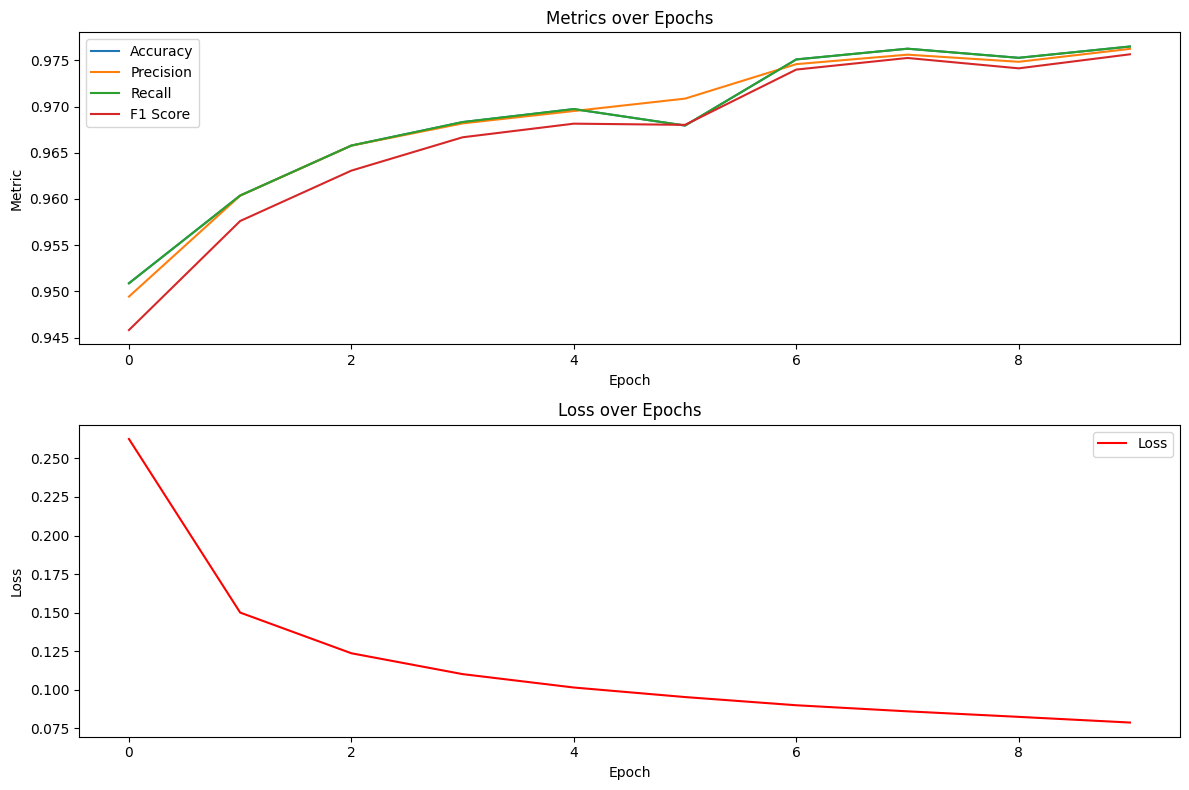

In [13]:
plot_metrics(epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses, "attention_oscnn_metrics")

In [14]:
import os
import zipfile
from google.colab import files

exclude_dirs = {
    "/content/.config",
    "/content/tsc_attention",
    "/content/.config",
    "/content/.ipynb_checkpoints",
    "/content/sample_data",
}
exclude_files = {
    "heartbeat.zip",
    "kaggle.json",
    "mitbih_test.csv",
    "mitbih_train.csv",
    "ptbdb_abnormal.csv",
    "ptbdb_normal.csv",
    "tsc_oscnn_skf.zip",
}

zip_filename = "/content/tsc_oscnn_skf.zip"
with zipfile.ZipFile(zip_filename, "w") as zipf:
    for root, dirs, files_ in os.walk("/content"):
        dirs[:] = [d for d in dirs if os.path.join(root, d) not in exclude_dirs]

        for file in files_:
            if file not in exclude_files:
                print(file)
                file_path = os.path.join(root, file)
                zipf.write(file_path)

files.download(zip_filename)

attention_oscnn_metrics.png
oscnn_metrics.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>